## Import libraries

In [2]:
!nvidia-smi

Tue Apr  4 18:09:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import os
import csv
import numpy as np
import pandas as pd
import tensorflow as tf
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale

## Get data

I'm going to use the historical price data of Bitcoin to try and predict the future price of Bitcoin!

The data was procured from the CoinDesk website located at: https://coindesk.com/price/bitcoin.

In [4]:
!wget https://raw.githubusercontent.com/NegreaAlexandruCristian/Lucrare-Dizertatie-ML/main/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2023-04-04 18:09:34--  https://raw.githubusercontent.com/NegreaAlexandruCristian/Lucrare-Dizertatie-ML/main/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 175721 (172K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 171.60K  --.-KB/s    in 0.02s   

2023-04-04 18:09:35 (7.32 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [175721/175721]



## Importing time series with pandas since it's a library that can read csv data directly and create a DataFrame

In [5]:
# Read our Bitcoin data and parse the data

timesteps = []
btc_prices = []
with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not strings)
    btc_prices.append(float(line[2])) # get the closing price as float

# View first 10 of each
timesteps[:10], btc_prices[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

In [6]:
# Visualize our data as a dataframe
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # prase the date column and tell pandas column 1 is a datetime 

df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [7]:
# Get info about our data
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [8]:
# Now let's see how many data samples that we have
len(df)

2787

I've collected the historical price of Bitcoin for the past 8 years (aproximately) but there are only 2787 samples.

A smaller number of samples is something that is normal when dealing with time series data problems. The term to better describe this is seasonality.

**Note:** Seasonality means that a time series dataset is reffered as the number of samples per year. So for this Bitcoin data, it has a seasonlity of daily or value of 365 because I'm collecting one sample per day meaning I'm getting 365 samples per year.

More about this can be found here: https://otexts.com/fpp3/tspatterns.html

In [9]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


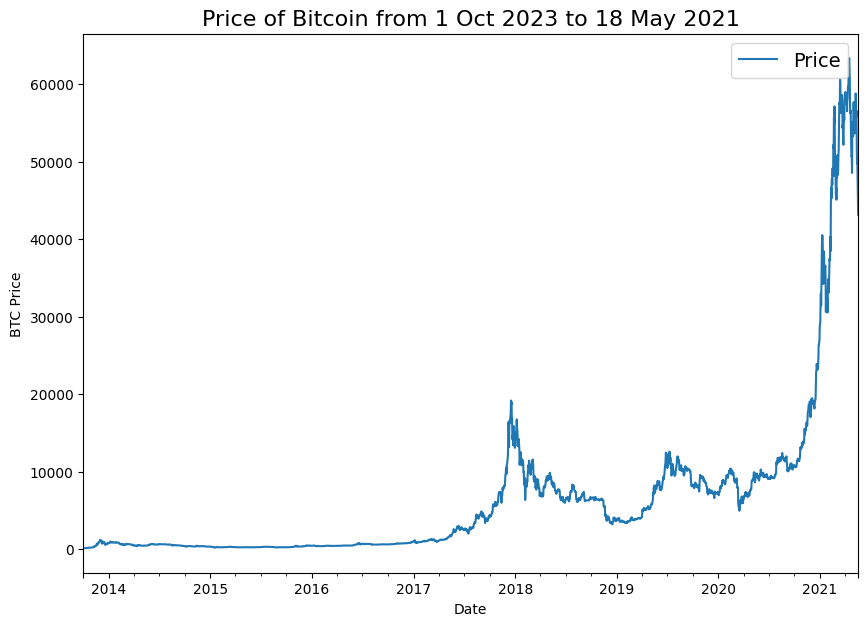

In [10]:
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2023 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14)

## Format data: Create train and test sets of the time series data above

In [11]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [12]:
# Create train and test splits
split_size = int(0.8 * len(prices)) # 80% train and 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything beyond the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

In [13]:
# Create function to plot time series data
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
  """
  Plots timesteps (a series of plot in time) against values (a series of values across timesteps)

  Parameters
  ----------
  timesteps: array of timesteps values
  values: array of values across time
  format: style of plot, defaul "."
  start: where to start the plot (setting a value will index from start of timesteps & values)
  end: where to end the plot (similar to start but for the end)
  label: label to show on plot about values, default None
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

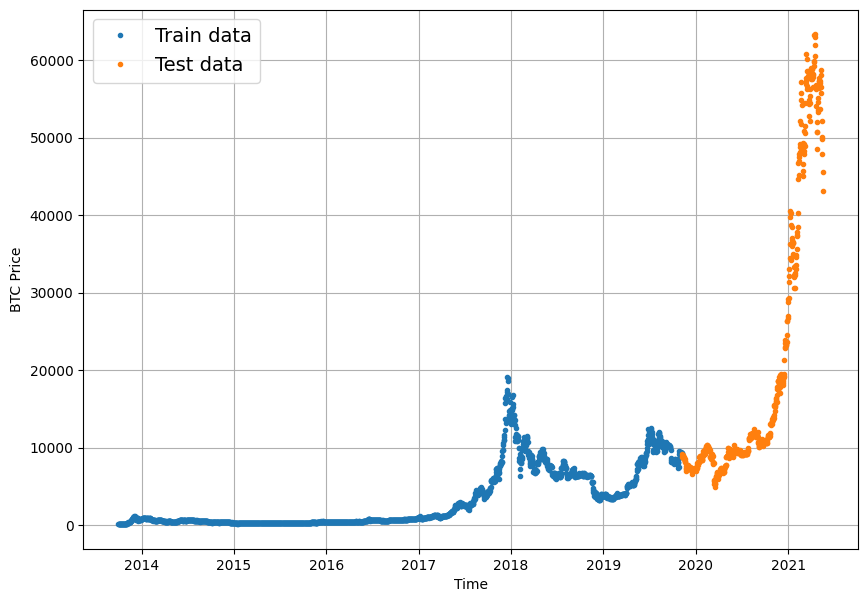

In [14]:
# Plot made splits
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

## Modelling Experiments

I will run several modelling experiments to see which one performs the best.

Terms to be familiar with:

* Horizon = number of timesteps into the future we're going to predict
* Window size = number of timesteps we're going to use to predict horizon

Modelling experiments I'll be running:

* 0 Naive model (baseline)
* 1 Dense model, horizon = 1, window = 7
* 2 Same as 1, horizon = 1, window = 30
* 3 Same as 1, horizon = 7, window = 30
* 4 Conv1D
* 5 LSTM
* 6 Same as 1 (but with multivariate data)
* 7 N-BEATs Algorithm
* 8 Ensemble (multiple models optimized on different loss functions)
* 9 Future prediction model (model to predict future values)
* 10 Same as 1 (but with turkey 🦃 data introduced)

## Model 0: Naive forecast model (the baseline)
More info here: https://otexts.com/fpp3/simple-methods.html

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

The prediction at timestep t (the y-hat) is equal to the value at timestep t-1 (previous timestep) - this is for a horizon of 1

In [15]:
# Create a naive forecast
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[:-10]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([ 9226.48582088,  8794.35864452,  8798.04205463,  9081.18687849,
         8711.53433917,  8760.89271814,  8749.52059102,  8656.97092235,
         8500.64355816,  8469.2608989 ,  8537.33965197,  8205.80636599,
         8118.4885358 ,  8074.84317361,  7612.7405735 ,  7262.11053495,
         7303.40575852,  7041.73293642,  7211.86180875,  7141.06944869,
         7523.4806726 ,  7390.20746923,  7729.26593894,  7542.23560864,
         7381.96300782,  7333.43293049,  7315.36776456,  7213.73376172,
         7398.78704961,  7511.88058312,  7532.12351309,  7550.23919987,
         7333.09604316,  7239.76257544,  7198.06667705,  7190.27236926,
         7238.87432299,  7087.02498535,  7112.73147612,  6883.49639377,
         6584.02884335,  7424.01540023,  7147.56832379,  7139.93337053,
         7286.33508116,  7236.98

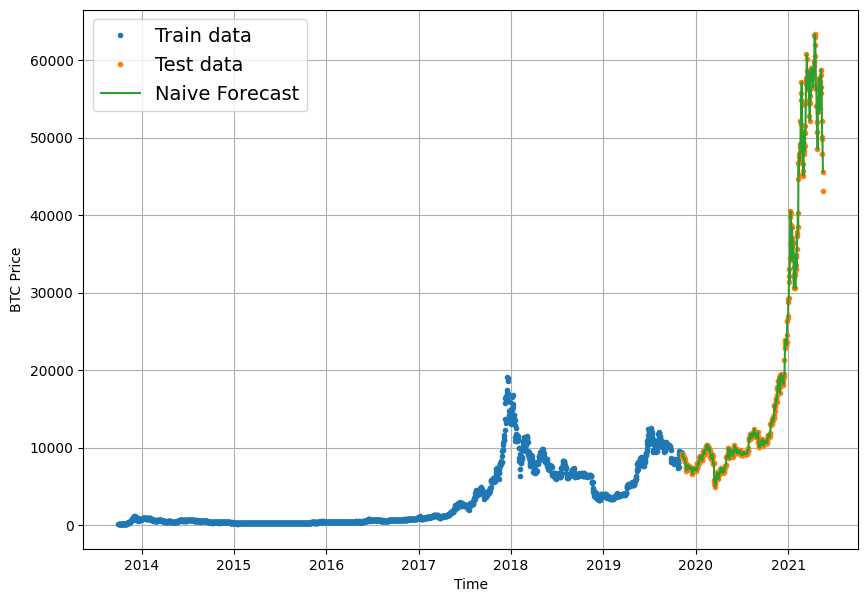

In [16]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive Forecast")

## Evaluating a time series model

I'm predicting a number, so that means I have a form of regression problem.

Because it is a regression problem, I'll need some regression-like metrics.

A few common regression metrics (which can also be used for time series forecasting):
* MAE - mean absolute error
* MSE - mean squared error
* RMSE - root mean square error
* MAPE/sMAPE - (symmetric) mean absolute percentage error
* MASE - mean absolute scaled error

For all of the above metrics, lower is better, for example, an MAE of 0 that is better than an MAE of 100.

The main thing that I'm evaluating here is: how the model's forecasts (y_pred) compare against the actual values (y_true or ground truth values)?

In [17]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # Find MAE of naive forecast (no seasonality)
  mea_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:]- y_true[:-1])) # our seasonality is 1 day (hence the shift is 1)
  
  return mae / mea_naive_no_season

In [18]:
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast).numpy()

0.9995699939182624

In [19]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatyep (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float64)
  y_pred = tf.cast(y_pred, dtype=tf.float64)

  # Calculate various evaluation metrcs#
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for diffrent size metrics (for longer horizons, we want to reduce metrics to a singular value)
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {
      "mae": mae.numpy(),
      "mse": mse.numpy(),
      "rmse": rmse.numpy(),
      "mape": mape.numpy(),
      "mase": mase.numpy()
  }

In [20]:
naive_results = evaluate_preds(y_true=y_test[1:], y_pred=naive_forecast)
naive_results

{'mae': 567.9802273457541,
 'mse': 1147547.1250238959,
 'rmse': 1071.2362601330744,
 'mape': 2.516524929982267,
 'mase': 0.9995699939182624}

## Window the dataset

I need to window the serues dataset to turn the data into a supervised learning problem.

```
Ex:
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [21]:
bitcoin_prices["Price"][:7]

Date
2013-10-01    123.65499
2013-10-02    125.45500
2013-10-03    108.58483
2013-10-04    118.67466
2013-10-05    121.33866
2013-10-06    120.65533
2013-10-07    121.79500
Name: Price, dtype: float64

In [22]:
# What I want to do with the Bitcoin data
print(f"I want to use this: {btc_prices[:7]} to predict this: {btc_prices[7]}")

I want to use this: [123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795] to predict this: 123.033


In [23]:
# Global variables for window and horizon size
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use the past week of bitcoin data to make the prediction

In [24]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1
  Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [25]:
# Test out the windows labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8) + 1, axis=0))
test_window, test_label

(<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>,
 <tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[8]], dtype=int32)>)

In [26]:
# Create function to view numpy arrays as windows by following this article:
# https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
  """
  Turns 1D array into a 2D array of sequential labelled windows of window_size with horizon size labels.
  """

  # Create a window of specific window_size (add the horizon on the end for labelling later)
  window_step = np.expand_dims(np.arange(window_size + horizon), axis=0)

  # Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon -1)), axis=0).T # create 2D array of windows of size window_size

  # Index on the target array (a time series) with 2D array of multiple window steps
  window_array = x[window_indexes]

  # Get the labelled windows
  windows, labels = get_labelled_windows(window_array, horizon=horizon)
  return windows, labels

In [27]:
full_windows, full_labels = make_windows(prices)
len(full_windows), len(full_labels)

(2780, 2780)

In [28]:
# View the first 3 windwos/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [29]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


## Turning windows into training and test sets

In [30]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Split matching pairs of windows and labels into train and test splits
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [31]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [32]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [33]:
test_windows[:5], test_labels[:5]

(array([[9290.89660239, 9202.41545055, 9369.62808116, 9326.59962378,
         9335.75240233, 9226.48582088, 8794.35864452],
        [9202.41545055, 9369.62808116, 9326.59962378, 9335.75240233,
         9226.48582088, 8794.35864452, 8798.04205463],
        [9369.62808116, 9326.59962378, 9335.75240233, 9226.48582088,
         8794.35864452, 8798.04205463, 9081.18687849],
        [9326.59962378, 9335.75240233, 9226.48582088, 8794.35864452,
         8798.04205463, 9081.18687849, 8711.53433917],
        [9335.75240233, 9226.48582088, 8794.35864452, 8798.04205463,
         9081.18687849, 8711.53433917, 8760.89271814]]),
 array([[8798.04205463],
        [9081.18687849],
        [8711.53433917],
        [8760.89271814],
        [8749.52059102]]))

In [34]:
# Check to see if train labels are the same (before and after window split)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

In [35]:
train_labels[:5].shape

(5, 1)

## Make a modelling checkpoint callback

Because the model's performance will flactuate from experiment to experiment I need to write a model checkpoint so that I can compare a model's performance to anothers.

For example, if the model performs the best on epoch 55 out of 100, I would like to save the model's performance and weights on that checkpoint.

In [36]:
# Create a function to implement a ModelCheckoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(
      filepath=os.path.join(save_path, model_name),
      verbosity=0, # only output a limited amount of text
      save_best_only=True
  )

## Model 1: Dense model (window = 7, horizon = 1)

The first deep model is going to be a simple dense model and is going to have the following parameters:

* A single dense layer with 128 hidden units and ReLU
* An output layer with linear activation (no activation)
* Adam optimizaiton and MAE loss function
* Batch size of 128
* 100 epochs

Those parameters are picked to experiment and test this model to see it's performance.

In [37]:
# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct the model
model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation
], name="model_1_dense")

# Compile the model
model_1.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["mae", "mse"]
)

# Fit the model
model_1.fit(
    x = train_windows,
    y = train_labels,
    epochs=100,
    verbose=1,
    batch_size=128,
    validation_data=(test_windows, test_labels),
    callbacks=[create_model_checkpoint(model_name="model_1_name")]
)

Epoch 1/100
17/18 [===========================>..] - ETA: 0s - loss: 1221.0457 - mae: 1221.0457 - mse: 5546944.0000   

18/18 [==============================] - 7s 54ms/step - loss: 1204.9241 - mae: 1204.9241 - mse: 5440556.0000 - val_loss: 2995.6755 - val_mae: 2995.6755 - val_mse: 19197196.0000
Epoch 2/100
16/18 [=========================>....] - ETA: 0s - loss: 300.4994 - mae: 300.4994 - mse: 371177.2188

18/18 [==============================] - 1s 47ms/step - loss: 286.3998 - mae: 286.3998 - mse: 347119.7188 - val_loss: 960.8157 - val_mae: 960.8157 - val_mse: 3099765.0000
Epoch 3/100
18/18 [==============================] - ETA: 0s - loss: 184.0637 - mae: 184.0637 - mse: 158844.8281

18/18 [==============================] - 1s 34ms/step - loss: 184.0637 - mae: 184.0637 - mse: 158844.8281 - val_loss: 902.8309 - val_mae: 902.8309 - val_mse: 2736239.0000
Epoch 4/100
18/18 [==============================] - ETA: 0s - loss: 166.5976 - mae: 166.5976 - mse: 146315.9219

18/18 [==============================] - 1s 34ms/step - loss: 166.5976 - mae: 166.5976 - mse: 146315.9219 - val_loss: 877.0538 - val_mae: 877.0538 - val_mse: 2588762.2500
Epoch 5/100
 1/18 [>.............................] - ETA: 0s - loss: 159.0257 - mae: 159.0257 - mse: 86685.4219

18/18 [==============================] - 1s 46ms/step - loss: 160.0372 - mae: 160.0372 - mse: 136006.5625 - val_loss: 849.2491 - val_mae: 849.2491 - val_mse: 2411135.0000
Epoch 6/100
14/18 [======================>.......] - ETA: 0s - loss: 153.3648 - mae: 153.3648 - mse: 113976.1406

18/18 [==============================] - 1s 49ms/step - loss: 155.1490 - mae: 155.1490 - mse: 127065.0625 - val_loss: 820.7159 - val_mae: 820.7159 - val_mse: 2238475.0000
Epoch 7/100
12/18 [===================>..........] - ETA: 0s - loss: 152.0029 - mae: 152.0029 - mse: 128655.8047

18/18 [==============================] - 1s 51ms/step - loss: 147.7941 - mae: 147.7941 - mse: 117581.9297 - val_loss: 799.6892 - val_mae: 799.6892 - val_mse: 2126594.2500
Epoch 8/100
12/18 [===================>..........] - ETA: 0s - loss: 141.6159 - mae: 141.6159 - mse: 111100.9141

18/18 [==============================] - 1s 42ms/step - loss: 141.7101 - mae: 141.7101 - mse: 111142.6953 - val_loss: 777.4850 - val_mae: 777.4850 - val_mse: 2026148.3750
Epoch 9/100
16/18 [=========================>....] - ETA: 0s - loss: 142.8291 - mae: 142.8291 - mse: 113077.3828

18/18 [==============================] - 1s 35ms/step - loss: 140.1561 - mae: 140.1561 - mse: 108770.8672 - val_loss: 762.5770 - val_mae: 762.5770 - val_mse: 1921942.6250
Epoch 10/100
17/18 [===========================>..] - ETA: 0s - loss: 138.1760 - mae: 138.1760 - mse: 106542.0625

18/18 [==============================] - 1s 35ms/step - loss: 139.0969 - mae: 139.0969 - mse: 107000.7266 - val_loss: 743.4722 - val_mae: 743.4722 - val_mse: 1829973.1250
Epoch 11/100
18/18 [==============================] - ETA: 0s - loss: 132.5665 - mae: 132.5665 - mse: 99173.9141

18/18 [==============================] - 1s 33ms/step - loss: 132.5665 - mae: 132.5665 - mse: 99173.9141 - val_loss: 741.6920 - val_mae: 741.6920 - val_mse: 1772563.6250
Epoch 12/100
18/18 [==============================] - 0s 6ms/step - loss: 130.7263 - mae: 130.7263 - mse: 96752.0000 - val_loss: 791.9706 - val_mae: 791.9706 - val_mse: 1879107.8750
Epoch 13/100
 1/18 [>.............................] - ETA: 0s - loss: 110.5957 - mae: 110.5957 - mse: 68073.6797

18/18 [==============================] - 1s 33ms/step - loss: 132.1806 - mae: 132.1806 - mse: 96932.6797 - val_loss: 737.9297 - val_mae: 737.9297 - val_mse: 1706539.0000
Epoch 14/100
18/18 [==============================] - ETA: 0s - loss: 126.4837 - mae: 126.4837 - mse: 91867.1250

18/18 [==============================] - 1s 34ms/step - loss: 126.4837 - mae: 126.4837 - mse: 91867.1250 - val_loss: 685.0338 - val_mae: 685.0338 - val_mse: 1577240.0000
Epoch 15/100
18/18 [==============================] - 0s 6ms/step - loss: 131.8719 - mae: 131.8719 - mse: 91885.8672 - val_loss: 707.1057 - val_mae: 707.1057 - val_mse: 1596489.8750
Epoch 16/100
18/18 [==============================] - 0s 6ms/step - loss: 122.8886 - mae: 122.8886 - mse: 86151.2031 - val_loss: 685.6229 - val_mae: 685.6229 - val_mse: 1534314.8750
Epoch 17/100
15/18 [========================>.....] - ETA: 0s - loss: 118.9739 - mae: 118.9739 - mse: 81313.2578

18/18 [==============================] - 1s 36ms/step - loss: 121.0508 - mae: 121.0508 - mse: 85703.2031 - val_loss: 668.7872 - val_mae: 668.7872 - val_mse: 1486765.8750
Epoch 18/100
18/18 [==============================] - ETA: 0s - loss: 121.3102 - mae: 121.3102 - mse: 84546.7031

18/18 [==============================] - 1s 34ms/step - loss: 121.3102 - mae: 121.3102 - mse: 84546.7031 - val_loss: 647.7029 - val_mae: 647.7029 - val_mse: 1445316.5000
Epoch 19/100
18/18 [==============================] - 0s 6ms/step - loss: 122.8865 - mae: 122.8865 - mse: 85449.9297 - val_loss: 701.7349 - val_mae: 701.7349 - val_mse: 1545117.2500
Epoch 20/100
14/18 [======================>.......] - ETA: 0s - loss: 120.5156 - mae: 120.5156 - mse: 84429.1406 

18/18 [==============================] - 1s 35ms/step - loss: 118.3875 - mae: 118.3875 - mse: 82505.3828 - val_loss: 644.1987 - val_mae: 644.1987 - val_mse: 1407784.1250
Epoch 21/100
 1/18 [>.............................] - ETA: 0s - loss: 126.7932 - mae: 126.7932 - mse: 74808.6250

18/18 [==============================] - 1s 34ms/step - loss: 119.0024 - mae: 119.0024 - mse: 82036.7109 - val_loss: 639.0275 - val_mae: 639.0275 - val_mse: 1413331.6250
Epoch 22/100
18/18 [==============================] - 0s 5ms/step - loss: 119.9696 - mae: 119.9696 - mse: 83505.0469 - val_loss: 671.4521 - val_mae: 671.4521 - val_mse: 1454199.1250
Epoch 23/100
 1/18 [>.............................] - ETA: 0s - loss: 126.9360 - mae: 126.9360 - mse: 67975.3984

18/18 [==============================] - 1s 49ms/step - loss: 123.4298 - mae: 123.4298 - mse: 83881.6953 - val_loss: 634.5386 - val_mae: 634.5386 - val_mse: 1364461.1250
Epoch 24/100
18/18 [==============================] - ETA: 0s - loss: 117.8094 - mae: 117.8094 - mse: 82058.4766

18/18 [==============================] - 1s 33ms/step - loss: 117.8094 - mae: 117.8094 - mse: 82058.4766 - val_loss: 626.6807 - val_mae: 626.6807 - val_mse: 1365535.2500
Epoch 25/100
15/18 [========================>.....] - ETA: 0s - loss: 122.4998 - mae: 122.4998 - mse: 84909.9141

18/18 [==============================] - 1s 35ms/step - loss: 118.6243 - mae: 118.6243 - mse: 79786.7891 - val_loss: 617.9769 - val_mae: 617.9769 - val_mse: 1324280.6250
Epoch 26/100
 9/18 [==============>...............] - ETA: 0s - loss: 112.2348 - mae: 112.2348 - mse: 65433.3906

18/18 [==============================] - 1s 35ms/step - loss: 115.4889 - mae: 115.4889 - mse: 78208.7969 - val_loss: 614.2561 - val_mae: 614.2561 - val_mse: 1316863.2500
Epoch 27/100
15/18 [========================>.....] - ETA: 0s - loss: 115.7213 - mae: 115.7213 - mse: 75919.5781 

18/18 [==============================] - 1s 36ms/step - loss: 115.9964 - mae: 115.9964 - mse: 78394.5000 - val_loss: 611.9225 - val_mae: 611.9225 - val_mse: 1314206.6250
Epoch 28/100
18/18 [==============================] - 0s 6ms/step - loss: 113.5662 - mae: 113.5662 - mse: 76785.2891 - val_loss: 613.7970 - val_mae: 613.7970 - val_mse: 1321939.7500
Epoch 29/100
18/18 [==============================] - 0s 6ms/step - loss: 113.9330 - mae: 113.9330 - mse: 77858.8828 - val_loss: 678.1783 - val_mae: 678.1783 - val_mse: 1443749.8750
Epoch 30/100
17/18 [===========================>..] - ETA: 0s - loss: 122.8687 - mae: 122.8687 - mse: 82604.8984

18/18 [==============================] - 1s 47ms/step - loss: 122.3492 - mae: 122.3492 - mse: 81800.0703 - val_loss: 611.7132 - val_mae: 611.7132 - val_mse: 1291792.3750
Epoch 31/100
18/18 [==============================] - 0s 8ms/step - loss: 113.6826 - mae: 113.6826 - mse: 74413.2578 - val_loss: 620.8777 - val_mae: 620.8777 - val_mse: 1304254.1250
Epoch 32/100
13/18 [====================>.........] - ETA: 0s - loss: 115.1875 - mae: 115.1875 - mse: 81133.7969

18/18 [==============================] - 1s 48ms/step - loss: 112.4486 - mae: 112.4486 - mse: 75934.9375 - val_loss: 607.9815 - val_mae: 607.9815 - val_mse: 1278166.5000
Epoch 33/100
18/18 [==============================] - 0s 9ms/step - loss: 113.4073 - mae: 113.4073 - mse: 75985.7812 - val_loss: 662.2389 - val_mae: 662.2389 - val_mse: 1390753.3750
Epoch 34/100
13/18 [====================>.........] - ETA: 0s - loss: 116.5970 - mae: 116.5970 - mse: 84311.7812 

18/18 [==============================] - 1s 47ms/step - loss: 112.7949 - mae: 112.7949 - mse: 76186.8125 - val_loss: 598.7183 - val_mae: 598.7183 - val_mse: 1269963.0000
Epoch 35/100
18/18 [==============================] - 0s 5ms/step - loss: 111.1627 - mae: 111.1627 - mse: 74957.6016 - val_loss: 609.0258 - val_mae: 609.0258 - val_mse: 1295643.8750
Epoch 36/100
 1/18 [>.............................] - ETA: 0s - loss: 156.4617 - mae: 156.4617 - mse: 134207.2500

18/18 [==============================] - 1s 34ms/step - loss: 115.5181 - mae: 115.5181 - mse: 75867.9531 - val_loss: 592.8017 - val_mae: 592.8017 - val_mse: 1246954.1250
Epoch 37/100
18/18 [==============================] - 0s 6ms/step - loss: 110.9746 - mae: 110.9746 - mse: 74694.0547 - val_loss: 606.3179 - val_mae: 606.3179 - val_mse: 1261516.6250
Epoch 38/100
18/18 [==============================] - 0s 5ms/step - loss: 111.9249 - mae: 111.9249 - mse: 74883.7109 - val_loss: 630.5084 - val_mae: 630.5084 - val_mse: 1342724.1250
Epoch 39/100
15/18 [========================>.....] - ETA: 0s - loss: 114.4185 - mae: 114.4185 - mse: 79350.6719 

18/18 [==============================] - 1s 34ms/step - loss: 110.9029 - mae: 110.9029 - mse: 74370.9453 - val_loss: 589.5988 - val_mae: 589.5988 - val_mse: 1236116.0000
Epoch 40/100
18/18 [==============================] - 0s 6ms/step - loss: 109.8087 - mae: 109.8087 - mse: 72649.7969 - val_loss: 599.0119 - val_mae: 599.0119 - val_mse: 1265008.3750
Epoch 41/100
18/18 [==============================] - 0s 5ms/step - loss: 110.5171 - mae: 110.5171 - mse: 73883.8359 - val_loss: 606.4065 - val_mae: 606.4065 - val_mse: 1281906.3750
Epoch 42/100
18/18 [==============================] - 0s 7ms/step - loss: 114.2111 - mae: 114.2111 - mse: 76672.9141 - val_loss: 692.9580 - val_mae: 692.9580 - val_mse: 1442117.8750
Epoch 43/100
18/18 [==============================] - 0s 5ms/step - loss: 119.9205 - mae: 119.9205 - mse: 75838.7734 - val_loss: 682.2908 - val_mae: 682.2908 - val_mse: 1471050.0000
Epoch 44/100
18/18 [==============================] - 0s 6ms/step - loss: 122.7175 - mae: 122.7175 - m

18/18 [==============================] - 1s 34ms/step - loss: 111.3534 - mae: 111.3534 - mse: 74914.5391 - val_loss: 583.9374 - val_mae: 583.9374 - val_mse: 1221280.8750
Epoch 46/100
18/18 [==============================] - 0s 6ms/step - loss: 110.4921 - mae: 110.4921 - mse: 71706.2266 - val_loss: 656.9083 - val_mae: 656.9083 - val_mse: 1352677.0000
Epoch 47/100
18/18 [==============================] - 0s 6ms/step - loss: 114.1761 - mae: 114.1761 - mse: 75059.5234 - val_loss: 586.7697 - val_mae: 586.7697 - val_mse: 1213396.2500
Epoch 48/100
18/18 [==============================] - 0s 6ms/step - loss: 110.6312 - mae: 110.6312 - mse: 73247.5547 - val_loss: 696.7451 - val_mae: 696.7451 - val_mse: 1447944.1250
Epoch 49/100
18/18 [==============================] - 0s 6ms/step - loss: 121.4095 - mae: 121.4095 - mse: 77547.8438 - val_loss: 585.9692 - val_mae: 585.9692 - val_mse: 1230101.1250
Epoch 50/100
18/18 [==============================] - 0s 6ms/step - loss: 108.0779 - mae: 108.0779 - m

18/18 [==============================] - 1s 34ms/step - loss: 112.8423 - mae: 112.8423 - mse: 73768.7656 - val_loss: 582.6724 - val_mae: 582.6724 - val_mse: 1203508.7500
Epoch 60/100
18/18 [==============================] - 0s 6ms/step - loss: 109.8190 - mae: 109.8190 - mse: 72026.8750 - val_loss: 665.3805 - val_mae: 665.3805 - val_mse: 1364282.5000
Epoch 61/100
 1/18 [>.............................] - ETA: 0s - loss: 145.9918 - mae: 145.9918 - mse: 101183.7656

18/18 [==============================] - 1s 32ms/step - loss: 108.9386 - mae: 108.9386 - mse: 71057.9844 - val_loss: 580.0624 - val_mae: 580.0624 - val_mse: 1194339.6250
Epoch 62/100
17/18 [===========================>..] - ETA: 0s - loss: 107.9284 - mae: 107.9284 - mse: 70539.6328

18/18 [==============================] - 1s 33ms/step - loss: 107.8218 - mae: 107.8218 - mse: 70420.4219 - val_loss: 577.3160 - val_mae: 577.3160 - val_mse: 1202040.6250
Epoch 63/100
18/18 [==============================] - 0s 6ms/step - loss: 111.3343 - mae: 111.3343 - mse: 72369.4844 - val_loss: 700.3253 - val_mae: 700.3253 - val_mse: 1447110.5000
Epoch 64/100
18/18 [==============================] - 0s 6ms/step - loss: 114.3064 - mae: 114.3064 - mse: 74071.8516 - val_loss: 582.6927 - val_mae: 582.6927 - val_mse: 1193556.5000
Epoch 65/100
18/18 [==============================] - 0s 5ms/step - loss: 108.3193 - mae: 108.3193 - mse: 70427.1719 - val_loss: 596.6659 - val_mae: 596.6659 - val_mse: 1215649.6250
Epoch 66/100
18/18 [==============================] - 0s 5ms/step - loss: 108.3037 - mae: 108.3037 - mse: 70491.0469 - val_loss: 585.7983 - val_mae: 585.7983 - val_mse: 1198684.6250
Epoch 67/100
18/18 [==============================] - 0s 5ms/step - loss: 107.7711 - mae: 107.7711 - m

18/18 [==============================] - 1s 49ms/step - loss: 111.4504 - mae: 111.4504 - mse: 74198.6953 - val_loss: 572.5828 - val_mae: 572.5828 - val_mse: 1188515.8750
Epoch 73/100
18/18 [==============================] - 0s 6ms/step - loss: 105.8384 - mae: 105.8384 - mse: 69105.3359 - val_loss: 582.5099 - val_mae: 582.5099 - val_mse: 1193853.8750
Epoch 74/100
18/18 [==============================] - 0s 5ms/step - loss: 109.7806 - mae: 109.7806 - mse: 71610.5000 - val_loss: 600.7223 - val_mae: 600.7223 - val_mse: 1244943.0000
Epoch 75/100
18/18 [==============================] - 0s 6ms/step - loss: 110.9385 - mae: 110.9385 - mse: 72263.5000 - val_loss: 585.9645 - val_mae: 585.9645 - val_mse: 1191448.3750
Epoch 76/100
18/18 [==============================] - 0s 6ms/step - loss: 109.3704 - mae: 109.3704 - mse: 70783.7656 - val_loss: 581.8424 - val_mae: 581.8424 - val_mse: 1184700.1250
Epoch 77/100
18/18 [==============================] - 0s 5ms/step - loss: 110.4865 - mae: 110.4865 - m

18/18 [==============================] - 1s 34ms/step - loss: 108.5800 - mae: 108.5800 - mse: 71308.2734 - val_loss: 568.1332 - val_mae: 568.1332 - val_mse: 1173119.2500
Epoch 86/100
18/18 [==============================] - 0s 5ms/step - loss: 105.7213 - mae: 105.7213 - mse: 68388.0078 - val_loss: 570.6243 - val_mae: 570.6243 - val_mse: 1166699.7500
Epoch 87/100
18/18 [==============================] - 0s 9ms/step - loss: 105.6327 - mae: 105.6327 - mse: 67777.4688 - val_loss: 617.6718 - val_mae: 617.6718 - val_mse: 1281172.2500
Epoch 88/100
18/18 [==============================] - 0s 8ms/step - loss: 109.8143 - mae: 109.8143 - mse: 71010.0547 - val_loss: 571.9095 - val_mae: 571.9095 - val_mse: 1182610.8750
Epoch 89/100
18/18 [==============================] - 0s 8ms/step - loss: 107.2642 - mae: 107.2642 - mse: 68884.2578 - val_loss: 586.9504 - val_mae: 586.9504 - val_mse: 1196797.7500
Epoch 90/100
18/18 [==============================] - 0s 8ms/step - loss: 108.2918 - mae: 108.2918 - m

18/18 [==============================] - 1s 50ms/step - loss: 111.0530 - mae: 111.0530 - mse: 71681.9141 - val_loss: 566.9006 - val_mae: 566.9006 - val_mse: 1167955.5000
Epoch 92/100
18/18 [==============================] - 0s 8ms/step - loss: 109.2137 - mae: 109.2137 - mse: 70842.8594 - val_loss: 652.5542 - val_mae: 652.5542 - val_mse: 1367266.7500
Epoch 93/100
18/18 [==============================] - 0s 8ms/step - loss: 122.1137 - mae: 122.1137 - mse: 76953.0391 - val_loss: 639.5927 - val_mae: 639.5927 - val_mse: 1335700.5000
Epoch 94/100
18/18 [==============================] - 0s 8ms/step - loss: 113.3542 - mae: 113.3542 - mse: 74106.5625 - val_loss: 590.7797 - val_mae: 590.7797 - val_mse: 1198973.7500
Epoch 95/100
18/18 [==============================] - 0s 8ms/step - loss: 105.9497 - mae: 105.9497 - mse: 68242.7109 - val_loss: 569.2809 - val_mae: 569.2809 - val_mse: 1167784.7500
Epoch 96/100
18/18 [==============================] - 0s 8ms/step - loss: 106.6370 - mae: 106.6370 - m

In [38]:
# Evaluate model on test_data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 629.6243 - mae: 629.6243 - mse: 1278354.6250


[629.624267578125, 629.624267578125, 1278354.625]

In [39]:
# Load in the best performing model_1 and evaluate it on test data
model_1 = tf.keras.models.load_model("/content/model_experiments/model_1_name")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 566.9009 - mae: 566.9009 - mse: 1167956.0000


[566.90087890625, 566.90087890625, 1167956.0]

## Making forecasts with the model (on the test dataset)

To make "forecasts" in the test dataset (note: this won't be actual forecasts, they're only pseudo forecasts because actual forecasts are into the future)"

Now to make those forecasts I'm going to create a function to do this:

(What the function parameters will be)
1. Take in a train model
2. Takes in some input data (same kind of data the model was trained on)
3. Passes the input data to the model's `predict()` method
4. Returns the prediction

In [40]:
def make_preds(model, input_data):
  """
  Uses model to make predictions input_data
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) #  return 1D array of predictions

In [41]:
# Make predicitons using model_1 on the test dataset and view results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 2ms/step


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8851.499 , 8778.734 , 9046.171 , 8799.594 , 8752.458 , 8753.989 ,
        8668.891 , 8525.677 , 8474.4375, 8527.392 ], dtype=float32)>)

In [42]:
# Evaluate preds
model_1_results = evaluate_preds(y_true = tf.squeeze(test_labels), y_pred = model_1_preds)
model_1_results

{'mae': 566.9008258970482,
 'mse': 1167956.1493508038,
 'rmse': 1080.7201993813217,
 'mape': 2.534413413599998,
 'mase': 0.9958876299792072}

In [43]:
naive_results

{'mae': 567.9802273457541,
 'mse': 1147547.1250238959,
 'rmse': 1071.2362601330744,
 'mape': 2.516524929982267,
 'mase': 0.9995699939182624}

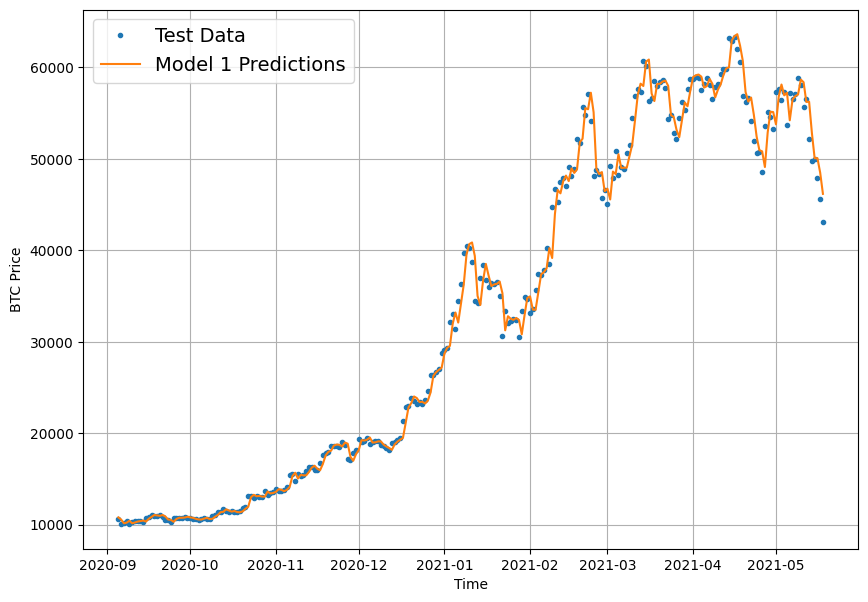

In [44]:
# Plot our model 1 predictions
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:, 0],
                 start=offset,
                 label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_1_preds,
                 start=offset,
                 format="-",
                 label="Model 1 Predictions")

## Model 2: Dense model (window = 30, horizon = 1)

(Same as model 1 but different Hypeparameters)

In [45]:
WINDOW_SIZE = 30 # use 30 timesteps in the past
HORIZON = 1 # predict one step at a time (one day of Bitcoin prices)

In [46]:
# Make window data with appropiate horizon and window size
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [47]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(
    windows=full_windows,
    labels=full_labels
)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [48]:
train_windows[:3], train_labels[:3]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  , 123.033  , 124.049  , 125.96116, 125.27966, 125.9275 ,
         126.38333, 135.24199, 133.20333, 142.76333, 137.92333, 142.95166,
         152.55183, 160.33883, 164.31499, 177.63333, 188.29716, 200.70166,
         180.355  , 175.03166, 177.6965 , 187.15983, 192.75666, 197.4    ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  , 124.049  , 125.96116, 125.27966, 125.9275 , 126.38333,
         135.24199, 133.20333, 142.76333, 137.92333, 142.95166, 152.55183,
         160.33883, 164.31499, 177.63333, 188.29716, 200.70166, 180.355  ,
         175.03166, 177.6965 , 187.15983, 192.75666, 197.4    , 196.02499],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  , 125.96116, 125.27966, 125.9275 , 126.38333, 135.24199,
         133.20333, 142.76333, 137.92333, 142.95166, 152.55183, 160.33883,
         164.31499, 177

In [49]:
# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct the model
model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(HORIZON)
], name="model_2_dense")

# Compile the model
model_2.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["mae", "mse"]
)

# Fit the model
model_2.fit(
    x = train_windows,
    y = train_labels,
    epochs=100,
    verbose=1,
    batch_size=128,
    validation_data=(test_windows, test_labels),
    callbacks=[create_model_checkpoint(model_name="model_2_name")]
)

Epoch 1/100
16/18 [=========================>....] - ETA: 0s - loss: 1020.3812 - mae: 1020.3812 - mse: 4272643.0000  

18/18 [==============================] - 2s 44ms/step - loss: 985.6208 - mae: 985.6208 - mse: 4043313.5000 - val_loss: 3725.5891 - val_mae: 3725.5891 - val_mse: 29066132.0000
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 577.5768 - mae: 577.5768 - mse: 1075659.6250

18/18 [==============================] - 1s 33ms/step - loss: 344.6270 - mae: 344.6270 - mse: 500951.7188 - val_loss: 1405.6006 - val_mae: 1405.6006 - val_mse: 6148467.0000
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 258.2485 - mae: 258.2485 - mse: 343968.0312

18/18 [==============================] - 1s 32ms/step - loss: 258.1508 - mae: 258.1508 - mse: 324795.1875 - val_loss: 1382.5575 - val_mae: 1382.5575 - val_mse: 5609397.5000
Epoch 4/100
10/18 [===============>..............] - ETA: 0s - loss: 232.3529 - mae: 232.3529 - mse: 273281.5938

18/18 [==============================] - 2s 96ms/step - loss: 235.6313 - mae: 235.6313 - mse: 274411.4375 - val_loss: 1286.4847 - val_mae: 1286.4847 - val_mse: 4956191.0000
Epoch 5/100
18/18 [==============================] - ETA: 0s - loss: 219.2186 - mae: 219.2186 - mse: 241280.4219

18/18 [==============================] - 2s 119ms/step - loss: 219.2186 - mae: 219.2186 - mse: 241280.4219 - val_loss: 1160.9414 - val_mae: 1160.9414 - val_mse: 4322263.5000
Epoch 6/100
18/18 [==============================] - 0s 10ms/step - loss: 220.3893 - mae: 220.3893 - mse: 236599.3125 - val_loss: 1281.5847 - val_mae: 1281.5847 - val_mse: 4462240.0000
Epoch 7/100
16/18 [=========================>....] - ETA: 0s - loss: 202.4056 - mae: 202.4056 - mse: 208480.5156

18/18 [==============================] - 1s 34ms/step - loss: 200.1247 - mae: 200.1247 - mse: 204420.4531 - val_loss: 1091.5742 - val_mae: 1091.5742 - val_mse: 3868962.7500
Epoch 8/100
18/18 [==============================] - ETA: 0s - loss: 193.5908 - mae: 193.5908 - mse: 191611.7969

18/18 [==============================] - 1s 33ms/step - loss: 193.5908 - mae: 193.5908 - mse: 191611.7969 - val_loss: 1073.7188 - val_mae: 1073.7188 - val_mse: 3398603.2500
Epoch 9/100
17/18 [===========================>..] - ETA: 0s - loss: 183.9454 - mae: 183.9454 - mse: 173484.9219

18/18 [==============================] - 1s 34ms/step - loss: 184.2767 - mae: 184.2767 - mse: 172673.4062 - val_loss: 1066.1591 - val_mae: 1066.1591 - val_mse: 3293205.2500
Epoch 10/100
18/18 [==============================] - ETA: 0s - loss: 197.9673 - mae: 197.9673 - mse: 183030.5156

18/18 [==============================] - 1s 49ms/step - loss: 197.9673 - mae: 197.9673 - mse: 183030.5156 - val_loss: 964.6207 - val_mae: 964.6207 - val_mse: 3047826.7500
Epoch 11/100
18/18 [==============================] - 0s 6ms/step - loss: 171.9997 - mae: 171.9997 - mse: 156442.0156 - val_loss: 980.6397 - val_mae: 980.6397 - val_mse: 2855020.0000
Epoch 12/100
16/18 [=========================>....] - ETA: 0s - loss: 164.2978 - mae: 164.2978 - mse: 147058.9688

18/18 [==============================] - 1s 36ms/step - loss: 163.9971 - mae: 163.9971 - mse: 147991.2031 - val_loss: 948.4568 - val_mae: 948.4568 - val_mse: 2704808.5000
Epoch 13/100
 1/18 [>.............................] - ETA: 0s - loss: 153.9606 - mae: 153.9606 - mse: 103547.1953

18/18 [==============================] - 1s 33ms/step - loss: 159.7368 - mae: 159.7368 - mse: 139699.7969 - val_loss: 886.5682 - val_mae: 886.5682 - val_mse: 2491137.7500
Epoch 14/100
18/18 [==============================] - 0s 6ms/step - loss: 174.3933 - mae: 174.3933 - mse: 149164.6406 - val_loss: 961.4913 - val_mae: 961.4913 - val_mse: 2894702.7500
Epoch 15/100
18/18 [==============================] - 0s 5ms/step - loss: 170.0733 - mae: 170.0733 - mse: 140000.4062 - val_loss: 922.3262 - val_mae: 922.3262 - val_mse: 2730024.7500
Epoch 16/100
18/18 [==============================] - 0s 6ms/step - loss: 164.6696 - mae: 164.6696 - mse: 140289.5781 - val_loss: 975.2122 - val_mae: 975.2122 - val_mse: 3036037.5000
Epoch 17/100
18/18 [==============================] - 0s 6ms/step - loss: 156.3582 - mae: 156.3582 - mse: 131375.5000 - val_loss: 1074.4102 - val_mae: 1074.4102 - val_mse: 3027140.7500
Epoch 18/100
18/18 [==============================] - 0s 6ms/step - loss: 155.1139 - mae: 155.1

18/18 [==============================] - 1s 34ms/step - loss: 150.5631 - mae: 150.5631 - mse: 122864.0938 - val_loss: 818.5488 - val_mae: 818.5488 - val_mse: 2149342.5000
Epoch 21/100
18/18 [==============================] - 0s 6ms/step - loss: 153.5671 - mae: 153.5671 - mse: 126671.3125 - val_loss: 865.3090 - val_mae: 865.3090 - val_mse: 2210004.0000
Epoch 22/100
18/18 [==============================] - 0s 5ms/step - loss: 152.7827 - mae: 152.7827 - mse: 117178.1172 - val_loss: 835.3795 - val_mae: 835.3795 - val_mse: 2277192.2500
Epoch 23/100
18/18 [==============================] - 0s 5ms/step - loss: 143.7770 - mae: 143.7770 - mse: 112736.5625 - val_loss: 874.6423 - val_mae: 874.6423 - val_mse: 2215294.0000
Epoch 24/100
18/18 [==============================] - 0s 5ms/step - loss: 142.2064 - mae: 142.2064 - mse: 111383.5625 - val_loss: 847.1402 - val_mae: 847.1402 - val_mse: 2367803.7500
Epoch 25/100
18/18 [==============================] - 0s 16ms/step - loss: 151.4061 - mae: 151.40

18/18 [==============================] - 1s 62ms/step - loss: 139.3861 - mae: 139.3861 - mse: 109719.0000 - val_loss: 796.2874 - val_mae: 796.2874 - val_mse: 2092841.5000
Epoch 27/100
18/18 [==============================] - ETA: 0s - loss: 150.5882 - mae: 150.5882 - mse: 115495.3984

18/18 [==============================] - 1s 75ms/step - loss: 150.5882 - mae: 150.5882 - mse: 115495.3984 - val_loss: 769.1683 - val_mae: 769.1683 - val_mse: 1882152.1250
Epoch 28/100
18/18 [==============================] - 0s 6ms/step - loss: 137.8500 - mae: 137.8500 - mse: 108305.8438 - val_loss: 865.3061 - val_mae: 865.3061 - val_mse: 2425353.7500
Epoch 29/100
 1/18 [>.............................] - ETA: 0s - loss: 202.4325 - mae: 202.4325 - mse: 191445.7500

18/18 [==============================] - 1s 77ms/step - loss: 144.6559 - mae: 144.6559 - mse: 111115.1250 - val_loss: 766.9256 - val_mae: 766.9256 - val_mse: 1843060.6250
Epoch 30/100
18/18 [==============================] - 0s 8ms/step - loss: 136.5466 - mae: 136.5466 - mse: 102266.9609 - val_loss: 896.2592 - val_mae: 896.2592 - val_mse: 2221712.7500
Epoch 31/100
11/18 [=================>............] - ETA: 0s - loss: 139.6154 - mae: 139.6154 - mse: 96966.3203

18/18 [==============================] - 1s 47ms/step - loss: 137.1967 - mae: 137.1967 - mse: 101921.3438 - val_loss: 757.1292 - val_mae: 757.1292 - val_mse: 1803068.0000
Epoch 32/100
18/18 [==============================] - 0s 8ms/step - loss: 144.9140 - mae: 144.9140 - mse: 109549.3750 - val_loss: 769.3934 - val_mae: 769.3934 - val_mse: 1808447.5000
Epoch 33/100
14/18 [======================>.......] - ETA: 0s - loss: 133.7411 - mae: 133.7411 - mse: 95453.6484

18/18 [==============================] - 1s 50ms/step - loss: 136.9383 - mae: 136.9383 - mse: 101082.8516 - val_loss: 734.4352 - val_mae: 734.4352 - val_mse: 1729847.6250
Epoch 34/100
18/18 [==============================] - 0s 8ms/step - loss: 131.9738 - mae: 131.9738 - mse: 98268.8828 - val_loss: 850.3272 - val_mae: 850.3272 - val_mse: 2308304.2500
Epoch 35/100
18/18 [==============================] - 0s 6ms/step - loss: 147.6332 - mae: 147.6332 - mse: 109675.2969 - val_loss: 744.4199 - val_mae: 744.4199 - val_mse: 1802320.2500
Epoch 36/100
18/18 [==============================] - 0s 7ms/step - loss: 135.1673 - mae: 135.1673 - mse: 98802.5312 - val_loss: 790.9571 - val_mae: 790.9571 - val_mse: 1860356.2500
Epoch 37/100
18/18 [==============================] - 0s 6ms/step - loss: 137.3876 - mae: 137.3876 - mse: 100541.4297 - val_loss: 735.3458 - val_mae: 735.3458 - val_mse: 1719738.1250
Epoch 38/100
18/18 [==============================] - 0s 6ms/step - loss: 128.2059 - mae: 128.2059 

18/18 [==============================] - 1s 34ms/step - loss: 130.8445 - mae: 130.8445 - mse: 92896.2578 - val_loss: 726.4796 - val_mae: 726.4796 - val_mse: 1700092.1250
Epoch 40/100
18/18 [==============================] - 0s 7ms/step - loss: 129.3117 - mae: 129.3117 - mse: 94668.8281 - val_loss: 753.5157 - val_mae: 753.5157 - val_mse: 1758915.0000
Epoch 41/100
18/18 [==============================] - 0s 5ms/step - loss: 128.2544 - mae: 128.2544 - mse: 92066.2969 - val_loss: 734.1234 - val_mae: 734.1234 - val_mse: 1688324.3750
Epoch 42/100
 1/18 [>.............................] - ETA: 0s - loss: 110.2486 - mae: 110.2486 - mse: 57925.2422

18/18 [==============================] - 1s 33ms/step - loss: 128.2513 - mae: 128.2513 - mse: 92312.8125 - val_loss: 705.2681 - val_mae: 705.2681 - val_mse: 1630940.2500
Epoch 43/100
18/18 [==============================] - 0s 6ms/step - loss: 129.1395 - mae: 129.1395 - mse: 92220.1797 - val_loss: 734.4235 - val_mae: 734.4235 - val_mse: 1765710.0000
Epoch 44/100
18/18 [==============================] - ETA: 0s - loss: 133.0196 - mae: 133.0196 - mse: 96119.5469 

18/18 [==============================] - 1s 34ms/step - loss: 133.0196 - mae: 133.0196 - mse: 96119.5469 - val_loss: 703.8423 - val_mae: 703.8423 - val_mse: 1628484.0000
Epoch 45/100
18/18 [==============================] - ETA: 0s - loss: 127.7291 - mae: 127.7291 - mse: 90729.7656

18/18 [==============================] - 1s 33ms/step - loss: 127.7291 - mae: 127.7291 - mse: 90729.7656 - val_loss: 703.7391 - val_mae: 703.7391 - val_mse: 1583535.0000
Epoch 46/100
12/18 [===================>..........] - ETA: 0s - loss: 127.0285 - mae: 127.0285 - mse: 83347.1094

18/18 [==============================] - 1s 34ms/step - loss: 135.1949 - mae: 135.1949 - mse: 94092.0078 - val_loss: 701.5040 - val_mae: 701.5040 - val_mse: 1559970.2500
Epoch 47/100
18/18 [==============================] - 0s 6ms/step - loss: 135.2939 - mae: 135.2939 - mse: 99895.3281 - val_loss: 801.2806 - val_mae: 801.2806 - val_mse: 1849499.3750
Epoch 48/100
18/18 [==============================] - 0s 5ms/step - loss: 138.8823 - mae: 138.8823 - mse: 97498.9219 - val_loss: 713.2553 - val_mae: 713.2553 - val_mse: 1600547.3750
Epoch 49/100
18/18 [==============================] - 0s 5ms/step - loss: 126.2472 - mae: 126.2472 - mse: 88814.8203 - val_loss: 806.8907 - val_mae: 806.8907 - val_mse: 2063200.2500
Epoch 50/100
15/18 [========================>.....] - ETA: 0s - loss: 152.2198 - mae: 152.2198 - mse: 105038.8359

18/18 [==============================] - 1s 50ms/step - loss: 152.4835 - mae: 152.4835 - mse: 106099.7812 - val_loss: 700.7042 - val_mae: 700.7042 - val_mse: 1575072.8750
Epoch 51/100
18/18 [==============================] - 0s 6ms/step - loss: 130.9876 - mae: 130.9876 - mse: 88239.6484 - val_loss: 1018.4982 - val_mae: 1018.4982 - val_mse: 2917562.7500
Epoch 52/100
17/18 [===========================>..] - ETA: 0s - loss: 143.6778 - mae: 143.6778 - mse: 104600.7969

18/18 [==============================] - 1s 35ms/step - loss: 143.2362 - mae: 143.2362 - mse: 103671.4688 - val_loss: 685.2227 - val_mae: 685.2227 - val_mse: 1548067.3750
Epoch 53/100
18/18 [==============================] - 0s 6ms/step - loss: 124.8734 - mae: 124.8734 - mse: 85333.2500 - val_loss: 772.6567 - val_mae: 772.6567 - val_mse: 1930362.2500
Epoch 54/100
18/18 [==============================] - 0s 6ms/step - loss: 134.0232 - mae: 134.0232 - mse: 95298.8828 - val_loss: 780.6270 - val_mae: 780.6270 - val_mse: 1798769.7500
Epoch 55/100
18/18 [==============================] - 0s 7ms/step - loss: 140.1412 - mae: 140.1412 - mse: 97114.2578 - val_loss: 698.3916 - val_mae: 698.3916 - val_mse: 1545156.6250
Epoch 56/100
18/18 [==============================] - 0s 6ms/step - loss: 143.4032 - mae: 143.4032 - mse: 99094.8125 - val_loss: 693.1354 - val_mae: 693.1354 - val_mse: 1526142.7500
Epoch 57/100
18/18 [==============================] - 0s 7ms/step - loss: 123.2529 - mae: 123.2529 - 

18/18 [==============================] - 1s 35ms/step - loss: 147.6217 - mae: 147.6217 - mse: 103812.9375 - val_loss: 671.0244 - val_mae: 671.0244 - val_mse: 1472694.7500
Epoch 60/100
18/18 [==============================] - 0s 6ms/step - loss: 120.5076 - mae: 120.5076 - mse: 81289.0391 - val_loss: 671.6016 - val_mae: 671.6016 - val_mse: 1495706.0000
Epoch 61/100
18/18 [==============================] - 0s 6ms/step - loss: 122.7362 - mae: 122.7362 - mse: 84506.1328 - val_loss: 677.9076 - val_mae: 677.9076 - val_mse: 1519244.1250
Epoch 62/100
18/18 [==============================] - 0s 7ms/step - loss: 130.7508 - mae: 130.7508 - mse: 85809.3906 - val_loss: 959.3942 - val_mae: 959.3942 - val_mse: 2631929.5000
Epoch 63/100
18/18 [==============================] - 0s 5ms/step - loss: 138.9925 - mae: 138.9925 - mse: 96923.4531 - val_loss: 723.5432 - val_mae: 723.5432 - val_mse: 1688786.2500
Epoch 64/100
18/18 [==============================] - 0s 6ms/step - loss: 133.1348 - mae: 133.1348 - 

18/18 [==============================] - 1s 34ms/step - loss: 140.5889 - mae: 140.5889 - mse: 98053.6719 - val_loss: 659.3339 - val_mae: 659.3339 - val_mse: 1432602.0000
Epoch 67/100
18/18 [==============================] - 0s 6ms/step - loss: 121.3698 - mae: 121.3698 - mse: 82567.3516 - val_loss: 693.6404 - val_mae: 693.6404 - val_mse: 1514022.1250
Epoch 68/100
 1/18 [>.............................] - ETA: 0s - loss: 94.7376 - mae: 94.7376 - mse: 38199.4727

18/18 [==============================] - 1s 32ms/step - loss: 121.9011 - mae: 121.9011 - mse: 83859.9141 - val_loss: 651.9152 - val_mae: 651.9152 - val_mse: 1403832.1250
Epoch 69/100
18/18 [==============================] - 0s 6ms/step - loss: 124.6012 - mae: 124.6012 - mse: 84826.7969 - val_loss: 703.1342 - val_mae: 703.1342 - val_mse: 1528828.0000
Epoch 70/100
18/18 [==============================] - 0s 6ms/step - loss: 130.5672 - mae: 130.5672 - mse: 91065.8359 - val_loss: 666.6263 - val_mae: 666.6263 - val_mse: 1443538.5000
Epoch 71/100
18/18 [==============================] - 0s 6ms/step - loss: 120.3018 - mae: 120.3018 - mse: 82166.2578 - val_loss: 655.2877 - val_mae: 655.2877 - val_mse: 1439186.0000
Epoch 72/100
18/18 [==============================] - 0s 6ms/step - loss: 120.4958 - mae: 120.4958 - mse: 82411.9844 - val_loss: 889.6052 - val_mae: 889.6052 - val_mse: 2118561.0000
Epoch 73/100
18/18 [==============================] - 0s 6ms/step - loss: 139.5006 - mae: 139.5006 - m

18/18 [==============================] - 1s 50ms/step - loss: 135.7534 - mae: 135.7534 - mse: 88912.9219 - val_loss: 646.8072 - val_mae: 646.8072 - val_mse: 1384227.0000
Epoch 81/100
18/18 [==============================] - 0s 9ms/step - loss: 119.0569 - mae: 119.0569 - mse: 78762.2344 - val_loss: 835.8060 - val_mae: 835.8060 - val_mse: 1925805.8750
Epoch 82/100
18/18 [==============================] - 0s 9ms/step - loss: 124.4863 - mae: 124.4863 - mse: 82010.8047 - val_loss: 804.4825 - val_mae: 804.4825 - val_mse: 1814361.5000
Epoch 83/100
13/18 [====================>.........] - ETA: 0s - loss: 123.0394 - mae: 123.0394 - mse: 84044.3594

18/18 [==============================] - 1s 49ms/step - loss: 123.9921 - mae: 123.9921 - mse: 81754.6719 - val_loss: 639.6708 - val_mae: 639.6708 - val_mse: 1373594.2500
Epoch 84/100
18/18 [==============================] - 0s 8ms/step - loss: 122.1012 - mae: 122.1012 - mse: 80210.4375 - val_loss: 683.1160 - val_mae: 683.1160 - val_mse: 1455283.5000
Epoch 85/100
18/18 [==============================] - 0s 8ms/step - loss: 127.8611 - mae: 127.8611 - mse: 86050.4062 - val_loss: 651.3145 - val_mae: 651.3145 - val_mse: 1371468.5000
Epoch 86/100
18/18 [==============================] - 0s 5ms/step - loss: 119.1291 - mae: 119.1291 - mse: 80322.8984 - val_loss: 836.2131 - val_mae: 836.2131 - val_mse: 1914892.8750
Epoch 87/100
18/18 [==============================] - 0s 5ms/step - loss: 132.8554 - mae: 132.8554 - mse: 85136.7734 - val_loss: 687.8444 - val_mae: 687.8444 - val_mse: 1518040.8750
Epoch 88/100
18/18 [==============================] - 0s 5ms/step - loss: 122.1170 - mae: 122.1170 - m

18/18 [==============================] - 1s 33ms/step - loss: 144.9332 - mae: 144.9332 - mse: 101462.3125 - val_loss: 631.1516 - val_mae: 631.1516 - val_mse: 1326935.2500
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 122.1695 - mae: 122.1695 - mse: 80764.7734 - val_loss: 694.3905 - val_mae: 694.3905 - val_mse: 1474000.7500
Epoch 92/100
18/18 [==============================] - 0s 5ms/step - loss: 116.1961 - mae: 116.1961 - mse: 77574.5078 - val_loss: 657.1608 - val_mae: 657.1608 - val_mse: 1368489.7500
Epoch 93/100
18/18 [==============================] - 0s 6ms/step - loss: 129.3578 - mae: 129.3578 - mse: 86186.0547 - val_loss: 764.4547 - val_mae: 764.4547 - val_mse: 1684634.3750
Epoch 94/100
18/18 [==============================] - 0s 6ms/step - loss: 144.1973 - mae: 144.1973 - mse: 97608.5625 - val_loss: 632.5460 - val_mae: 632.5460 - val_mse: 1331095.6250
Epoch 95/100
18/18 [==============================] - 0s 7ms/step - loss: 127.4612 - mae: 127.4612 - 

18/18 [==============================] - 1s 34ms/step - loss: 120.6752 - mae: 120.6752 - mse: 79136.3672 - val_loss: 625.3541 - val_mae: 625.3541 - val_mse: 1309028.1250
Epoch 99/100
18/18 [==============================] - 0s 6ms/step - loss: 117.6491 - mae: 117.6491 - mse: 77391.8359 - val_loss: 632.9178 - val_mae: 632.9178 - val_mse: 1360279.6250
Epoch 100/100
18/18 [==============================] - 0s 6ms/step - loss: 121.2514 - mae: 121.2514 - mse: 80568.0859 - val_loss: 628.4164 - val_mae: 628.4164 - val_mse: 1331371.3750


In [50]:
# Evaluate model 2 on test data
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 628.4164 - mae: 628.4164 - mse: 1331371.0000


[628.4163818359375, 628.4163818359375, 1331371.0]

In [51]:
# Load in the best performing model
model_2 = tf.keras.models.load_model("/content/model_experiments/model_2_name")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 625.3540 - mae: 625.3540 - mse: 1309028.0000


[625.35400390625, 625.35400390625, 1309028.0]

In [52]:
# Get the forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

18/18 [==============================] - 0s 2ms/step


In [53]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(
    y_true=tf.squeeze(test_labels),
    y_pred=model_2_preds
)
model_2_results

{'mae': 625.353951949332,
 'mse': 1309027.9861979543,
 'rmse': 1144.1276092280766,
 'mape': 2.8747660704453315,
 'mase': 1.0931247529052655}

In [54]:
model_1_results

{'mae': 566.9008258970482,
 'mse': 1167956.1493508038,
 'rmse': 1080.7201993813217,
 'mape': 2.534413413599998,
 'mase': 0.9958876299792072}

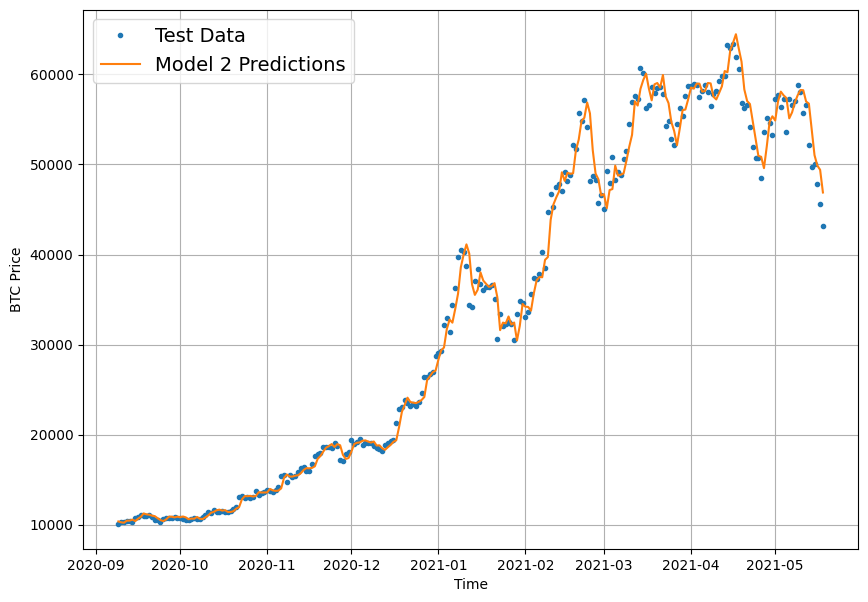

In [55]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for test_window offset when plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="Model 2 Predictions")

## Model 3: Dense (window = 30, horizon = 7)

(Same as model 1 but different Hypeparameters)

In [56]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [57]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(
    windows = full_windows,
    labels = full_labels
)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [58]:
# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct the model
model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(HORIZON)
], name="model_3_dense")

# Compile the model
model_3.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["mae", "mse"]
)

# Fit the model
model_3.fit(
    x = train_windows,
    y = train_labels,
    epochs=100,
    verbose=1,
    batch_size=128,
    validation_data=(test_windows, test_labels),
    callbacks=[create_model_checkpoint(model_name="model_3_name")]
)

Epoch 1/100
17/18 [===========================>..] - ETA: 0s - loss: 1473.4011 - mae: 1473.4011 - mse: 11415535.0000 

18/18 [==============================] - 2s 42ms/step - loss: 1464.3324 - mae: 1464.3324 - mse: 11306918.0000 - val_loss: 3043.8716 - val_mae: 3043.8716 - val_mse: 25586812.0000
Epoch 2/100
17/18 [===========================>..] - ETA: 0s - loss: 492.1464 - mae: 492.1464 - mse: 1064290.5000

18/18 [==============================] - 1s 34ms/step - loss: 491.5141 - mae: 491.5141 - mse: 1061277.8750 - val_loss: 2404.4143 - val_mae: 2404.4143 - val_mse: 16222392.0000
Epoch 3/100
18/18 [==============================] - ETA: 0s - loss: 389.6310 - mae: 389.6310 - mse: 712616.7500

18/18 [==============================] - 1s 34ms/step - loss: 389.6310 - mae: 389.6310 - mse: 712616.7500 - val_loss: 2161.3167 - val_mae: 2161.3167 - val_mse: 13295983.0000
Epoch 4/100
17/18 [===========================>..] - ETA: 0s - loss: 362.3416 - mae: 362.3416 - mse: 629182.0625

18/18 [==============================] - 1s 33ms/step - loss: 361.5011 - mae: 361.5011 - mse: 625558.5000 - val_loss: 1931.6613 - val_mae: 1931.6613 - val_mse: 11063205.0000
Epoch 5/100
18/18 [==============================] - 0s 5ms/step - loss: 341.6992 - mae: 341.6992 - mse: 567897.0625 - val_loss: 2038.8362 - val_mae: 2038.8362 - val_mse: 11949895.0000
Epoch 6/100
 1/18 [>.............................] - ETA: 0s - loss: 294.4469 - mae: 294.4469 - mse: 342608.9688

18/18 [==============================] - 1s 49ms/step - loss: 331.1257 - mae: 331.1257 - mse: 527815.0000 - val_loss: 1826.2822 - val_mae: 1826.2822 - val_mse: 9998906.0000
Epoch 7/100
 1/18 [>.............................] - ETA: 0s - loss: 292.8479 - mae: 292.8479 - mse: 418749.3125

18/18 [==============================] - 1s 34ms/step - loss: 317.4091 - mae: 317.4091 - mse: 496233.0625 - val_loss: 1717.5731 - val_mae: 1717.5731 - val_mse: 9055259.0000
Epoch 8/100
 1/18 [>.............................] - ETA: 0s - loss: 288.7444 - mae: 288.7444 - mse: 414953.8750

18/18 [==============================] - 1s 33ms/step - loss: 308.2654 - mae: 308.2654 - mse: 464639.4062 - val_loss: 1614.6959 - val_mae: 1614.6959 - val_mse: 8188544.0000
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 300.3022 - mae: 300.3022 - mse: 445124.1250 - val_loss: 1876.8425 - val_mae: 1876.8425 - val_mse: 10124351.0000
Epoch 10/100
 1/18 [>.............................] - ETA: 0s - loss: 274.7639 - mae: 274.7639 - mse: 283752.9375

18/18 [==============================] - 1s 33ms/step - loss: 308.7528 - mae: 308.7528 - mse: 451324.4062 - val_loss: 1605.0803 - val_mae: 1605.0803 - val_mse: 8013583.5000
Epoch 11/100
 1/18 [>.............................] - ETA: 0s - loss: 310.9653 - mae: 310.9653 - mse: 500400.9375

18/18 [==============================] - 1s 34ms/step - loss: 292.9434 - mae: 292.9434 - mse: 419534.0000 - val_loss: 1574.5145 - val_mae: 1574.5145 - val_mse: 7810154.0000
Epoch 12/100
18/18 [==============================] - 0s 6ms/step - loss: 280.5658 - mae: 280.5658 - mse: 400587.8125 - val_loss: 1677.4154 - val_mae: 1677.4153 - val_mse: 8472732.0000
Epoch 13/100
15/18 [========================>.....] - ETA: 0s - loss: 270.4484 - mae: 270.4484 - mse: 374662.3438

18/18 [==============================] - 1s 33ms/step - loss: 278.2544 - mae: 278.2544 - mse: 390488.3438 - val_loss: 1491.6681 - val_mae: 1491.6681 - val_mse: 7272721.0000
Epoch 14/100
 1/18 [>.............................] - ETA: 0s - loss: 257.2292 - mae: 257.2292 - mse: 283889.1875

18/18 [==============================] - 1s 33ms/step - loss: 274.5077 - mae: 274.5077 - mse: 382746.6875 - val_loss: 1467.1561 - val_mae: 1467.1561 - val_mse: 7044446.5000
Epoch 15/100
18/18 [==============================] - 0s 5ms/step - loss: 268.5543 - mae: 268.5543 - mse: 372305.1562 - val_loss: 1598.1138 - val_mae: 1598.1138 - val_mse: 7724571.5000
Epoch 16/100
18/18 [==============================] - 0s 6ms/step - loss: 267.3719 - mae: 267.3719 - mse: 365450.3438 - val_loss: 1523.1649 - val_mae: 1523.1649 - val_mse: 7296452.5000
Epoch 17/100
18/18 [==============================] - 0s 6ms/step - loss: 264.5217 - mae: 264.5217 - mse: 361687.7500 - val_loss: 1604.3656 - val_mae: 1604.3656 - val_mse: 7806280.0000
Epoch 18/100
18/18 [==============================] - 0s 6ms/step - loss: 264.6536 - mae: 264.6536 - mse: 358139.0000 - val_loss: 1692.8485 - val_mae: 1692.8485 - val_mse: 8251741.5000
Epoch 19/100
18/18 [==============================] - 0s 6ms/step - loss: 261.0754 - ma

18/18 [==============================] - 1s 33ms/step - loss: 255.5219 - mae: 255.5219 - mse: 335401.0000 - val_loss: 1392.3948 - val_mae: 1392.3948 - val_mse: 6456156.0000
Epoch 23/100
 1/18 [>.............................] - ETA: 0s - loss: 262.2422 - mae: 262.2422 - mse: 468672.5312

18/18 [==============================] - 1s 33ms/step - loss: 251.3299 - mae: 251.3299 - mse: 329775.6562 - val_loss: 1364.1704 - val_mae: 1364.1704 - val_mse: 6340468.5000
Epoch 24/100
18/18 [==============================] - 0s 9ms/step - loss: 260.4492 - mae: 260.4492 - mse: 344837.6250 - val_loss: 1377.3566 - val_mae: 1377.3566 - val_mse: 6445000.0000
Epoch 25/100
18/18 [==============================] - 0s 7ms/step - loss: 247.9906 - mae: 247.9906 - mse: 322014.5312 - val_loss: 1496.4131 - val_mae: 1496.4131 - val_mse: 7023775.5000
Epoch 26/100
18/18 [==============================] - 0s 8ms/step - loss: 244.6114 - mae: 244.6114 - mse: 315591.5312 - val_loss: 1447.9182 - val_mae: 1447.9182 - val_mse: 6667520.5000
Epoch 27/100
18/18 [==============================] - 0s 8ms/step - loss: 242.7205 - mae: 242.7205 - mse: 315638.7188 - val_loss: 1400.8206 - val_mae: 1400.8206 - val_mse: 6402011.0000
Epoch 28/100
18/18 [==============================] - 0s 8ms/step - loss: 242.4235 - ma

18/18 [==============================] - 1s 48ms/step - loss: 241.2628 - mae: 241.2628 - mse: 305209.6562 - val_loss: 1354.8074 - val_mae: 1354.8074 - val_mse: 6197734.5000
Epoch 32/100
13/18 [====================>.........] - ETA: 0s - loss: 241.2920 - mae: 241.2920 - mse: 317619.2500

18/18 [==============================] - 1s 46ms/step - loss: 240.4703 - mae: 240.4703 - mse: 308271.7500 - val_loss: 1316.6553 - val_mae: 1316.6553 - val_mse: 5974043.5000
Epoch 33/100
18/18 [==============================] - 0s 6ms/step - loss: 238.3178 - mae: 238.3178 - mse: 304050.3750 - val_loss: 1346.6659 - val_mae: 1346.6659 - val_mse: 6096354.5000
Epoch 34/100
18/18 [==============================] - 0s 5ms/step - loss: 236.4595 - mae: 236.4595 - mse: 301037.9062 - val_loss: 1351.7700 - val_mae: 1351.7700 - val_mse: 6131840.5000
Epoch 35/100
18/18 [==============================] - 0s 6ms/step - loss: 238.4694 - mae: 238.4694 - mse: 300604.8438 - val_loss: 1359.4033 - val_mae: 1359.4033 - val_mse: 6183837.0000
Epoch 36/100
18/18 [==============================] - 0s 5ms/step - loss: 241.5577 - mae: 241.5577 - mse: 312053.3438 - val_loss: 1416.1533 - val_mae: 1416.1533 - val_mse: 6730708.0000
Epoch 37/100
18/18 [==============================] - 0s 6ms/step - loss: 260.7354 - ma

18/18 [==============================] - 1s 33ms/step - loss: 231.7961 - mae: 231.7961 - mse: 286914.1562 - val_loss: 1295.6613 - val_mae: 1295.6613 - val_mse: 5756505.5000
Epoch 44/100
18/18 [==============================] - 0s 5ms/step - loss: 232.9998 - mae: 232.9998 - mse: 291171.1562 - val_loss: 1321.0636 - val_mae: 1321.0636 - val_mse: 5887237.5000
Epoch 45/100
18/18 [==============================] - 0s 5ms/step - loss: 229.4551 - mae: 229.4551 - mse: 287058.8125 - val_loss: 1449.4976 - val_mae: 1449.4976 - val_mse: 6532508.5000
Epoch 46/100
18/18 [==============================] - 0s 5ms/step - loss: 239.2905 - mae: 239.2905 - mse: 298576.1250 - val_loss: 1306.9091 - val_mae: 1306.9091 - val_mse: 5782017.0000
Epoch 47/100
18/18 [==============================] - 0s 5ms/step - loss: 234.0430 - mae: 234.0430 - mse: 292617.9375 - val_loss: 1354.2059 - val_mae: 1354.2059 - val_mse: 6005487.0000
Epoch 48/100
18/18 [==============================] - 0s 5ms/step - loss: 231.6133 - ma

18/18 [==============================] - 1s 33ms/step - loss: 234.1352 - mae: 234.1352 - mse: 290283.2188 - val_loss: 1278.1117 - val_mae: 1278.1117 - val_mse: 5624269.5000
Epoch 51/100
18/18 [==============================] - 0s 6ms/step - loss: 231.2285 - mae: 231.2285 - mse: 281762.1875 - val_loss: 1397.1444 - val_mae: 1397.1444 - val_mse: 6205097.0000
Epoch 52/100
18/18 [==============================] - 0s 5ms/step - loss: 228.1573 - mae: 228.1573 - mse: 279399.7812 - val_loss: 1322.3679 - val_mae: 1322.3679 - val_mse: 5854100.0000
Epoch 53/100
 1/18 [>.............................] - ETA: 0s - loss: 171.8521 - mae: 171.8521 - mse: 130691.2266

18/18 [==============================] - 1s 34ms/step - loss: 226.5769 - mae: 226.5769 - mse: 278354.6250 - val_loss: 1267.1354 - val_mae: 1267.1354 - val_mse: 5600478.0000
Epoch 54/100
18/18 [==============================] - 0s 6ms/step - loss: 229.1436 - mae: 229.1436 - mse: 280873.4062 - val_loss: 1304.2025 - val_mae: 1304.2025 - val_mse: 5719301.0000
Epoch 55/100
18/18 [==============================] - 0s 6ms/step - loss: 228.6895 - mae: 228.6895 - mse: 276199.2500 - val_loss: 1275.9839 - val_mae: 1275.9839 - val_mse: 5569283.0000
Epoch 56/100
18/18 [==============================] - 0s 6ms/step - loss: 229.3125 - mae: 229.3125 - mse: 281734.7500 - val_loss: 1320.2225 - val_mae: 1320.2225 - val_mse: 5792090.0000
Epoch 57/100
18/18 [==============================] - 0s 6ms/step - loss: 230.6994 - mae: 230.6994 - mse: 285120.5312 - val_loss: 1320.8213 - val_mae: 1320.8213 - val_mse: 5797080.5000
Epoch 58/100
18/18 [==============================] - 0s 6ms/step - loss: 229.7643 - ma

18/18 [==============================] - 1s 36ms/step - loss: 227.7643 - mae: 227.7643 - mse: 280381.6250 - val_loss: 1266.1321 - val_mae: 1266.1321 - val_mse: 5607362.5000
Epoch 60/100
 1/18 [>.............................] - ETA: 0s - loss: 216.9615 - mae: 216.9615 - mse: 230656.8125

18/18 [==============================] - 1s 31ms/step - loss: 229.0379 - mae: 229.0379 - mse: 281154.1562 - val_loss: 1259.5656 - val_mae: 1259.5656 - val_mse: 5511848.0000
Epoch 61/100
18/18 [==============================] - 0s 6ms/step - loss: 225.5298 - mae: 225.5298 - mse: 276379.9375 - val_loss: 1387.7291 - val_mae: 1387.7291 - val_mse: 6153373.5000
Epoch 62/100
18/18 [==============================] - 0s 6ms/step - loss: 229.6955 - mae: 229.6955 - mse: 279979.9062 - val_loss: 1302.1752 - val_mae: 1302.1752 - val_mse: 5893092.5000
Epoch 63/100
18/18 [==============================] - 0s 6ms/step - loss: 234.1987 - mae: 234.1987 - mse: 286452.0312 - val_loss: 1324.7135 - val_mae: 1324.7135 - val_mse: 5845628.0000
Epoch 64/100
18/18 [==============================] - 0s 6ms/step - loss: 229.7060 - mae: 229.7060 - mse: 276864.7188 - val_loss: 1288.5765 - val_mae: 1288.5765 - val_mse: 5604687.0000
Epoch 65/100
18/18 [==============================] - 0s 6ms/step - loss: 227.8972 - ma

18/18 [==============================] - 1s 49ms/step - loss: 230.7069 - mae: 230.7069 - mse: 278294.0312 - val_loss: 1249.1279 - val_mae: 1249.1279 - val_mse: 5393050.5000
Epoch 73/100
18/18 [==============================] - 0s 6ms/step - loss: 222.7986 - mae: 222.7986 - mse: 268810.4375 - val_loss: 1263.7339 - val_mae: 1263.7339 - val_mse: 5479787.0000
Epoch 74/100
18/18 [==============================] - 0s 5ms/step - loss: 222.8057 - mae: 222.8057 - mse: 272263.1875 - val_loss: 1314.7382 - val_mae: 1314.7382 - val_mse: 5701324.5000
Epoch 75/100
18/18 [==============================] - 0s 5ms/step - loss: 223.2775 - mae: 223.2775 - mse: 269524.7812 - val_loss: 1413.8356 - val_mae: 1413.8356 - val_mse: 6296988.0000
Epoch 76/100
18/18 [==============================] - 0s 5ms/step - loss: 228.0869 - mae: 228.0869 - mse: 275719.5312 - val_loss: 1255.5414 - val_mae: 1255.5414 - val_mse: 5441709.0000
Epoch 77/100
18/18 [==============================] - 0s 6ms/step - loss: 227.1596 - ma

18/18 [==============================] - 1s 34ms/step - loss: 224.4423 - mae: 224.4423 - mse: 271945.1875 - val_loss: 1248.9735 - val_mae: 1248.9735 - val_mse: 5402290.5000
Epoch 85/100
18/18 [==============================] - 0s 5ms/step - loss: 221.5814 - mae: 221.5814 - mse: 265472.4062 - val_loss: 1266.2109 - val_mae: 1266.2109 - val_mse: 5479719.5000
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 222.6352 - mae: 222.6352 - mse: 267219.8438 - val_loss: 1326.4348 - val_mae: 1326.4348 - val_mse: 5785953.0000
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 233.2249 - mae: 233.2249 - mse: 277883.5938 - val_loss: 1335.9847 - val_mae: 1335.9847 - val_mse: 5813428.5000
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 228.5084 - mae: 228.5084 - mse: 272695.9688 - val_loss: 1524.9386 - val_mae: 1524.9386 - val_mse: 6917902.5000
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 229.4793 - ma

18/18 [==============================] - 1s 53ms/step - loss: 229.2685 - mae: 229.2685 - mse: 271899.6562 - val_loss: 1248.1947 - val_mae: 1248.1947 - val_mse: 5378425.5000
Epoch 92/100
18/18 [==============================] - 0s 10ms/step - loss: 223.5737 - mae: 223.5737 - mse: 268740.2188 - val_loss: 1258.0873 - val_mae: 1258.0873 - val_mse: 5455027.5000
Epoch 93/100
18/18 [==============================] - 0s 8ms/step - loss: 223.7175 - mae: 223.7175 - mse: 269268.2500 - val_loss: 1318.6486 - val_mae: 1318.6486 - val_mse: 5609593.0000
Epoch 94/100
18/18 [==============================] - 0s 8ms/step - loss: 222.3640 - mae: 222.3640 - mse: 264736.9375 - val_loss: 1352.2372 - val_mae: 1352.2372 - val_mse: 5852892.0000
Epoch 95/100
18/18 [==============================] - 0s 8ms/step - loss: 224.4752 - mae: 224.4752 - mse: 267301.3438 - val_loss: 1293.9308 - val_mae: 1293.9308 - val_mse: 5572398.5000
Epoch 96/100
18/18 [==============================] - 0s 9ms/step - loss: 225.3954 - m

In [59]:
# Evaluate model 2 on test data
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 1324.2466 - mae: 1324.2466 - mse: 5678865.0000


[1324.24658203125, 1324.24658203125, 5678865.0]

In [60]:
# Load in the best performing model
model_3 = tf.keras.models.load_model("/content/model_experiments/model_3_name")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1248.1947 - mae: 1248.1947 - mse: 5378425.5000


[1248.1947021484375, 1248.1947021484375, 5378425.5]

In [61]:
# Get the forecasting predictions for model 3
model_3_preds = make_preds(model_3,
                           input_data=test_windows)

18/18 [==============================] - 0s 2ms/step


In [62]:
# Evaluate results for model 3 predictions
model_3_results = evaluate_preds(
    y_true=tf.squeeze(test_labels),
    y_pred=model_3_preds
)
model_3_results

{'mae': 1248.1947002737727,
 'mse': 5378425.64705137,
 'rmse': 1428.4629004013866,
 'mape': 5.513557466288454,
 'mase': 2.221092506212386}

In [63]:
model_1_results, model_2_results

({'mae': 566.9008258970482,
  'mse': 1167956.1493508038,
  'rmse': 1080.7201993813217,
  'mape': 2.534413413599998,
  'mase': 0.9958876299792072},
 {'mae': 625.353951949332,
  'mse': 1309027.9861979543,
  'rmse': 1144.1276092280766,
  'mape': 2.8747660704453315,
  'mase': 1.0931247529052655})

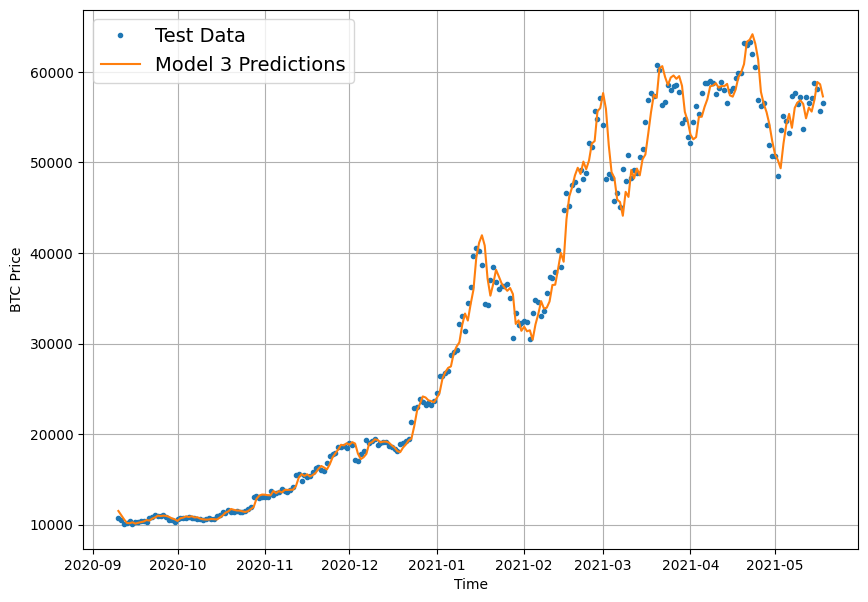

In [64]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for test_window offset when plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.reduce_mean(model_3_preds, axis=1), start=offset, format="-", label="Model 3 Predictions")

## Comparing the models build so far to see how well they performed

<Axes: >

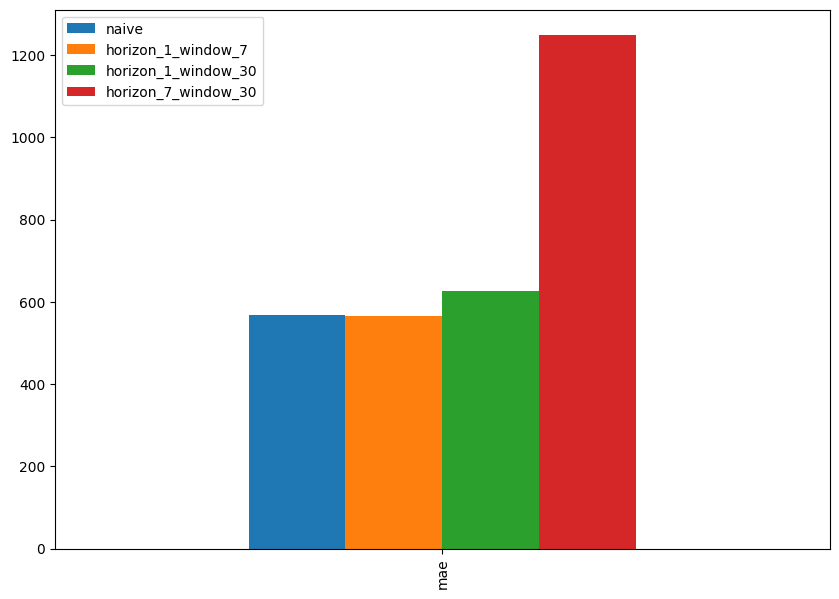

In [65]:
pd.DataFrame({"naive": naive_results["mae"],
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30": model_2_results["mae"],
              "horizon_7_window_30": model_3_results["mae"]
              }, index=["mae"]).plot(figsize=(10, 7), kind="bar")

Note: You might be wondering, why are the naïve results so good? One of the reasons could be due the presence of autocorrelation in the data. If a time series has autocorrelation it means the value at t+1 (the next timestep) is typically close to the value at t (the current timestep). In other words, today's value is probably pretty close to yesterday's value. Of course, this isn't always the case but when it is (stock market prices often seem autocorrelated but often fluctuate randomly), a naïve model will often get fairly good results.

## Model 4: Conv1D

In [66]:
HORIZON = 1 # predict next day of Bitcoin prices
WINDOW_SIZE = 7 # use previous week worth data

In [67]:
# Create windowed data
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [68]:
# Create train/test sets
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

We need an input shape of: `(batch_size, timesteps, input_dim)`...

However the data isn't in that shape yet

In [69]:
# Check data input shape
train_windows[0].shape # returns (WINDOWS_SIZE, )

(7,)

In [70]:
# Before I pass the data to the Conv1D layer, I will need to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])>

In [71]:
expand_dims_layer = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an exate dimension for input dim

In [72]:
# Test the lambda layer
print(f"Original shape: {x.shape}") # (WINDOW_SIZE, )
print(f"Expanded shape: {expand_dims_layer(x).shape}") # output =  (WINDOW_SIZE, HORIZON)
print(f"Original values with expanded shape: \n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape: 
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [73]:
# Set random seed
tf.random.set_seed(42)

# Create Conv1D model
model_4 = tf.keras.Sequential([
    expand_dims_layer,
    tf.keras.layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
    tf.keras.layers.Dense(HORIZON, activation="linear", name="output_layer")
], name="model_4_Conv1D")

# Compile the model
model_4.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["mae", "mse"]
)

# Fit the model
model_4.fit(
    train_windows,
    train_labels,
    batch_size=128,
    epochs=100,
    validation_data=(test_windows, test_labels),
    callbacks=[create_model_checkpoint(model_name=model_4.name)]
)

Epoch 1/100
15/18 [========================>.....] - ETA: 0s - loss: 1650.8624 - mae: 1650.8624 - mse: 7675322.5000   

18/18 [==============================] - 7s 59ms/step - loss: 1492.3881 - mae: 1492.3881 - mse: 6736118.0000 - val_loss: 1371.3243 - val_mae: 1371.3243 - val_mse: 5192161.0000
Epoch 2/100
18/18 [==============================] - 0s 6ms/step - loss: 301.5170 - mae: 301.5170 - mse: 380104.6875 - val_loss: 1493.6443 - val_mae: 1493.6443 - val_mse: 5819495.5000
Epoch 3/100
14/18 [======================>.......] - ETA: 0s - loss: 229.0747 - mae: 229.0747 - mse: 252164.7656

18/18 [==============================] - 1s 46ms/step - loss: 226.0030 - mae: 226.0030 - mse: 249502.9062 - val_loss: 1116.8075 - val_mae: 1116.8075 - val_mse: 4138367.0000
Epoch 4/100
13/18 [====================>.........] - ETA: 0s - loss: 208.6125 - mae: 208.6125 - mse: 228017.9844

18/18 [==============================] - 1s 62ms/step - loss: 201.6260 - mae: 201.6260 - mse: 210246.8594 - val_loss: 1110.7212 - val_mae: 1110.7212 - val_mse: 4111288.2500
Epoch 5/100
11/18 [=================>............] - ETA: 0s - loss: 208.3827 - mae: 208.3827 - mse: 226653.3594

18/18 [==============================] - 1s 68ms/step - loss: 197.8963 - mae: 197.8963 - mse: 203791.2188 - val_loss: 1103.9260 - val_mae: 1103.9260 - val_mse: 3992748.7500
Epoch 6/100
11/18 [=================>............] - ETA: 0s - loss: 194.7012 - mae: 194.7012 - mse: 189463.4375

18/18 [==============================] - 1s 57ms/step - loss: 197.6383 - mae: 197.6383 - mse: 202563.8281 - val_loss: 1091.2610 - val_mae: 1091.2610 - val_mse: 3987885.0000
Epoch 7/100
16/18 [=========================>....] - ETA: 0s - loss: 202.6153 - mae: 202.6153 - mse: 213079.2188

18/18 [==============================] - 1s 48ms/step - loss: 197.3590 - mae: 197.3590 - mse: 202437.7969 - val_loss: 1065.6027 - val_mae: 1065.6027 - val_mse: 3791063.2500
Epoch 8/100
14/18 [======================>.......] - ETA: 0s - loss: 188.6618 - mae: 188.6618 - mse: 186205.7812

18/18 [==============================] - 1s 66ms/step - loss: 189.8537 - mae: 189.8537 - mse: 190872.6406 - val_loss: 1061.3082 - val_mae: 1061.3082 - val_mse: 3699509.7500
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 187.7733 - mae: 187.7733 - mse: 186690.2344 - val_loss: 1070.8779 - val_mae: 1070.8779 - val_mse: 3660225.7500
Epoch 10/100
16/18 [=========================>....] - ETA: 0s - loss: 182.1683 - mae: 182.1683 - mse: 178868.6094

18/18 [==============================] - 1s 49ms/step - loss: 185.4590 - mae: 185.4590 - mse: 182381.0000 - val_loss: 1044.6703 - val_mae: 1044.6703 - val_mse: 3535948.7500
Epoch 11/100
16/18 [=========================>....] - ETA: 0s - loss: 182.3435 - mae: 182.3435 - mse: 177910.8125

18/18 [==============================] - 1s 46ms/step - loss: 183.8126 - mae: 183.8126 - mse: 178243.2031 - val_loss: 1013.0259 - val_mae: 1013.0259 - val_mse: 3429760.0000
Epoch 12/100
18/18 [==============================] - 0s 6ms/step - loss: 183.2766 - mae: 183.2766 - mse: 175555.9844 - val_loss: 1020.4917 - val_mae: 1020.4917 - val_mse: 3356488.5000
Epoch 13/100
18/18 [==============================] - 0s 6ms/step - loss: 178.3618 - mae: 178.3618 - mse: 168944.8125 - val_loss: 1030.8002 - val_mae: 1030.8002 - val_mse: 3331016.7500
Epoch 14/100
16/18 [=========================>....] - ETA: 0s - loss: 172.7646 - mae: 172.7646 - mse: 158113.8594

18/18 [==============================] - 1s 47ms/step - loss: 175.6988 - mae: 175.6988 - mse: 164537.3594 - val_loss: 1007.9840 - val_mae: 1007.9840 - val_mse: 3215862.2500
Epoch 15/100
17/18 [===========================>..] - ETA: 0s - loss: 175.7132 - mae: 175.7132 - mse: 164945.8281

18/18 [==============================] - 1s 46ms/step - loss: 175.5650 - mae: 175.5650 - mse: 164726.9219 - val_loss: 963.4123 - val_mae: 963.4123 - val_mse: 3063371.7500
Epoch 16/100
16/18 [=========================>....] - ETA: 0s - loss: 168.2615 - mae: 168.2615 - mse: 149867.4531

18/18 [==============================] - 1s 45ms/step - loss: 170.5039 - mae: 170.5039 - mse: 154837.5938 - val_loss: 955.6787 - val_mae: 955.6787 - val_mse: 2982932.2500
Epoch 17/100
18/18 [==============================] - 0s 7ms/step - loss: 167.9961 - mae: 167.9961 - mse: 151878.8125 - val_loss: 1007.4888 - val_mae: 1007.4888 - val_mse: 3061952.0000
Epoch 18/100
17/18 [===========================>..] - ETA: 0s - loss: 167.8685 - mae: 167.8685 - mse: 151478.0469

18/18 [==============================] - 1s 45ms/step - loss: 166.5536 - mae: 166.5536 - mse: 149203.3594 - val_loss: 944.8006 - val_mae: 944.8006 - val_mse: 2831094.5000
Epoch 19/100
18/18 [==============================] - 0s 7ms/step - loss: 162.7322 - mae: 162.7322 - mse: 142687.7031 - val_loss: 947.0897 - val_mae: 947.0897 - val_mse: 2783568.7500
Epoch 20/100
15/18 [========================>.....] - ETA: 0s - loss: 160.9102 - mae: 160.9102 - mse: 143512.5781

18/18 [==============================] - 1s 46ms/step - loss: 159.7810 - mae: 159.7810 - mse: 139469.9062 - val_loss: 895.1059 - val_mae: 895.1059 - val_mse: 2707953.0000
Epoch 21/100
16/18 [=========================>....] - ETA: 0s - loss: 156.9628 - mae: 156.9628 - mse: 130852.8984

18/18 [==============================] - 1s 46ms/step - loss: 157.8172 - mae: 157.8172 - mse: 136466.9844 - val_loss: 892.2739 - val_mae: 892.2739 - val_mse: 2549132.5000
Epoch 22/100
16/18 [=========================>....] - ETA: 0s - loss: 156.9693 - mae: 156.9693 - mse: 135644.3594

18/18 [==============================] - 1s 57ms/step - loss: 154.3274 - mae: 154.3274 - mse: 130402.1016 - val_loss: 877.5026 - val_mae: 877.5026 - val_mse: 2466438.0000
Epoch 23/100
10/18 [===============>..............] - ETA: 0s - loss: 147.5906 - mae: 147.5906 - mse: 106441.7109

18/18 [==============================] - 1s 69ms/step - loss: 151.4546 - mae: 151.4546 - mse: 126168.5781 - val_loss: 862.7078 - val_mae: 862.7078 - val_mse: 2387877.5000
Epoch 24/100
18/18 [==============================] - 0s 9ms/step - loss: 151.4897 - mae: 151.4897 - mse: 124636.9219 - val_loss: 884.3105 - val_mae: 884.3105 - val_mse: 2396900.2500
Epoch 25/100
11/18 [=================>............] - ETA: 0s - loss: 154.4775 - mae: 154.4775 - mse: 131431.0938

18/18 [==============================] - 1s 77ms/step - loss: 147.1792 - mae: 147.1792 - mse: 119660.3047 - val_loss: 812.7220 - val_mae: 812.7220 - val_mse: 2202294.5000
Epoch 26/100
16/18 [=========================>....] - ETA: 0s - loss: 146.6394 - mae: 146.6394 - mse: 112497.2422

18/18 [==============================] - 1s 49ms/step - loss: 145.2956 - mae: 145.2956 - mse: 115955.2188 - val_loss: 794.2086 - val_mae: 794.2086 - val_mse: 2152285.5000
Epoch 27/100
18/18 [==============================] - 0s 7ms/step - loss: 143.0699 - mae: 143.0699 - mse: 114641.4844 - val_loss: 796.4665 - val_mae: 796.4665 - val_mse: 2076215.7500
Epoch 28/100
16/18 [=========================>....] - ETA: 0s - loss: 139.1487 - mae: 139.1487 - mse: 109560.5547

18/18 [==============================] - 1s 46ms/step - loss: 140.1631 - mae: 140.1631 - mse: 109421.4219 - val_loss: 769.3984 - val_mae: 769.3984 - val_mse: 2018331.3750
Epoch 29/100
15/18 [========================>.....] - ETA: 0s - loss: 142.8951 - mae: 142.8951 - mse: 111470.6172

18/18 [==============================] - 1s 47ms/step - loss: 141.4226 - mae: 141.4226 - mse: 109379.7422 - val_loss: 766.7363 - val_mae: 766.7363 - val_mse: 2000670.1250
Epoch 30/100
18/18 [==============================] - 0s 6ms/step - loss: 141.1366 - mae: 141.1366 - mse: 105638.0469 - val_loss: 1005.8088 - val_mae: 1005.8088 - val_mse: 2686558.5000
Epoch 31/100
16/18 [=========================>....] - ETA: 0s - loss: 146.6467 - mae: 146.6467 - mse: 117307.4766

18/18 [==============================] - 1s 48ms/step - loss: 147.1015 - mae: 147.1015 - mse: 116091.6797 - val_loss: 750.9802 - val_mae: 750.9802 - val_mse: 1856239.2500
Epoch 32/100
16/18 [=========================>....] - ETA: 0s - loss: 132.7026 - mae: 132.7026 - mse: 95499.5781

18/18 [==============================] - 1s 47ms/step - loss: 135.1473 - mae: 135.1473 - mse: 100912.1484 - val_loss: 731.4993 - val_mae: 731.4993 - val_mse: 1813557.0000
Epoch 33/100
15/18 [========================>.....] - ETA: 0s - loss: 134.3082 - mae: 134.3082 - mse: 100678.6562

18/18 [==============================] - 1s 47ms/step - loss: 133.9309 - mae: 133.9309 - mse: 98041.3281 - val_loss: 723.7542 - val_mae: 723.7542 - val_mse: 1767568.7500
Epoch 34/100
18/18 [==============================] - 0s 7ms/step - loss: 130.8132 - mae: 130.8132 - mse: 97444.7109 - val_loss: 744.2671 - val_mae: 744.2671 - val_mse: 1777905.5000
Epoch 35/100
18/18 [==============================] - 0s 7ms/step - loss: 130.5311 - mae: 130.5311 - mse: 96366.6172 - val_loss: 725.2684 - val_mae: 725.2684 - val_mse: 1715771.1250
Epoch 36/100
18/18 [==============================] - 0s 6ms/step - loss: 132.5231 - mae: 132.5231 - mse: 97051.7734 - val_loss: 736.1837 - val_mae: 736.1837 - val_mse: 1727050.5000
Epoch 37/100
16/18 [=========================>....] - ETA: 0s - loss: 127.9954 - mae: 127.9954 - mse: 87994.0156 

18/18 [==============================] - 1s 46ms/step - loss: 128.4080 - mae: 128.4080 - mse: 91291.7734 - val_loss: 701.5728 - val_mae: 701.5728 - val_mse: 1632718.1250
Epoch 38/100
16/18 [=========================>....] - ETA: 0s - loss: 125.3939 - mae: 125.3939 - mse: 88782.1172

18/18 [==============================] - 1s 47ms/step - loss: 125.2198 - mae: 125.2198 - mse: 90469.7656 - val_loss: 684.7911 - val_mae: 684.7911 - val_mse: 1588020.7500
Epoch 39/100
18/18 [==============================] - 0s 6ms/step - loss: 124.9308 - mae: 124.9308 - mse: 89557.9297 - val_loss: 721.4460 - val_mae: 721.4460 - val_mse: 1746029.1250
Epoch 40/100
15/18 [========================>.....] - ETA: 0s - loss: 124.9189 - mae: 124.9189 - mse: 90404.5938 

18/18 [==============================] - 1s 46ms/step - loss: 124.7899 - mae: 124.7899 - mse: 87484.9609 - val_loss: 671.6594 - val_mae: 671.6594 - val_mse: 1533649.1250
Epoch 41/100
16/18 [=========================>....] - ETA: 0s - loss: 125.7906 - mae: 125.7906 - mse: 90737.9375

18/18 [==============================] - 1s 47ms/step - loss: 123.6270 - mae: 123.6270 - mse: 87604.2734 - val_loss: 665.3959 - val_mae: 665.3959 - val_mse: 1510669.3750
Epoch 42/100
16/18 [=========================>....] - ETA: 0s - loss: 123.4330 - mae: 123.4330 - mse: 88660.4844

18/18 [==============================] - 1s 82ms/step - loss: 124.1289 - mae: 124.1289 - mse: 88476.0469 - val_loss: 659.4114 - val_mae: 659.4114 - val_mse: 1490295.7500
Epoch 43/100
12/18 [===================>..........] - ETA: 0s - loss: 116.1600 - mae: 116.1600 - mse: 71646.9531

18/18 [==============================] - 1s 70ms/step - loss: 120.6038 - mae: 120.6038 - mse: 84008.9766 - val_loss: 656.5961 - val_mae: 656.5961 - val_mse: 1498285.0000
Epoch 44/100
10/18 [===============>..............] - ETA: 0s - loss: 115.3853 - mae: 115.3853 - mse: 75430.7031

18/18 [==============================] - 1s 48ms/step - loss: 120.4734 - mae: 120.4734 - mse: 84148.2031 - val_loss: 656.2549 - val_mae: 656.2549 - val_mse: 1498313.1250
Epoch 45/100
16/18 [=========================>....] - ETA: 0s - loss: 120.6040 - mae: 120.6040 - mse: 83252.8672

18/18 [==============================] - 1s 45ms/step - loss: 121.9808 - mae: 121.9808 - mse: 86478.2969 - val_loss: 646.0948 - val_mae: 646.0948 - val_mse: 1435072.7500
Epoch 46/100
18/18 [==============================] - 0s 6ms/step - loss: 119.0310 - mae: 119.0310 - mse: 81923.8047 - val_loss: 663.2501 - val_mae: 663.2501 - val_mse: 1459100.5000
Epoch 47/100
18/18 [==============================] - 0s 6ms/step - loss: 122.8365 - mae: 122.8365 - mse: 85867.0781 - val_loss: 705.8983 - val_mae: 705.8983 - val_mse: 1558191.0000
Epoch 48/100
18/18 [==============================] - 0s 7ms/step - loss: 118.9512 - mae: 118.9512 - mse: 81415.6562 - val_loss: 690.1548 - val_mae: 690.1548 - val_mse: 1514129.7500
Epoch 49/100
12/18 [===================>..........] - ETA: 0s - loss: 125.3562 - mae: 125.3562 - mse: 95973.6953 

18/18 [==============================] - 1s 46ms/step - loss: 119.1582 - mae: 119.1582 - mse: 81899.7734 - val_loss: 643.0195 - val_mae: 643.0195 - val_mse: 1398270.8750
Epoch 50/100
15/18 [========================>.....] - ETA: 0s - loss: 116.9168 - mae: 116.9168 - mse: 79220.4141 

18/18 [==============================] - 1s 44ms/step - loss: 118.8593 - mae: 118.8593 - mse: 81459.0703 - val_loss: 638.7128 - val_mae: 638.7128 - val_mse: 1385042.5000
Epoch 51/100
18/18 [==============================] - 0s 7ms/step - loss: 116.6047 - mae: 116.6047 - mse: 78846.8672 - val_loss: 646.8089 - val_mae: 646.8089 - val_mse: 1399877.7500
Epoch 52/100
17/18 [===========================>..] - ETA: 0s - loss: 117.3053 - mae: 117.3053 - mse: 82218.6797

18/18 [==============================] - 1s 45ms/step - loss: 116.8722 - mae: 116.8722 - mse: 81308.5078 - val_loss: 633.7034 - val_mae: 633.7034 - val_mse: 1402632.5000
Epoch 53/100
16/18 [=========================>....] - ETA: 0s - loss: 119.0469 - mae: 119.0469 - mse: 82173.1641

18/18 [==============================] - 1s 46ms/step - loss: 118.2493 - mae: 118.2493 - mse: 80734.9219 - val_loss: 631.5332 - val_mae: 631.5332 - val_mse: 1358452.5000
Epoch 54/100
18/18 [==============================] - 0s 7ms/step - loss: 116.7123 - mae: 116.7123 - mse: 79637.5078 - val_loss: 661.2674 - val_mae: 661.2674 - val_mse: 1425545.2500
Epoch 55/100
16/18 [=========================>....] - ETA: 0s - loss: 122.3202 - mae: 122.3202 - mse: 85034.1797 

18/18 [==============================] - 1s 46ms/step - loss: 119.3606 - mae: 119.3606 - mse: 81554.4375 - val_loss: 624.7560 - val_mae: 624.7560 - val_mse: 1368678.6250
Epoch 56/100
18/18 [==============================] - 0s 6ms/step - loss: 119.7026 - mae: 119.7026 - mse: 82555.5781 - val_loss: 762.0597 - val_mae: 762.0597 - val_mse: 1789334.5000
Epoch 57/100
15/18 [========================>.....] - ETA: 0s - loss: 140.4562 - mae: 140.4562 - mse: 101886.1719

18/18 [==============================] - 1s 46ms/step - loss: 136.4205 - mae: 136.4205 - mse: 94947.0703 - val_loss: 611.1381 - val_mae: 611.1381 - val_mse: 1324828.3750
Epoch 58/100
18/18 [==============================] - 0s 7ms/step - loss: 117.9585 - mae: 117.9585 - mse: 81205.3516 - val_loss: 628.1447 - val_mae: 628.1447 - val_mse: 1371670.5000
Epoch 59/100
16/18 [=========================>....] - ETA: 0s - loss: 113.5616 - mae: 113.5616 - mse: 76684.8516

18/18 [==============================] - 1s 46ms/step - loss: 113.6503 - mae: 113.6503 - mse: 77108.4062 - val_loss: 608.5562 - val_mae: 608.5562 - val_mse: 1315289.8750
Epoch 60/100
18/18 [==============================] - 0s 6ms/step - loss: 113.8391 - mae: 113.8391 - mse: 77896.9219 - val_loss: 624.0920 - val_mae: 624.0920 - val_mse: 1327858.3750
Epoch 61/100
18/18 [==============================] - 0s 6ms/step - loss: 113.9096 - mae: 113.9096 - mse: 78303.5000 - val_loss: 615.5217 - val_mae: 615.5217 - val_mse: 1306830.7500
Epoch 62/100
16/18 [=========================>....] - ETA: 0s - loss: 114.6494 - mae: 114.6494 - mse: 77519.8047

18/18 [==============================] - 1s 66ms/step - loss: 112.7116 - mae: 112.7116 - mse: 75388.4922 - val_loss: 604.5935 - val_mae: 604.5935 - val_mse: 1300317.8750
Epoch 63/100
17/18 [===========================>..] - ETA: 0s - loss: 115.3221 - mae: 115.3221 - mse: 78844.1484

18/18 [==============================] - 1s 47ms/step - loss: 115.0799 - mae: 115.0799 - mse: 78473.4297 - val_loss: 604.3221 - val_mae: 604.3221 - val_mse: 1282486.3750
Epoch 64/100
18/18 [==============================] - 0s 11ms/step - loss: 113.6258 - mae: 113.6258 - mse: 76948.4219 - val_loss: 668.0714 - val_mae: 668.0714 - val_mse: 1425571.2500
Epoch 65/100
18/18 [==============================] - 0s 9ms/step - loss: 117.7058 - mae: 117.7058 - mse: 80190.5469 - val_loss: 613.8839 - val_mae: 613.8839 - val_mse: 1296536.7500
Epoch 66/100
11/18 [=================>............] - ETA: 0s - loss: 109.1068 - mae: 109.1068 - mse: 64140.4023

18/18 [==============================] - 1s 66ms/step - loss: 113.1134 - mae: 113.1134 - mse: 76067.2734 - val_loss: 601.4467 - val_mae: 601.4467 - val_mse: 1286724.5000
Epoch 67/100
18/18 [==============================] - 0s 11ms/step - loss: 113.5027 - mae: 113.5027 - mse: 75940.4609 - val_loss: 670.4598 - val_mae: 670.4598 - val_mse: 1461277.5000
Epoch 68/100
18/18 [==============================] - 0s 11ms/step - loss: 122.2784 - mae: 122.2784 - mse: 78204.0469 - val_loss: 706.0902 - val_mae: 706.0902 - val_mse: 1567145.5000
Epoch 69/100
18/18 [==============================] - 0s 12ms/step - loss: 126.3153 - mae: 126.3153 - mse: 85606.6016 - val_loss: 640.1932 - val_mae: 640.1932 - val_mse: 1379024.5000
Epoch 70/100
11/18 [=================>............] - ETA: 0s - loss: 118.9497 - mae: 118.9497 - mse: 81960.5547 

18/18 [==============================] - 1s 50ms/step - loss: 118.4461 - mae: 118.4461 - mse: 80094.2031 - val_loss: 592.7625 - val_mae: 592.7625 - val_mse: 1258207.5000
Epoch 71/100
18/18 [==============================] - 0s 7ms/step - loss: 113.3635 - mae: 113.3635 - mse: 75204.3594 - val_loss: 617.5001 - val_mae: 617.5001 - val_mse: 1296737.2500
Epoch 72/100
18/18 [==============================] - 0s 6ms/step - loss: 112.4919 - mae: 112.4919 - mse: 75839.3672 - val_loss: 596.4528 - val_mae: 596.4528 - val_mse: 1254283.1250
Epoch 73/100
18/18 [==============================] - 0s 6ms/step - loss: 112.9516 - mae: 112.9516 - mse: 75680.5938 - val_loss: 604.1578 - val_mae: 604.1578 - val_mse: 1286593.1250
Epoch 74/100
18/18 [==============================] - 0s 6ms/step - loss: 112.2403 - mae: 112.2403 - mse: 75761.7188 - val_loss: 597.9069 - val_mae: 597.9069 - val_mse: 1269503.5000
Epoch 75/100
16/18 [=========================>....] - ETA: 0s - loss: 110.2248 - mae: 110.2248 - mse: 

18/18 [==============================] - 1s 45ms/step - loss: 111.6345 - mae: 111.6345 - mse: 75057.4297 - val_loss: 590.5965 - val_mae: 590.5965 - val_mse: 1242141.7500
Epoch 76/100
15/18 [========================>.....] - ETA: 0s - loss: 111.5858 - mae: 111.5858 - mse: 74778.4297

18/18 [==============================] - 1s 44ms/step - loss: 111.3919 - mae: 111.3919 - mse: 74910.2266 - val_loss: 587.0367 - val_mae: 587.0367 - val_mse: 1240389.7500
Epoch 77/100
16/18 [=========================>....] - ETA: 0s - loss: 114.3152 - mae: 114.3152 - mse: 76544.1484

18/18 [==============================] - 1s 46ms/step - loss: 112.3534 - mae: 112.3534 - mse: 73539.9062 - val_loss: 586.0109 - val_mae: 586.0109 - val_mse: 1234777.5000
Epoch 78/100
16/18 [=========================>....] - ETA: 0s - loss: 112.1337 - mae: 112.1337 - mse: 74727.9375

18/18 [==============================] - 1s 47ms/step - loss: 111.4610 - mae: 111.4610 - mse: 73633.5000 - val_loss: 585.9412 - val_mae: 585.9412 - val_mse: 1232936.2500
Epoch 79/100
18/18 [==============================] - 0s 6ms/step - loss: 111.8805 - mae: 111.8805 - mse: 76211.8750 - val_loss: 601.9368 - val_mae: 601.9368 - val_mse: 1274990.0000
Epoch 80/100
17/18 [===========================>..] - ETA: 0s - loss: 111.4731 - mae: 111.4731 - mse: 75040.2266 

18/18 [==============================] - 1s 45ms/step - loss: 111.0100 - mae: 111.0100 - mse: 74434.6172 - val_loss: 585.4158 - val_mae: 585.4158 - val_mse: 1230736.7500
Epoch 81/100
17/18 [===========================>..] - ETA: 0s - loss: 110.1137 - mae: 110.1137 - mse: 72955.0469

18/18 [==============================] - 1s 45ms/step - loss: 110.5405 - mae: 110.5405 - mse: 73282.4062 - val_loss: 584.7482 - val_mae: 584.7482 - val_mse: 1229493.8750
Epoch 82/100
18/18 [==============================] - 0s 6ms/step - loss: 116.0521 - mae: 116.0521 - mse: 78586.8984 - val_loss: 592.6321 - val_mae: 592.6321 - val_mse: 1249692.8750
Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 111.7980 - mae: 111.7980 - mse: 74195.2500 - val_loss: 622.9223 - val_mae: 622.9223 - val_mse: 1319264.2500
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 112.0883 - mae: 112.0883 - mse: 73378.0391 - val_loss: 586.4512 - val_mae: 586.4512 - val_mse: 1236653.3750
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 109.4995 - mae: 109.4995 - mse: 73843.5938 - val_loss: 592.5235 - val_mae: 592.5235 - val_mse: 1231639.6250
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 109.7971 - mae: 109.7971 - m

18/18 [==============================] - 1s 47ms/step - loss: 110.5757 - mae: 110.5757 - mse: 73103.9297 - val_loss: 583.7806 - val_mae: 583.7806 - val_mse: 1226499.7500
Epoch 89/100
16/18 [=========================>....] - ETA: 0s - loss: 107.5200 - mae: 107.5200 - mse: 65368.5156

18/18 [==============================] - 1s 66ms/step - loss: 112.2268 - mae: 112.2268 - mse: 72453.5234 - val_loss: 580.6165 - val_mae: 580.6165 - val_mse: 1217788.3750
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 109.7937 - mae: 109.7937 - mse: 71228.2188 - val_loss: 700.1304 - val_mae: 700.1304 - val_mse: 1475980.3750
Epoch 91/100
15/18 [========================>.....] - ETA: 0s - loss: 113.7333 - mae: 113.7333 - mse: 77243.2578

18/18 [==============================] - 1s 50ms/step - loss: 112.1075 - mae: 112.1075 - mse: 75129.2188 - val_loss: 579.3941 - val_mae: 579.3941 - val_mse: 1213835.0000
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 110.4182 - mae: 110.4182 - mse: 74300.4297 - val_loss: 582.0599 - val_mae: 582.0599 - val_mse: 1209648.0000
Epoch 93/100
18/18 [==============================] - 0s 7ms/step - loss: 112.5735 - mae: 112.5735 - mse: 74717.8828 - val_loss: 642.4302 - val_mae: 642.4302 - val_mse: 1356614.8750
Epoch 94/100
18/18 [==============================] - 0s 11ms/step - loss: 111.5892 - mae: 111.5892 - mse: 74727.3984 - val_loss: 582.7094 - val_mae: 582.7094 - val_mse: 1220642.3750
Epoch 95/100
18/18 [==============================] - 0s 10ms/step - loss: 110.4444 - mae: 110.4444 - mse: 74272.8203 - val_loss: 603.0728 - val_mae: 603.0728 - val_mse: 1243358.0000
Epoch 96/100
11/18 [=================>............] - ETA: 0s - loss: 107.8501 - mae: 107.8501 - mse

18/18 [==============================] - 1s 65ms/step - loss: 109.3940 - mae: 109.3940 - mse: 72715.8828 - val_loss: 579.3144 - val_mae: 579.3144 - val_mse: 1214098.2500
Epoch 97/100
18/18 [==============================] - 0s 9ms/step - loss: 109.8201 - mae: 109.8201 - mse: 72513.0156 - val_loss: 600.7261 - val_mae: 600.7261 - val_mse: 1256598.7500
Epoch 98/100
11/18 [=================>............] - ETA: 0s - loss: 109.1212 - mae: 109.1212 - mse: 71882.3516

18/18 [==============================] - 1s 60ms/step - loss: 108.9985 - mae: 108.9985 - mse: 72077.3359 - val_loss: 577.9158 - val_mae: 577.9158 - val_mse: 1208508.6250
Epoch 99/100
17/18 [===========================>..] - ETA: 0s - loss: 109.1677 - mae: 109.1677 - mse: 73017.2188 

18/18 [==============================] - 1s 46ms/step - loss: 108.6954 - mae: 108.6954 - mse: 72289.6797 - val_loss: 576.4107 - val_mae: 576.4107 - val_mse: 1193642.8750
Epoch 100/100
18/18 [==============================] - 0s 7ms/step - loss: 111.5145 - mae: 111.5145 - mse: 72355.5000 - val_loss: 652.5453 - val_mae: 652.5453 - val_mse: 1348462.0000


In [74]:
model_4.summary()

Model: "model_4_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 output_layer (Dense)        (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [75]:
# Evaluate model
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 652.5453 - mae: 652.5453 - mse: 1348462.1250


[652.5452880859375, 652.5452880859375, 1348462.125]

In [76]:
# Load back in best performing Conv1D model and re-evaluate
model_4 = tf.keras.models.load_model("/content/model_experiments/model_4_Conv1D")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 576.4108 - mae: 576.4108 - mse: 1193642.1250


[576.4107666015625, 576.4107666015625, 1193642.125]

In [77]:
# Get the forecasting predictions for model 3
model_4_preds = make_preds(
    model_4,
    test_windows
)
model_4_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8878.783, 8766.238, 8960.131, 8767.45 , 8729.35 , 8719.285,
       8652.382, 8523.696, 8440.971, 8490.727], dtype=float32)>

In [78]:
# Evaluate results for model 4 predictions
model_4_results = evaluate_preds(
    y_true=tf.squeeze(test_labels),
    y_pred=model_4_preds
)
model_4_results

{'mae': 576.4107061592347,
 'mse': 1193642.2133521999,
 'rmse': 1092.5393417869216,
 'mape': 2.58036033758256,
 'mase': 1.0125938538600925}

In [79]:
model_1_results, model_2_results, model_3_results

({'mae': 566.9008258970482,
  'mse': 1167956.1493508038,
  'rmse': 1080.7201993813217,
  'mape': 2.534413413599998,
  'mase': 0.9958876299792072},
 {'mae': 625.353951949332,
  'mse': 1309027.9861979543,
  'rmse': 1144.1276092280766,
  'mape': 2.8747660704453315,
  'mase': 1.0931247529052655},
 {'mae': 1248.1947002737727,
  'mse': 5378425.64705137,
  'rmse': 1428.4629004013866,
  'mape': 5.513557466288454,
  'mase': 2.221092506212386})

## Model 5: RNN (LSTM)

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Create LSTM model with Functional API
inputs = tf.keras.layers.Input(shape=(WINDOW_SIZE))
x = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = tf.keras.layers.LSTM(128, activation="relu", return_sequences=True)(x)
x = tf.keras.layers.LSTM(128, activation="relu")(x)
x = tf.keras.layers.Dense(32, activation="relu")(x)
output = tf.keras.layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_LSTM")

# Compile the model
model_5.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["mae", "mse"]
)

# Fit the model
model_5.fit(
    train_windows,
    train_labels,
    epochs=100,
    batch_size=128,
    validation_data=(test_windows, test_labels),
    callbacks=[create_model_checkpoint(model_name=model_5.name)]
)

Epoch 1/100
18/18 [==============================] - 9s 277ms/step - loss: 2931.9780 - mae: 2931.9780 - mse: 20861168.0000 - val_loss: 15560.1133 - val_mae: 15560.1133 - val_mse: 427042432.0000
Epoch 2/100
18/18 [==============================] - 4s 231ms/step - loss: 1294.8607 - mae: 1294.8607 - mse: 5555130.5000 - val_loss: 3452.5176 - val_mae: 3452.5176 - val_mse: 25089384.0000
Epoch 3/100
18/18 [==============================] - 3s 202ms/step - loss: 290.2052 - mae: 290.2052 - mse: 328307.7812 - val_loss: 1311.9602 - val_mae: 1311.9602 - val_mse: 5171570.0000
Epoch 4/100
18/18 [==============================] - 4s 243ms/step - loss: 197.9050 - mae: 197.9050 - mse: 188172.6562 - val_loss: 962.9146 - val_mae: 962.9146 - val_mse: 3097740.2500
Epoch 5/100
18/18 [==============================] - 0s 24ms/step - loss: 186.5315 - mae: 186.5315 - mse: 179937.8125 - val_loss: 963.2737 - val_mae: 963.2737 - val_mse: 3029207.2500
Epoch 6/100
18/18 [==============================] - 4s 239ms/s

In [ ]:
# Load in the best version of model 5 and evaluate on the test data
model_5 = tf.keras.models.load_model("/content/model_experiments/model_5_LSTM")
model_5.evaluate(test_windows, test_labels)

In [ ]:
# Make predictions with the LSTM model
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:5]

In [ ]:
# Evaluate model 5 predictions
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_5_preds)
model_5_results

In [ ]:
model_1_results, model_2_results, model_3_results, model_4_results

## Make a multivariate time series dataset

A good feature to use would be bitcoin halving events.


In [ ]:
# Let's make a multivariate time series
bitcoin_prices.head()

In [ ]:
# Add bitcoin halving events to dataset
block_reward_1 = 50 # 3 January 2009 - this block reward isn't in the dataset (the data starts from 01 October 2013)
block_reward_2 = 25 # 8 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 18 May 2020

# Block reward dates
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

In [ ]:
# Create date ranges of where specific block_reward values should be
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

In [ ]:
# Add in a block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Add in block_reward values as a feature to the DataFrame
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4

In [ ]:
# Plot the blcok_reward vs price overtime
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                    columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7))

## Making a windowed dataset with pandas

Previously I've turned the univariate time series into windowed dataset using the functions above.

However, since this is multivariate data, these functions won't work for this data. We can use from pandas library the shift() method.

In [ ]:
# Make a copy of the Bitcoin historical data with the block_reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

In [ ]:
bitcoin_prices_windowed.tail()

What I've done with the data is to create a way to window the dataset directly from a pandas DataFrame.

```
[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]
```

In [ ]:
# Create X (windows) and y
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

In [ ]:
y.head()

In [ ]:
# Make train and test sets using indexing
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

## Model 6: Dense (multivariate time series)

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

# Compile the model
model_6.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["mae", "mse"]
)

# Fit the model
model_6.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[create_model_checkpoint(model_name=model_6.name)]
)

In [ ]:
# Evaluate multivariate model
model_6.evaluate(X_test, y_test)

In [ ]:
# Load in and evaluating the best peforming model
model_6 = tf.keras.models.load_model("/content/model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

In [ ]:
# Make predictions with multivariate model
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

In [ ]:
# Evaluate predictions to get eval metrics
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

In [ ]:
model_1_results

## Model 7: N-BEATS algorithm

I will try to replicate the following algorithm from the following paper: https://arxiv.org/pdf/1905.10437.pdf

### Building and testing the N-BEATS block layer

Because the N-BEATS block layer doesn't exist in TensorFlow, I've got to create it.

To create custom layers and models in TensorFlow I will use subclassing: https://www.tensorflow.org/guide/keras/custom_layers_and_models

In [ ]:
# Create NBeatBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, 
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and the forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

Test the N-Beats layer by using some dummy inputs and outputs

In [ ]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
tf.random.set_seed(42)
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [ ]:
# Create dummy inputs
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect dense layer input requirements (ndim=2)
dummy_inputs

In [ ]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# There are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

### Preparing data for the N-BEATS algorithm using `tf.data`

To make the input data load as fast as possible I need to be adhering to the performant data pipeline steps in the tf.data guide.

In [ ]:
# Create N-BEATS data inputs (N-BEATS works with univariate time series)
bitcoin_prices.head()

In [ ]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=(i+1))
bitcoin_prices_nbeats.head(10)

In [ ]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test stes
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

In [ ]:
# Time to make the dataset performant using tf.data API
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine labels and features by zipping togheter -> (features, labels)
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# Batch and prefetch
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

### Setting up hyperparameters for N-BEATS algorithm

In [ ]:
# Values from N-BEATS paper
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

### Getting ready for residual connections

Before I can craft the N-BEATS model, I need two layers for the residual connections (substract and add).

The N-BEATS algorithm uses double residual stacking to help train its deeper architecture.

In [ ]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

tensor_1, tensor_2

# Substract
subtracted = tf.keras.layers.subtract([tensor_1, tensor_2])

# Add
added = tf.keras.layers.add([tensor_1, tensor_2])

# Get outputs
print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

### Building, compiling and fitting the N-BEATS algorithm
1. Setup an instance of the N-BEATS block layer using `NBeatsBlock` (this'll be the initial block used for the network, the rest will be created as part of stacks)
2. Create an input layer for the N-BEATS stack (we'll be using the Keras Functional API)
3. Make the initial backcast and forecasts for the model with the layer created in (1)
4. Use for loop to create stacks of block layers
5. Use the `NBeatsBlock` class within the for loop in (4) to create blocks which return backcasts and block-level forecasts
6. Create the double residual stacking using subtract and add layers
7. Put the model inputs and outputs together using `tf.keras.Model()`
8. Compile the model with MAE loss (the paper uses multiple losses but we'll use MAE to keep it inline with our other models) and Adam optimizer with default setting
9. Fit the N-BEATS model for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks:
  * Early Stopping - because the model will be training for so long, we'll stop it early if it stops improving
  * Reduce LR on Plateau - if a model stops improving, try lowering the learning to reduce the amount it updates its weights each time (take smaller steps towards best performance)

In [111]:
%%time

# Set the random seed
tf.random.set_seed(42)

# 1. Setup and instance of NBeatsBlock
nbeats_block_layer = NBeatsBlock(
    input_size = INPUT_SIZE,
    theta_size = THETA_SIZE,
    horizon = HORIZON,
    n_neurons = N_NEURONS,
    n_layers = N_LAYERS,
    name="InitialBlock"
)

# 2. Create input to stack
stack_input = tf.keras.layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards prediction + horizon prediction)
residuals, forecast = nbeats_block_layer(stack_input)

# 4. Create stacks of block layers
for i, _ in enumerate(range(N_STACKS - 1)): # first stack is already in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as the forecast
  backcast, block_forecast = NBeatsBlock(
    input_size = INPUT_SIZE,
    theta_size = THETA_SIZE,
    horizon = HORIZON,
    n_neurons = N_NEURONS,
    n_layers = N_LAYERS,
    name=f"NBeatsBlock_{i}"
  )(residuals) # pass in the residuals

  # 6. Create the double residual stacking
  residuals = tf.keras.layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = tf.keras.layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input, outputs=forecast, name="model_7_NBEATS")

# 8. Compile model with MAE loss
model_7.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam()
)

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(
    train_dataset,
    epochs=N_EPOCHS,
    validation_data=test_dataset,
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(
                  monitor="val_loss",
                  patience=200,
                  restore_best_weights=True
               ),
               tf.keras.callbacks.ReduceLROnPlateau(
                   monitor="val_loss",
                   patience=100,
                   verbose=1
               ),
               create_model_checkpoint(model_name=model_7.name)
    ]
)

Epoch 1/5000
3/3 [==============================] - ETA: 0s - loss: 2008.4471

3/3 [==============================] - 84s 15s/step - loss: 2008.4471 - val_loss: 17647.2266 - lr: 0.0010
Epoch 2/5000
3/3 [==============================] - ETA: 0s - loss: 2300.1084

3/3 [==============================] - 25s 13s/step - loss: 2300.1084 - val_loss: 14861.1758 - lr: 0.0010
Epoch 3/5000
3/3 [==============================] - 0s 91ms/step - loss: 2909.7307 - val_loss: 16528.5020 - lr: 0.0010
Epoch 4/5000
2/3 [===================>..........] - ETA: 0s - loss: 2065.4546

3/3 [==============================] - 25s 13s/step - loss: 2445.4534 - val_loss: 10971.8271 - lr: 0.0010
Epoch 5/5000
2/3 [===================>..........] - ETA: 0s - loss: 876.1592

3/3 [==============================] - 26s 13s/step - loss: 1112.6074 - val_loss: 4466.8154 - lr: 0.0010
Epoch 6/5000
3/3 [==============================] - 0s 96ms/step - loss: 1306.7933 - val_loss: 6931.2896 - lr: 0.0010
Epoch 7/5000
2/3 [===================>..........] - ETA: 0s - loss: 575.2461

3/3 [==============================] - 27s 13s/step - loss: 809.2030 - val_loss: 4160.3281 - lr: 0.0010
Epoch 8/5000
3/3 [==============================] - 0s 83ms/step - loss: 703.0390 - val_loss: 8090.9722 - lr: 0.0010
Epoch 9/5000
2/3 [===================>..........] - ETA: 0s - loss: 2668.5339

3/3 [==============================] - 26s 13s/step - loss: 2820.3340 - val_loss: 1436.5540 - lr: 0.0010
Epoch 10/5000
3/3 [==============================] - 0s 94ms/step - loss: 667.1979 - val_loss: 3866.1699 - lr: 0.0010
Epoch 11/5000
3/3 [==============================] - 0s 69ms/step - loss: 497.5547 - val_loss: 3941.5134 - lr: 0.0010
Epoch 12/5000
3/3 [==============================] - 0s 64ms/step - loss: 1166.1378 - val_loss: 1576.6233 - lr: 0.0010
Epoch 13/5000
3/3 [==============================] - 0s 63ms/step - loss: 180.3073 - val_loss: 3529.1470 - lr: 0.0010
Epoch 14/5000
2/3 [===================>..........] - ETA: 0s - loss: 621.4460

3/3 [==============================] - 26s 13s/step - loss: 728.4596 - val_loss: 1410.9692 - lr: 0.0010
Epoch 15/5000
3/3 [==============================] - 0s 102ms/step - loss: 257.5135 - val_loss: 1417.4060 - lr: 0.0010
Epoch 16/5000
3/3 [==============================] - 0s 94ms/step - loss: 298.6615 - val_loss: 2605.4583 - lr: 0.0010
Epoch 17/5000
3/3 [==============================] - 0s 64ms/step - loss: 661.5472 - val_loss: 1563.9476 - lr: 0.0010
Epoch 18/5000
3/3 [==============================] - ETA: 0s - loss: 198.3935

3/3 [==============================] - 25s 13s/step - loss: 198.3935 - val_loss: 954.1827 - lr: 0.0010
Epoch 19/5000
3/3 [==============================] - 0s 90ms/step - loss: 176.4861 - val_loss: 983.3367 - lr: 0.0010
Epoch 20/5000
3/3 [==============================] - 0s 65ms/step - loss: 219.7654 - val_loss: 1750.7289 - lr: 0.0010
Epoch 21/5000
3/3 [==============================] - 0s 64ms/step - loss: 415.1601 - val_loss: 1385.1542 - lr: 0.0010
Epoch 22/5000
2/3 [===================>..........] - ETA: 0s - loss: 176.9136

3/3 [==============================] - 26s 13s/step - loss: 234.8357 - val_loss: 923.6358 - lr: 0.0010
Epoch 23/5000
3/3 [==============================] - 0s 87ms/step - loss: 233.4655 - val_loss: 962.4894 - lr: 0.0010
Epoch 24/5000
3/3 [==============================] - 0s 66ms/step - loss: 243.2433 - val_loss: 965.1093 - lr: 0.0010
Epoch 25/5000
3/3 [==============================] - 0s 66ms/step - loss: 265.0846 - val_loss: 1195.0502 - lr: 0.0010
Epoch 26/5000
3/3 [==============================] - ETA: 0s - loss: 187.8857

3/3 [==============================] - 26s 13s/step - loss: 187.8857 - val_loss: 915.1397 - lr: 0.0010
Epoch 27/5000
3/3 [==============================] - 0s 94ms/step - loss: 169.9903 - val_loss: 938.2095 - lr: 0.0010
Epoch 28/5000
3/3 [==============================] - 0s 93ms/step - loss: 163.5367 - val_loss: 942.8994 - lr: 0.0010
Epoch 29/5000
3/3 [==============================] - ETA: 0s - loss: 189.4625

3/3 [==============================] - 26s 13s/step - loss: 189.4625 - val_loss: 853.7397 - lr: 0.0010
Epoch 30/5000
3/3 [==============================] - ETA: 0s - loss: 210.5117

3/3 [==============================] - 26s 13s/step - loss: 210.5117 - val_loss: 842.8636 - lr: 0.0010
Epoch 31/5000
3/3 [==============================] - 0s 94ms/step - loss: 210.3211 - val_loss: 900.6943 - lr: 0.0010
Epoch 32/5000
2/3 [===================>..........] - ETA: 0s - loss: 151.4734

3/3 [==============================] - 26s 13s/step - loss: 190.8205 - val_loss: 805.1832 - lr: 0.0010
Epoch 33/5000
3/3 [==============================] - 0s 115ms/step - loss: 180.3028 - val_loss: 851.8582 - lr: 0.0010
Epoch 34/5000
3/3 [==============================] - 0s 101ms/step - loss: 171.1106 - val_loss: 819.0175 - lr: 0.0010
Epoch 35/5000
3/3 [==============================] - 0s 96ms/step - loss: 197.3392 - val_loss: 805.7448 - lr: 0.0010
Epoch 36/5000
3/3 [==============================] - ETA: 0s - loss: 202.1000

3/3 [==============================] - 26s 13s/step - loss: 202.1000 - val_loss: 785.2779 - lr: 0.0010
Epoch 37/5000
3/3 [==============================] - 0s 82ms/step - loss: 180.7265 - val_loss: 853.5227 - lr: 0.0010
Epoch 38/5000
2/3 [===================>..........] - ETA: 0s - loss: 132.0231

3/3 [==============================] - 26s 13s/step - loss: 164.1784 - val_loss: 770.0525 - lr: 0.0010
Epoch 39/5000
3/3 [==============================] - 0s 93ms/step - loss: 175.8140 - val_loss: 774.9641 - lr: 0.0010
Epoch 40/5000
2/3 [===================>..........] - ETA: 0s - loss: 146.8253

3/3 [==============================] - 26s 13s/step - loss: 182.1174 - val_loss: 752.7790 - lr: 0.0010
Epoch 41/5000
3/3 [==============================] - 0s 95ms/step - loss: 185.6096 - val_loss: 774.3331 - lr: 0.0010
Epoch 42/5000
3/3 [==============================] - ETA: 0s - loss: 186.4250

3/3 [==============================] - 26s 13s/step - loss: 186.4250 - val_loss: 744.3407 - lr: 0.0010
Epoch 43/5000
3/3 [==============================] - 0s 94ms/step - loss: 175.4456 - val_loss: 789.8217 - lr: 0.0010
Epoch 44/5000
3/3 [==============================] - ETA: 0s - loss: 164.3174

3/3 [==============================] - 25s 13s/step - loss: 164.3174 - val_loss: 733.5790 - lr: 0.0010
Epoch 45/5000
3/3 [==============================] - 0s 95ms/step - loss: 173.3342 - val_loss: 741.6429 - lr: 0.0010
Epoch 46/5000
2/3 [===================>..........] - ETA: 0s - loss: 142.3244

3/3 [==============================] - 26s 13s/step - loss: 176.8991 - val_loss: 725.6429 - lr: 0.0010
Epoch 47/5000
3/3 [==============================] - 0s 88ms/step - loss: 187.4089 - val_loss: 749.9432 - lr: 0.0010
Epoch 48/5000
2/3 [===================>..........] - ETA: 0s - loss: 144.4984

3/3 [==============================] - 26s 13s/step - loss: 182.0878 - val_loss: 715.9487 - lr: 0.0010
Epoch 49/5000
3/3 [==============================] - 0s 99ms/step - loss: 181.8674 - val_loss: 727.2800 - lr: 0.0010
Epoch 50/5000
3/3 [==============================] - 0s 69ms/step - loss: 192.8884 - val_loss: 742.1651 - lr: 0.0010
Epoch 51/5000
3/3 [==============================] - 0s 68ms/step - loss: 212.8889 - val_loss: 819.9113 - lr: 0.0010
Epoch 52/5000
2/3 [===================>..........] - ETA: 0s - loss: 132.7717

3/3 [==============================] - 26s 13s/step - loss: 169.0220 - val_loss: 710.6241 - lr: 0.0010
Epoch 53/5000
3/3 [==============================] - ETA: 0s - loss: 191.7188

3/3 [==============================] - 26s 13s/step - loss: 191.7188 - val_loss: 708.3315 - lr: 0.0010
Epoch 54/5000
3/3 [==============================] - ETA: 0s - loss: 231.8142

3/3 [==============================] - 25s 13s/step - loss: 231.8142 - val_loss: 702.9830 - lr: 0.0010
Epoch 55/5000
3/3 [==============================] - 0s 87ms/step - loss: 217.0377 - val_loss: 1013.0147 - lr: 0.0010
Epoch 56/5000
3/3 [==============================] - 0s 95ms/step - loss: 142.2076 - val_loss: 714.1063 - lr: 0.0010
Epoch 57/5000
3/3 [==============================] - 0s 93ms/step - loss: 136.5365 - val_loss: 708.7877 - lr: 0.0010
Epoch 58/5000
3/3 [==============================] - 0s 88ms/step - loss: 168.0473 - val_loss: 830.9434 - lr: 0.0010
Epoch 59/5000
3/3 [==============================] - 0s 93ms/step - loss: 238.1469 - val_loss: 851.9567 - lr: 0.0010
Epoch 60/5000
3/3 [==============================] - 0s 102ms/step - loss: 167.0694 - val_loss: 703.3023 - lr: 0.0010
Epoch 61/5000
3/3 [==============================] - 0s 75ms/step - loss: 159.7077 - val_loss: 712.1275 - lr: 0.0010
Epoch 62/5000
3/3 [==============================] - 0s 66ms/step - loss: 15

3/3 [==============================] - 26s 13s/step - loss: 184.8225 - val_loss: 697.7047 - lr: 0.0010
Epoch 64/5000
3/3 [==============================] - ETA: 0s - loss: 189.8346

3/3 [==============================] - 26s 13s/step - loss: 189.8346 - val_loss: 686.1023 - lr: 0.0010
Epoch 65/5000
3/3 [==============================] - 0s 95ms/step - loss: 190.1102 - val_loss: 830.7001 - lr: 0.0010
Epoch 66/5000
3/3 [==============================] - 0s 70ms/step - loss: 148.2136 - val_loss: 686.2383 - lr: 0.0010
Epoch 67/5000
3/3 [==============================] - ETA: 0s - loss: 149.0543

3/3 [==============================] - 26s 13s/step - loss: 149.0543 - val_loss: 682.5970 - lr: 0.0010
Epoch 68/5000
3/3 [==============================] - 0s 94ms/step - loss: 159.9098 - val_loss: 705.1382 - lr: 0.0010
Epoch 69/5000
3/3 [==============================] - 0s 70ms/step - loss: 189.7474 - val_loss: 717.2238 - lr: 0.0010
Epoch 70/5000
2/3 [===================>..........] - ETA: 0s - loss: 135.2886

3/3 [==============================] - 26s 13s/step - loss: 172.4774 - val_loss: 676.1792 - lr: 0.0010
Epoch 71/5000
3/3 [==============================] - 0s 90ms/step - loss: 168.3289 - val_loss: 713.1787 - lr: 0.0010
Epoch 72/5000
3/3 [==============================] - ETA: 0s - loss: 158.5656

3/3 [==============================] - 25s 13s/step - loss: 158.5656 - val_loss: 673.5806 - lr: 0.0010
Epoch 73/5000
3/3 [==============================] - 0s 95ms/step - loss: 175.5543 - val_loss: 686.9762 - lr: 0.0010
Epoch 74/5000
2/3 [===================>..........] - ETA: 0s - loss: 139.0467

3/3 [==============================] - 26s 13s/step - loss: 174.7985 - val_loss: 670.2808 - lr: 0.0010
Epoch 75/5000
3/3 [==============================] - 0s 113ms/step - loss: 179.3923 - val_loss: 682.9030 - lr: 0.0010
Epoch 76/5000
3/3 [==============================] - 0s 98ms/step - loss: 185.2117 - val_loss: 720.8699 - lr: 0.0010
Epoch 77/5000
3/3 [==============================] - 0s 101ms/step - loss: 221.9716 - val_loss: 839.5486 - lr: 0.0010
Epoch 78/5000
3/3 [==============================] - 0s 64ms/step - loss: 151.5816 - val_loss: 690.9824 - lr: 0.0010
Epoch 79/5000
3/3 [==============================] - 0s 70ms/step - loss: 140.0038 - val_loss: 670.4972 - lr: 0.0010
Epoch 80/5000
3/3 [==============================] - 0s 67ms/step - loss: 167.8710 - val_loss: 797.3258 - lr: 0.0010
Epoch 81/5000
3/3 [==============================] - 0s 66ms/step - loss: 243.5161 - val_loss: 779.3135 - lr: 0.0010
Epoch 82/5000
3/3 [==============================] - ETA: 0s - loss: 180.338

3/3 [==============================] - 26s 13s/step - loss: 180.3380 - val_loss: 663.8101 - lr: 0.0010
Epoch 83/5000
3/3 [==============================] - 0s 97ms/step - loss: 184.0302 - val_loss: 750.1027 - lr: 0.0010
Epoch 84/5000
2/3 [===================>..........] - ETA: 0s - loss: 122.3378

3/3 [==============================] - 25s 13s/step - loss: 155.6286 - val_loss: 663.2778 - lr: 0.0010
Epoch 85/5000
3/3 [==============================] - 0s 91ms/step - loss: 164.5109 - val_loss: 666.1838 - lr: 0.0010
Epoch 86/5000
3/3 [==============================] - 0s 77ms/step - loss: 177.7563 - val_loss: 675.1281 - lr: 0.0010
Epoch 87/5000
3/3 [==============================] - 0s 68ms/step - loss: 202.9701 - val_loss: 845.0302 - lr: 0.0010
Epoch 88/5000
3/3 [==============================] - 0s 66ms/step - loss: 144.1651 - val_loss: 668.8834 - lr: 0.0010
Epoch 89/5000
2/3 [===================>..........] - ETA: 0s - loss: 117.6987

3/3 [==============================] - 26s 13s/step - loss: 141.6107 - val_loss: 658.7543 - lr: 0.0010
Epoch 90/5000
3/3 [==============================] - 0s 89ms/step - loss: 163.7719 - val_loss: 737.0698 - lr: 0.0010
Epoch 91/5000
3/3 [==============================] - 0s 68ms/step - loss: 214.9767 - val_loss: 813.8770 - lr: 0.0010
Epoch 92/5000
3/3 [==============================] - 0s 99ms/step - loss: 151.6041 - val_loss: 664.2280 - lr: 0.0010
Epoch 93/5000
3/3 [==============================] - ETA: 0s - loss: 148.8339

3/3 [==============================] - 26s 13s/step - loss: 148.8339 - val_loss: 658.3000 - lr: 0.0010
Epoch 94/5000
3/3 [==============================] - 0s 92ms/step - loss: 158.9593 - val_loss: 666.4230 - lr: 0.0010
Epoch 95/5000
3/3 [==============================] - 0s 77ms/step - loss: 184.2222 - val_loss: 712.6069 - lr: 0.0010
Epoch 96/5000
3/3 [==============================] - ETA: 0s - loss: 160.0661

3/3 [==============================] - 25s 13s/step - loss: 160.0661 - val_loss: 650.9785 - lr: 0.0010
Epoch 97/5000
3/3 [==============================] - 0s 90ms/step - loss: 164.0921 - val_loss: 679.3602 - lr: 0.0010
Epoch 98/5000
3/3 [==============================] - 0s 73ms/step - loss: 158.6246 - val_loss: 653.0826 - lr: 0.0010
Epoch 99/5000
3/3 [==============================] - 0s 71ms/step - loss: 170.2100 - val_loss: 687.3431 - lr: 0.0010
Epoch 100/5000
3/3 [==============================] - 0s 70ms/step - loss: 158.8771 - val_loss: 655.6487 - lr: 0.0010
Epoch 101/5000
3/3 [==============================] - 0s 65ms/step - loss: 179.8333 - val_loss: 672.9315 - lr: 0.0010
Epoch 102/5000
3/3 [==============================] - ETA: 0s - loss: 170.1312

3/3 [==============================] - 26s 13s/step - loss: 170.1312 - val_loss: 649.3763 - lr: 0.0010
Epoch 103/5000
3/3 [==============================] - 0s 95ms/step - loss: 177.4416 - val_loss: 720.4191 - lr: 0.0010
Epoch 104/5000
3/3 [==============================] - ETA: 0s - loss: 152.8812

3/3 [==============================] - 26s 13s/step - loss: 152.8812 - val_loss: 648.0227 - lr: 0.0010
Epoch 105/5000
3/3 [==============================] - 0s 90ms/step - loss: 163.5631 - val_loss: 652.7359 - lr: 0.0010
Epoch 106/5000
3/3 [==============================] - 0s 77ms/step - loss: 174.4017 - val_loss: 652.1190 - lr: 0.0010
Epoch 107/5000
3/3 [==============================] - 0s 70ms/step - loss: 192.3771 - val_loss: 776.5745 - lr: 0.0010
Epoch 108/5000
3/3 [==============================] - 0s 68ms/step - loss: 146.8358 - val_loss: 649.2379 - lr: 0.0010
Epoch 109/5000
2/3 [===================>..........] - ETA: 0s - loss: 122.1890

3/3 [==============================] - 26s 13s/step - loss: 149.3363 - val_loss: 643.2245 - lr: 0.0010
Epoch 110/5000
3/3 [==============================] - 0s 81ms/step - loss: 164.2944 - val_loss: 670.8137 - lr: 0.0010
Epoch 111/5000
3/3 [==============================] - 0s 67ms/step - loss: 194.1623 - val_loss: 761.4008 - lr: 0.0010
Epoch 112/5000
3/3 [==============================] - 0s 66ms/step - loss: 149.2179 - val_loss: 651.0027 - lr: 0.0010
Epoch 113/5000
3/3 [==============================] - 0s 69ms/step - loss: 147.7975 - val_loss: 649.6754 - lr: 0.0010
Epoch 114/5000
3/3 [==============================] - 0s 65ms/step - loss: 156.1988 - val_loss: 654.4333 - lr: 0.0010
Epoch 115/5000
3/3 [==============================] - 0s 67ms/step - loss: 178.5616 - val_loss: 690.7703 - lr: 0.0010
Epoch 116/5000
2/3 [===================>..........] - ETA: 0s - loss: 124.1696

3/3 [==============================] - 26s 13s/step - loss: 158.2497 - val_loss: 640.6856 - lr: 0.0010
Epoch 117/5000
3/3 [==============================] - 0s 86ms/step - loss: 162.5439 - val_loss: 670.2717 - lr: 0.0010
Epoch 118/5000
3/3 [==============================] - 0s 75ms/step - loss: 155.7981 - val_loss: 641.3852 - lr: 0.0010
Epoch 119/5000
3/3 [==============================] - 0s 65ms/step - loss: 165.2131 - val_loss: 667.9116 - lr: 0.0010
Epoch 120/5000
3/3 [==============================] - 0s 65ms/step - loss: 157.7259 - val_loss: 641.9697 - lr: 0.0010
Epoch 121/5000
3/3 [==============================] - 0s 80ms/step - loss: 172.9282 - val_loss: 692.1982 - lr: 0.0010
Epoch 122/5000
2/3 [===================>..........] - ETA: 0s - loss: 121.2656

3/3 [==============================] - 25s 13s/step - loss: 153.9751 - val_loss: 639.4872 - lr: 0.0010
Epoch 123/5000
3/3 [==============================] - 0s 111ms/step - loss: 164.6957 - val_loss: 662.4078 - lr: 0.0010
Epoch 124/5000
3/3 [==============================] - ETA: 0s - loss: 159.0559

3/3 [==============================] - 26s 13s/step - loss: 159.0559 - val_loss: 638.6938 - lr: 0.0010
Epoch 125/5000
3/3 [==============================] - 0s 90ms/step - loss: 169.5138 - val_loss: 687.9157 - lr: 0.0010
Epoch 126/5000
2/3 [===================>..........] - ETA: 0s - loss: 119.5791

3/3 [==============================] - 25s 13s/step - loss: 151.5121 - val_loss: 638.2458 - lr: 0.0010
Epoch 127/5000
3/3 [==============================] - 0s 86ms/step - loss: 162.8636 - val_loss: 641.7327 - lr: 0.0010
Epoch 128/5000
3/3 [==============================] - 0s 74ms/step - loss: 173.6532 - val_loss: 647.7899 - lr: 0.0010
Epoch 129/5000
3/3 [==============================] - 0s 63ms/step - loss: 192.3510 - val_loss: 791.7278 - lr: 0.0010
Epoch 130/5000
3/3 [==============================] - 0s 63ms/step - loss: 140.0856 - val_loss: 649.9066 - lr: 0.0010
Epoch 131/5000
2/3 [===================>..........] - ETA: 0s - loss: 112.3407

3/3 [==============================] - 26s 13s/step - loss: 135.8852 - val_loss: 636.7800 - lr: 0.0010
Epoch 132/5000
3/3 [==============================] - 0s 95ms/step - loss: 144.7392 - val_loss: 672.8895 - lr: 0.0010
Epoch 133/5000
3/3 [==============================] - 0s 70ms/step - loss: 182.1914 - val_loss: 658.7009 - lr: 0.0010
Epoch 134/5000
2/3 [===================>..........] - ETA: 0s - loss: 131.6308

3/3 [==============================] - 25s 13s/step - loss: 167.5617 - val_loss: 633.0295 - lr: 0.0010
Epoch 135/5000
3/3 [==============================] - 0s 92ms/step - loss: 165.9944 - val_loss: 698.6111 - lr: 0.0010
Epoch 136/5000
3/3 [==============================] - 0s 72ms/step - loss: 144.7567 - val_loss: 633.7516 - lr: 0.0010
Epoch 137/5000
3/3 [==============================] - 0s 70ms/step - loss: 153.5119 - val_loss: 643.7167 - lr: 0.0010
Epoch 138/5000
3/3 [==============================] - 0s 66ms/step - loss: 156.1859 - val_loss: 641.0563 - lr: 0.0010
Epoch 139/5000
3/3 [==============================] - 0s 67ms/step - loss: 178.1755 - val_loss: 713.5464 - lr: 0.0010
Epoch 140/5000
3/3 [==============================] - ETA: 0s - loss: 144.0164

3/3 [==============================] - 25s 13s/step - loss: 144.0164 - val_loss: 630.8877 - lr: 0.0010
Epoch 141/5000
3/3 [==============================] - 0s 109ms/step - loss: 162.3752 - val_loss: 640.9294 - lr: 0.0010
Epoch 142/5000
3/3 [==============================] - ETA: 0s - loss: 211.2300

3/3 [==============================] - 26s 13s/step - loss: 211.2300 - val_loss: 629.0524 - lr: 0.0010
Epoch 143/5000
3/3 [==============================] - 0s 97ms/step - loss: 215.9550 - val_loss: 998.5967 - lr: 0.0010
Epoch 144/5000
3/3 [==============================] - 0s 77ms/step - loss: 131.3991 - val_loss: 697.2145 - lr: 0.0010
Epoch 145/5000
3/3 [==============================] - 0s 66ms/step - loss: 119.5943 - val_loss: 633.0554 - lr: 0.0010
Epoch 146/5000
3/3 [==============================] - 0s 71ms/step - loss: 126.9112 - val_loss: 726.3804 - lr: 0.0010
Epoch 147/5000
3/3 [==============================] - 0s 72ms/step - loss: 173.4807 - val_loss: 637.0290 - lr: 0.0010
Epoch 148/5000
3/3 [==============================] - 0s 70ms/step - loss: 210.4722 - val_loss: 629.1526 - lr: 0.0010
Epoch 149/5000
3/3 [==============================] - 0s 75ms/step - loss: 196.9083 - val_loss: 962.2822 - lr: 0.0010
Epoch 150/5000
3/3 [==============================] - 0s 70ms/step - lo

3/3 [==============================] - 25s 12s/step - loss: 117.7398 - val_loss: 626.2806 - lr: 0.0010
Epoch 152/5000
3/3 [==============================] - 0s 92ms/step - loss: 121.9899 - val_loss: 716.3287 - lr: 0.0010
Epoch 153/5000
3/3 [==============================] - 0s 65ms/step - loss: 166.8010 - val_loss: 633.0373 - lr: 0.0010
Epoch 154/5000
3/3 [==============================] - ETA: 0s - loss: 207.9972

3/3 [==============================] - 25s 13s/step - loss: 207.9972 - val_loss: 620.6066 - lr: 0.0010
Epoch 155/5000
3/3 [==============================] - 0s 96ms/step - loss: 193.1521 - val_loss: 931.6348 - lr: 0.0010
Epoch 156/5000
3/3 [==============================] - 0s 66ms/step - loss: 127.3181 - val_loss: 677.3693 - lr: 0.0010
Epoch 157/5000
3/3 [==============================] - 0s 69ms/step - loss: 117.2409 - val_loss: 621.1871 - lr: 0.0010
Epoch 158/5000
3/3 [==============================] - 0s 66ms/step - loss: 126.3289 - val_loss: 746.6071 - lr: 0.0010
Epoch 159/5000
3/3 [==============================] - ETA: 0s - loss: 186.8452

3/3 [==============================] - 26s 13s/step - loss: 186.8452 - val_loss: 616.4877 - lr: 0.0010
Epoch 160/5000
3/3 [==============================] - 0s 90ms/step - loss: 197.3359 - val_loss: 632.3706 - lr: 0.0010
Epoch 161/5000
3/3 [==============================] - 0s 66ms/step - loss: 178.1685 - val_loss: 836.8034 - lr: 0.0010
Epoch 162/5000
3/3 [==============================] - 0s 60ms/step - loss: 126.6349 - val_loss: 628.7084 - lr: 0.0010
Epoch 163/5000
3/3 [==============================] - 0s 68ms/step - loss: 126.4081 - val_loss: 619.2840 - lr: 0.0010
Epoch 164/5000
3/3 [==============================] - 0s 72ms/step - loss: 141.7430 - val_loss: 689.4484 - lr: 0.0010
Epoch 165/5000
3/3 [==============================] - 0s 68ms/step - loss: 190.7087 - val_loss: 675.4693 - lr: 0.0010
Epoch 166/5000
3/3 [==============================] - 0s 66ms/step - loss: 157.8456 - val_loss: 623.7403 - lr: 0.0010
Epoch 167/5000
3/3 [==============================] - 0s 67ms/step - lo

3/3 [==============================] - 25s 13s/step - loss: 151.5646 - val_loss: 616.3425 - lr: 0.0010
Epoch 183/5000
3/3 [==============================] - 0s 95ms/step - loss: 157.3512 - val_loss: 636.6252 - lr: 0.0010
Epoch 184/5000
3/3 [==============================] - 0s 74ms/step - loss: 152.5252 - val_loss: 630.8603 - lr: 0.0010
Epoch 185/5000
3/3 [==============================] - 0s 66ms/step - loss: 182.7591 - val_loss: 661.6765 - lr: 0.0010
Epoch 186/5000
3/3 [==============================] - 0s 71ms/step - loss: 161.2446 - val_loss: 617.8813 - lr: 0.0010
Epoch 187/5000
3/3 [==============================] - 0s 69ms/step - loss: 168.1449 - val_loss: 685.9022 - lr: 0.0010
Epoch 188/5000
3/3 [==============================] - 0s 66ms/step - loss: 144.4082 - val_loss: 617.4188 - lr: 0.0010
Epoch 189/5000
3/3 [==============================] - 0s 73ms/step - loss: 155.8424 - val_loss: 625.4920 - lr: 0.0010
Epoch 190/5000
3/3 [==============================] - 0s 67ms/step - lo

3/3 [==============================] - 25s 13s/step - loss: 148.8698 - val_loss: 615.3867 - lr: 0.0010
Epoch 199/5000
3/3 [==============================] - 0s 95ms/step - loss: 154.4679 - val_loss: 636.0824 - lr: 0.0010
Epoch 200/5000
3/3 [==============================] - 0s 75ms/step - loss: 149.0889 - val_loss: 618.8531 - lr: 0.0010
Epoch 201/5000
3/3 [==============================] - 0s 65ms/step - loss: 167.9729 - val_loss: 665.0695 - lr: 0.0010
Epoch 202/5000
2/3 [===================>..........] - ETA: 0s - loss: 116.4045

3/3 [==============================] - 26s 13s/step - loss: 147.2560 - val_loss: 614.3779 - lr: 0.0010
Epoch 203/5000
3/3 [==============================] - 0s 95ms/step - loss: 154.8180 - val_loss: 629.5279 - lr: 0.0010
Epoch 204/5000
3/3 [==============================] - 0s 106ms/step - loss: 152.4633 - val_loss: 616.4358 - lr: 0.0010
Epoch 205/5000
3/3 [==============================] - 0s 95ms/step - loss: 167.7052 - val_loss: 670.6222 - lr: 0.0010
Epoch 206/5000
3/3 [==============================] - ETA: 0s - loss: 144.6584

3/3 [==============================] - 26s 13s/step - loss: 144.6584 - val_loss: 613.1733 - lr: 0.0010
Epoch 207/5000
3/3 [==============================] - 0s 87ms/step - loss: 154.1482 - val_loss: 627.9374 - lr: 0.0010
Epoch 208/5000
3/3 [==============================] - 0s 68ms/step - loss: 151.7153 - val_loss: 616.3751 - lr: 0.0010
Epoch 209/5000
3/3 [==============================] - 0s 64ms/step - loss: 168.9046 - val_loss: 657.8356 - lr: 0.0010
Epoch 210/5000
2/3 [===================>..........] - ETA: 0s - loss: 119.7656

3/3 [==============================] - 25s 13s/step - loss: 151.8008 - val_loss: 612.8156 - lr: 0.0010
Epoch 211/5000
3/3 [==============================] - 0s 97ms/step - loss: 155.0094 - val_loss: 613.2321 - lr: 0.0010
Epoch 212/5000
3/3 [==============================] - 0s 68ms/step - loss: 170.0726 - val_loss: 695.0101 - lr: 0.0010
Epoch 213/5000
3/3 [==============================] - 0s 72ms/step - loss: 227.7947 - val_loss: 826.4972 - lr: 0.0010
Epoch 214/5000
3/3 [==============================] - 0s 80ms/step - loss: 144.5032 - val_loss: 632.0978 - lr: 0.0010
Epoch 215/5000
3/3 [==============================] - 0s 74ms/step - loss: 141.7359 - val_loss: 613.7214 - lr: 0.0010
Epoch 216/5000
3/3 [==============================] - 0s 65ms/step - loss: 157.7389 - val_loss: 644.2006 - lr: 0.0010
Epoch 217/5000
3/3 [==============================] - 0s 68ms/step - loss: 192.6208 - val_loss: 756.3763 - lr: 0.0010
Epoch 218/5000
3/3 [==============================] - 0s 73ms/step - lo

3/3 [==============================] - 26s 13s/step - loss: 144.8034 - val_loss: 610.1828 - lr: 0.0010
Epoch 227/5000
3/3 [==============================] - 0s 92ms/step - loss: 156.7607 - val_loss: 642.6136 - lr: 0.0010
Epoch 228/5000
3/3 [==============================] - ETA: 0s - loss: 145.0142

3/3 [==============================] - 25s 13s/step - loss: 145.0142 - val_loss: 609.3972 - lr: 0.0010
Epoch 229/5000
3/3 [==============================] - 0s 103ms/step - loss: 154.2275 - val_loss: 633.6537 - lr: 0.0010
Epoch 230/5000
2/3 [===================>..........] - ETA: 0s - loss: 117.0927

3/3 [==============================] - 25s 13s/step - loss: 147.0331 - val_loss: 608.6161 - lr: 0.0010
Epoch 231/5000
3/3 [==============================] - 0s 93ms/step - loss: 158.2352 - val_loss: 649.2706 - lr: 0.0010
Epoch 232/5000
3/3 [==============================] - 0s 73ms/step - loss: 143.2357 - val_loss: 609.3001 - lr: 0.0010
Epoch 233/5000
3/3 [==============================] - 0s 64ms/step - loss: 155.6779 - val_loss: 631.6306 - lr: 0.0010
Epoch 234/5000
3/3 [==============================] - 0s 65ms/step - loss: 148.2132 - val_loss: 608.6940 - lr: 0.0010
Epoch 235/5000
3/3 [==============================] - 0s 65ms/step - loss: 153.8082 - val_loss: 640.0947 - lr: 0.0010
Epoch 236/5000
3/3 [==============================] - ETA: 0s - loss: 142.9054

3/3 [==============================] - 25s 13s/step - loss: 142.9054 - val_loss: 607.6836 - lr: 0.0010
Epoch 237/5000
3/3 [==============================] - 0s 91ms/step - loss: 151.8174 - val_loss: 626.5273 - lr: 0.0010
Epoch 238/5000
3/3 [==============================] - 0s 71ms/step - loss: 146.4452 - val_loss: 609.4266 - lr: 0.0010
Epoch 239/5000
3/3 [==============================] - 0s 69ms/step - loss: 162.6728 - val_loss: 655.3661 - lr: 0.0010
Epoch 240/5000
2/3 [===================>..........] - ETA: 0s - loss: 112.6203

3/3 [==============================] - 25s 13s/step - loss: 142.0606 - val_loss: 607.1221 - lr: 0.0010
Epoch 241/5000
3/3 [==============================] - 0s 91ms/step - loss: 149.4344 - val_loss: 625.0862 - lr: 0.0010
Epoch 242/5000
3/3 [==============================] - 0s 68ms/step - loss: 145.6517 - val_loss: 609.5732 - lr: 0.0010
Epoch 243/5000
3/3 [==============================] - 0s 66ms/step - loss: 160.7829 - val_loss: 642.2126 - lr: 0.0010
Epoch 244/5000
3/3 [==============================] - 0s 69ms/step - loss: 148.0679 - val_loss: 608.3314 - lr: 0.0010
Epoch 245/5000
3/3 [==============================] - 0s 65ms/step - loss: 159.3419 - val_loss: 643.7437 - lr: 0.0010
Epoch 246/5000
3/3 [==============================] - ETA: 0s - loss: 144.3513

3/3 [==============================] - 25s 13s/step - loss: 144.3513 - val_loss: 606.8455 - lr: 0.0010
Epoch 247/5000
3/3 [==============================] - 0s 119ms/step - loss: 155.5645 - val_loss: 634.7833 - lr: 0.0010
Epoch 248/5000
3/3 [==============================] - 0s 67ms/step - loss: 146.1907 - val_loss: 606.9196 - lr: 0.0010
Epoch 249/5000
3/3 [==============================] - 0s 64ms/step - loss: 157.3996 - val_loss: 639.5812 - lr: 0.0010
Epoch 250/5000
2/3 [===================>..........] - ETA: 0s - loss: 114.7632

3/3 [==============================] - 25s 12s/step - loss: 144.1084 - val_loss: 606.4307 - lr: 0.0010
Epoch 251/5000
3/3 [==============================] - 0s 92ms/step - loss: 155.4931 - val_loss: 629.6790 - lr: 0.0010
Epoch 252/5000
3/3 [==============================] - 0s 71ms/step - loss: 148.5485 - val_loss: 607.9778 - lr: 0.0010
Epoch 253/5000
3/3 [==============================] - 0s 64ms/step - loss: 162.6182 - val_loss: 652.8596 - lr: 0.0010
Epoch 254/5000
3/3 [==============================] - 0s 64ms/step - loss: 143.2543 - val_loss: 606.9825 - lr: 0.0010
Epoch 255/5000
3/3 [==============================] - 0s 71ms/step - loss: 148.3123 - val_loss: 618.1343 - lr: 0.0010
Epoch 256/5000
3/3 [==============================] - 0s 76ms/step - loss: 147.4507 - val_loss: 609.2709 - lr: 0.0010
Epoch 257/5000
3/3 [==============================] - 0s 66ms/step - loss: 164.5332 - val_loss: 654.4993 - lr: 0.0010
Epoch 258/5000
3/3 [==============================] - 0s 68ms/step - lo

3/3 [==============================] - 26s 13s/step - loss: 143.3835 - val_loss: 605.0787 - lr: 0.0010
Epoch 263/5000
3/3 [==============================] - 0s 96ms/step - loss: 151.1942 - val_loss: 625.0428 - lr: 0.0010
Epoch 264/5000
3/3 [==============================] - 0s 66ms/step - loss: 144.3555 - val_loss: 605.8332 - lr: 0.0010
Epoch 265/5000
3/3 [==============================] - 0s 64ms/step - loss: 158.4204 - val_loss: 638.9020 - lr: 0.0010
Epoch 266/5000
3/3 [==============================] - ETA: 0s - loss: 144.1958

3/3 [==============================] - 25s 13s/step - loss: 144.1958 - val_loss: 604.2106 - lr: 0.0010
Epoch 267/5000
3/3 [==============================] - 0s 97ms/step - loss: 154.3632 - val_loss: 624.6357 - lr: 0.0010
Epoch 268/5000
3/3 [==============================] - 0s 68ms/step - loss: 150.7069 - val_loss: 606.3914 - lr: 0.0010
Epoch 269/5000
3/3 [==============================] - 0s 65ms/step - loss: 162.3310 - val_loss: 658.3126 - lr: 0.0010
Epoch 270/5000
3/3 [==============================] - 0s 64ms/step - loss: 140.9111 - val_loss: 604.5042 - lr: 0.0010
Epoch 271/5000
3/3 [==============================] - 0s 67ms/step - loss: 148.7124 - val_loss: 614.7289 - lr: 0.0010
Epoch 272/5000
3/3 [==============================] - 0s 66ms/step - loss: 148.5840 - val_loss: 604.6332 - lr: 0.0010
Epoch 273/5000
3/3 [==============================] - 0s 65ms/step - loss: 157.9969 - val_loss: 665.9563 - lr: 0.0010
Epoch 274/5000
3/3 [==============================] - ETA: 0s - loss: 1

3/3 [==============================] - 26s 13s/step - loss: 135.0538 - val_loss: 603.9706 - lr: 0.0010
Epoch 275/5000
3/3 [==============================] - 0s 88ms/step - loss: 143.4329 - val_loss: 615.0412 - lr: 0.0010
Epoch 276/5000
3/3 [==============================] - 0s 72ms/step - loss: 141.6041 - val_loss: 607.0917 - lr: 0.0010
Epoch 277/5000
3/3 [==============================] - 0s 71ms/step - loss: 160.8238 - val_loss: 651.4371 - lr: 0.0010
Epoch 278/5000
2/3 [===================>..........] - ETA: 0s - loss: 110.8650

3/3 [==============================] - 26s 13s/step - loss: 139.9782 - val_loss: 602.6947 - lr: 0.0010
Epoch 279/5000
3/3 [==============================] - 0s 91ms/step - loss: 147.2124 - val_loss: 621.7211 - lr: 0.0010
Epoch 280/5000
3/3 [==============================] - 0s 65ms/step - loss: 142.7368 - val_loss: 602.8782 - lr: 0.0010
Epoch 281/5000
3/3 [==============================] - 0s 65ms/step - loss: 153.0250 - val_loss: 636.6698 - lr: 0.0010
Epoch 282/5000
3/3 [==============================] - ETA: 0s - loss: 140.3667

3/3 [==============================] - 25s 13s/step - loss: 140.3667 - val_loss: 602.6675 - lr: 0.0010
Epoch 283/5000
3/3 [==============================] - 0s 94ms/step - loss: 147.2802 - val_loss: 621.2549 - lr: 0.0010
Epoch 284/5000
3/3 [==============================] - 0s 69ms/step - loss: 141.8086 - val_loss: 604.2266 - lr: 0.0010
Epoch 285/5000
3/3 [==============================] - 0s 66ms/step - loss: 157.4674 - val_loss: 614.0973 - lr: 0.0010
Epoch 286/5000
3/3 [==============================] - 0s 67ms/step - loss: 155.8701 - val_loss: 607.7087 - lr: 0.0010
Epoch 287/5000
3/3 [==============================] - 0s 69ms/step - loss: 171.0706 - val_loss: 691.1280 - lr: 0.0010
Epoch 288/5000
3/3 [==============================] - 0s 68ms/step - loss: 134.5168 - val_loss: 608.2152 - lr: 0.0010
Epoch 289/5000
3/3 [==============================] - 0s 70ms/step - loss: 135.5851 - val_loss: 617.4469 - lr: 0.0010
Epoch 290/5000
3/3 [==============================] - 0s 65ms/step - lo

3/3 [==============================] - 25s 12s/step - loss: 155.5523 - val_loss: 598.4336 - lr: 0.0010
Epoch 293/5000
3/3 [==============================] - 0s 86ms/step - loss: 158.9911 - val_loss: 671.3532 - lr: 0.0010
Epoch 294/5000
3/3 [==============================] - 0s 65ms/step - loss: 133.5087 - val_loss: 603.7379 - lr: 0.0010
Epoch 295/5000
3/3 [==============================] - 0s 65ms/step - loss: 140.2760 - val_loss: 612.9530 - lr: 0.0010
Epoch 296/5000
3/3 [==============================] - 0s 68ms/step - loss: 138.7741 - val_loss: 614.1840 - lr: 0.0010
Epoch 297/5000
3/3 [==============================] - 0s 70ms/step - loss: 163.2776 - val_loss: 636.7552 - lr: 0.0010
Epoch 298/5000
3/3 [==============================] - 0s 65ms/step - loss: 146.1626 - val_loss: 599.5660 - lr: 0.0010
Epoch 299/5000
3/3 [==============================] - 0s 65ms/step - loss: 155.6340 - val_loss: 640.7444 - lr: 0.0010
Epoch 300/5000
3/3 [==============================] - 0s 72ms/step - lo

3/3 [==============================] - 25s 13s/step - loss: 139.6832 - val_loss: 597.9979 - lr: 0.0010
Epoch 329/5000
3/3 [==============================] - 0s 98ms/step - loss: 149.6173 - val_loss: 628.1840 - lr: 0.0010
Epoch 330/5000
3/3 [==============================] - ETA: 0s - loss: 138.3087

3/3 [==============================] - 25s 13s/step - loss: 138.3087 - val_loss: 597.5563 - lr: 0.0010
Epoch 331/5000
3/3 [==============================] - 0s 88ms/step - loss: 147.8251 - val_loss: 623.2402 - lr: 0.0010
Epoch 332/5000
2/3 [===================>..........] - ETA: 0s - loss: 111.0616

3/3 [==============================] - 26s 13s/step - loss: 138.7650 - val_loss: 597.1453 - lr: 0.0010
Epoch 333/5000
3/3 [==============================] - 0s 91ms/step - loss: 149.2747 - val_loss: 626.5779 - lr: 0.0010
Epoch 334/5000
3/3 [==============================] - ETA: 0s - loss: 137.8216

3/3 [==============================] - 25s 12s/step - loss: 137.8216 - val_loss: 596.6721 - lr: 0.0010
Epoch 335/5000
3/3 [==============================] - 0s 95ms/step - loss: 147.4347 - val_loss: 626.2688 - lr: 0.0010
Epoch 336/5000
3/3 [==============================] - 0s 71ms/step - loss: 136.5084 - val_loss: 596.9163 - lr: 0.0010
Epoch 337/5000
3/3 [==============================] - 0s 64ms/step - loss: 146.8023 - val_loss: 621.0404 - lr: 0.0010
Epoch 338/5000
2/3 [===================>..........] - ETA: 0s - loss: 110.6408

3/3 [==============================] - 25s 13s/step - loss: 138.4001 - val_loss: 595.9759 - lr: 0.0010
Epoch 339/5000
3/3 [==============================] - 0s 94ms/step - loss: 146.8695 - val_loss: 627.6981 - lr: 0.0010
Epoch 340/5000
2/3 [===================>..........] - ETA: 0s - loss: 107.9962

3/3 [==============================] - 26s 13s/step - loss: 135.1078 - val_loss: 595.0967 - lr: 0.0010
Epoch 341/5000
3/3 [==============================] - 0s 93ms/step - loss: 145.8008 - val_loss: 617.5692 - lr: 0.0010
Epoch 342/5000
3/3 [==============================] - ETA: 0s - loss: 138.6983

3/3 [==============================] - 25s 13s/step - loss: 138.6983 - val_loss: 594.9204 - lr: 0.0010
Epoch 343/5000
3/3 [==============================] - 0s 86ms/step - loss: 147.5259 - val_loss: 632.2489 - lr: 0.0010
Epoch 344/5000
3/3 [==============================] - ETA: 0s - loss: 133.6959

3/3 [==============================] - 25s 13s/step - loss: 133.6959 - val_loss: 594.8890 - lr: 0.0010
Epoch 345/5000
3/3 [==============================] - 0s 92ms/step - loss: 142.7863 - val_loss: 615.2440 - lr: 0.0010
Epoch 346/5000
3/3 [==============================] - 0s 67ms/step - loss: 135.4544 - val_loss: 595.7750 - lr: 0.0010
Epoch 347/5000
3/3 [==============================] - 0s 75ms/step - loss: 149.6633 - val_loss: 623.0924 - lr: 0.0010
Epoch 348/5000
3/3 [==============================] - ETA: 0s - loss: 137.8706

3/3 [==============================] - 27s 13s/step - loss: 137.8706 - val_loss: 594.0385 - lr: 0.0010
Epoch 349/5000
3/3 [==============================] - 0s 89ms/step - loss: 147.9977 - val_loss: 631.0536 - lr: 0.0010
Epoch 350/5000
3/3 [==============================] - 0s 66ms/step - loss: 134.8560 - val_loss: 595.2218 - lr: 0.0010
Epoch 351/5000
3/3 [==============================] - 0s 70ms/step - loss: 141.1429 - val_loss: 613.0569 - lr: 0.0010
Epoch 352/5000
3/3 [==============================] - 0s 64ms/step - loss: 135.2506 - val_loss: 597.6910 - lr: 0.0010
Epoch 353/5000
3/3 [==============================] - 0s 64ms/step - loss: 147.9108 - val_loss: 596.7097 - lr: 0.0010
Epoch 354/5000
3/3 [==============================] - 0s 67ms/step - loss: 164.0604 - val_loss: 616.4732 - lr: 0.0010
Epoch 355/5000
3/3 [==============================] - 0s 69ms/step - loss: 187.6002 - val_loss: 834.3902 - lr: 0.0010
Epoch 356/5000
3/3 [==============================] - 0s 64ms/step - lo

3/3 [==============================] - 25s 13s/step - loss: 145.1785 - val_loss: 591.5344 - lr: 0.0010
Epoch 360/5000
3/3 [==============================] - 0s 97ms/step - loss: 164.3430 - val_loss: 593.2859 - lr: 0.0010
Epoch 361/5000
3/3 [==============================] - 0s 79ms/step - loss: 181.6535 - val_loss: 840.1708 - lr: 0.0010
Epoch 362/5000
3/3 [==============================] - 0s 89ms/step - loss: 118.9189 - val_loss: 647.5253 - lr: 0.0010
Epoch 363/5000
3/3 [==============================] - 0s 88ms/step - loss: 111.2017 - val_loss: 594.5610 - lr: 0.0010
Epoch 364/5000
3/3 [==============================] - 0s 83ms/step - loss: 112.4998 - val_loss: 629.2369 - lr: 0.0010
Epoch 365/5000
3/3 [==============================] - 0s 104ms/step - loss: 134.8284 - val_loss: 601.8057 - lr: 0.0010
Epoch 366/5000
3/3 [==============================] - 0s 91ms/step - loss: 157.9021 - val_loss: 600.2711 - lr: 0.0010
Epoch 367/5000
3/3 [==============================] - 0s 78ms/step - l

3/3 [==============================] - 25s 13s/step - loss: 118.5591 - val_loss: 589.3251 - lr: 0.0010
Epoch 370/5000
3/3 [==============================] - 0s 87ms/step - loss: 127.3139 - val_loss: 644.9599 - lr: 0.0010
Epoch 371/5000
3/3 [==============================] - 0s 75ms/step - loss: 169.7691 - val_loss: 628.7784 - lr: 0.0010
Epoch 372/5000
3/3 [==============================] - 0s 66ms/step - loss: 145.8083 - val_loss: 604.7685 - lr: 0.0010
Epoch 373/5000
3/3 [==============================] - 0s 71ms/step - loss: 139.8156 - val_loss: 615.0743 - lr: 0.0010
Epoch 374/5000
3/3 [==============================] - 0s 65ms/step - loss: 133.0488 - val_loss: 593.8299 - lr: 0.0010
Epoch 375/5000
3/3 [==============================] - 0s 69ms/step - loss: 148.8555 - val_loss: 615.2489 - lr: 0.0010
Epoch 376/5000
3/3 [==============================] - 0s 76ms/step - loss: 138.7589 - val_loss: 590.6747 - lr: 0.0010
Epoch 377/5000
3/3 [==============================] - 0s 69ms/step - lo

3/3 [==============================] - 25s 12s/step - loss: 132.5826 - val_loss: 588.9647 - lr: 0.0010
Epoch 379/5000
3/3 [==============================] - 0s 94ms/step - loss: 141.8267 - val_loss: 610.4514 - lr: 0.0010
Epoch 380/5000
3/3 [==============================] - 0s 65ms/step - loss: 133.2211 - val_loss: 591.1155 - lr: 0.0010
Epoch 381/5000
3/3 [==============================] - 0s 70ms/step - loss: 148.4603 - val_loss: 609.8801 - lr: 0.0010
Epoch 382/5000
3/3 [==============================] - 0s 66ms/step - loss: 139.8332 - val_loss: 589.6635 - lr: 0.0010
Epoch 383/5000
3/3 [==============================] - 0s 63ms/step - loss: 149.1695 - val_loss: 629.1684 - lr: 0.0010
Epoch 384/5000
3/3 [==============================] - 0s 71ms/step - loss: 134.7184 - val_loss: 593.7085 - lr: 0.0010
Epoch 385/5000
3/3 [==============================] - 0s 67ms/step - loss: 137.7590 - val_loss: 606.9901 - lr: 0.0010
Epoch 386/5000
3/3 [==============================] - 0s 67ms/step - lo

3/3 [==============================] - 25s 13s/step - loss: 151.0634 - val_loss: 587.7551 - lr: 0.0010
Epoch 407/5000
3/3 [==============================] - 0s 85ms/step - loss: 155.0728 - val_loss: 671.1349 - lr: 0.0010
Epoch 408/5000
3/3 [==============================] - 0s 67ms/step - loss: 126.8670 - val_loss: 590.9669 - lr: 0.0010
Epoch 409/5000
3/3 [==============================] - 0s 65ms/step - loss: 133.4723 - val_loss: 602.8734 - lr: 0.0010
Epoch 410/5000
3/3 [==============================] - 0s 69ms/step - loss: 128.6217 - val_loss: 596.4826 - lr: 0.0010
Epoch 411/5000
3/3 [==============================] - 0s 70ms/step - loss: 147.6165 - val_loss: 595.1277 - lr: 0.0010
Epoch 412/5000
2/3 [===================>..........] - ETA: 0s - loss: 118.2205

3/3 [==============================] - 25s 13s/step - loss: 147.3772 - val_loss: 586.7029 - lr: 0.0010
Epoch 413/5000
3/3 [==============================] - 0s 96ms/step - loss: 153.3372 - val_loss: 658.7214 - lr: 0.0010
Epoch 414/5000
3/3 [==============================] - 0s 74ms/step - loss: 128.4274 - val_loss: 592.0408 - lr: 0.0010
Epoch 415/5000
3/3 [==============================] - 0s 64ms/step - loss: 133.3542 - val_loss: 609.6027 - lr: 0.0010
Epoch 416/5000
3/3 [==============================] - 0s 68ms/step - loss: 126.3988 - val_loss: 597.8795 - lr: 0.0010
Epoch 417/5000
3/3 [==============================] - 0s 70ms/step - loss: 145.6043 - val_loss: 596.7600 - lr: 0.0010
Epoch 418/5000
3/3 [==============================] - 0s 64ms/step - loss: 143.8513 - val_loss: 587.9130 - lr: 0.0010
Epoch 419/5000
3/3 [==============================] - 0s 66ms/step - loss: 152.2355 - val_loss: 637.8315 - lr: 0.0010
Epoch 420/5000
3/3 [==============================] - 0s 64ms/step - lo

3/3 [==============================] - 26s 13s/step - loss: 133.1279 - val_loss: 586.0570 - lr: 0.0010
Epoch 469/5000
3/3 [==============================] - 0s 93ms/step - loss: 141.7090 - val_loss: 615.7114 - lr: 0.0010
Epoch 470/5000
3/3 [==============================] - 0s 66ms/step - loss: 130.4743 - val_loss: 586.1998 - lr: 0.0010
Epoch 471/5000
3/3 [==============================] - 0s 68ms/step - loss: 139.5680 - val_loss: 606.5316 - lr: 0.0010
Epoch 472/5000
3/3 [==============================] - 0s 65ms/step - loss: 132.0984 - val_loss: 588.2503 - lr: 0.0010
Epoch 473/5000
3/3 [==============================] - 0s 69ms/step - loss: 145.6957 - val_loss: 617.5737 - lr: 0.0010
Epoch 474/5000
3/3 [==============================] - 0s 72ms/step - loss: 132.8056 - val_loss: 586.6589 - lr: 0.0010
Epoch 475/5000
3/3 [==============================] - 0s 63ms/step - loss: 143.0740 - val_loss: 610.8284 - lr: 0.0010
Epoch 476/5000
3/3 [==============================] - 0s 66ms/step - lo

3/3 [==============================] - 25s 12s/step - loss: 132.4747 - val_loss: 585.6367 - lr: 0.0010
Epoch 481/5000
3/3 [==============================] - 0s 92ms/step - loss: 139.3577 - val_loss: 608.5599 - lr: 0.0010
Epoch 482/5000
3/3 [==============================] - 0s 72ms/step - loss: 131.2914 - val_loss: 587.5982 - lr: 0.0010
Epoch 483/5000
3/3 [==============================] - 0s 69ms/step - loss: 144.8782 - val_loss: 616.7121 - lr: 0.0010
Epoch 484/5000
3/3 [==============================] - ETA: 0s - loss: 132.4827

3/3 [==============================] - 25s 13s/step - loss: 132.4827 - val_loss: 585.1514 - lr: 0.0010
Epoch 485/5000
3/3 [==============================] - 0s 91ms/step - loss: 139.6792 - val_loss: 609.2495 - lr: 0.0010
Epoch 486/5000
3/3 [==============================] - 0s 68ms/step - loss: 130.8048 - val_loss: 586.0803 - lr: 0.0010
Epoch 487/5000
3/3 [==============================] - 0s 72ms/step - loss: 141.7412 - val_loss: 612.7244 - lr: 0.0010
Epoch 488/5000
3/3 [==============================] - 0s 72ms/step - loss: 130.9995 - val_loss: 585.3907 - lr: 0.0010
Epoch 489/5000
3/3 [==============================] - 0s 71ms/step - loss: 138.1854 - val_loss: 606.7816 - lr: 0.0010
Epoch 490/5000
2/3 [===================>..........] - ETA: 0s - loss: 104.5167

3/3 [==============================] - 25s 13s/step - loss: 129.8057 - val_loss: 584.6707 - lr: 0.0010
Epoch 491/5000
3/3 [==============================] - 0s 94ms/step - loss: 138.7313 - val_loss: 604.1188 - lr: 0.0010
Epoch 492/5000
3/3 [==============================] - 0s 66ms/step - loss: 131.0645 - val_loss: 585.5365 - lr: 0.0010
Epoch 493/5000
3/3 [==============================] - 0s 66ms/step - loss: 143.4308 - val_loss: 620.3863 - lr: 0.0010
Epoch 494/5000
3/3 [==============================] - 0s 66ms/step - loss: 129.6308 - val_loss: 585.8193 - lr: 0.0010
Epoch 495/5000
3/3 [==============================] - 0s 72ms/step - loss: 135.2586 - val_loss: 607.7552 - lr: 0.0010
Epoch 496/5000
3/3 [==============================] - 0s 67ms/step - loss: 127.3399 - val_loss: 586.0585 - lr: 0.0010
Epoch 497/5000
3/3 [==============================] - 0s 73ms/step - loss: 137.5647 - val_loss: 599.5039 - lr: 0.0010
Epoch 498/5000
3/3 [==============================] - 0s 66ms/step - lo

3/3 [==============================] - 25s 12s/step - loss: 134.4305 - val_loss: 584.3394 - lr: 0.0010
Epoch 505/5000
3/3 [==============================] - 0s 97ms/step - loss: 145.2106 - val_loss: 605.4868 - lr: 0.0010
Epoch 506/5000
3/3 [==============================] - 0s 89ms/step - loss: 137.3291 - val_loss: 588.1407 - lr: 0.0010
Epoch 507/5000
3/3 [==============================] - 0s 97ms/step - loss: 152.1572 - val_loss: 608.6821 - lr: 0.0010
Epoch 508/5000
3/3 [==============================] - 0s 102ms/step - loss: 141.7664 - val_loss: 594.1758 - lr: 0.0010
Epoch 509/5000
3/3 [==============================] - 0s 92ms/step - loss: 161.8079 - val_loss: 644.2802 - lr: 0.0010
Epoch 510/5000
3/3 [==============================] - 0s 100ms/step - loss: 134.2567 - val_loss: 603.0884 - lr: 0.0010
Epoch 511/5000
3/3 [==============================] - 0s 91ms/step - loss: 129.2355 - val_loss: 617.7931 - lr: 0.0010
Epoch 512/5000
3/3 [==============================] - 0s 66ms/step - 

3/3 [==============================] - 26s 13s/step - loss: 132.3148 - val_loss: 583.3022 - lr: 0.0010
Epoch 523/5000
3/3 [==============================] - 0s 93ms/step - loss: 138.9841 - val_loss: 611.5453 - lr: 0.0010
Epoch 524/5000
3/3 [==============================] - 0s 72ms/step - loss: 129.1273 - val_loss: 585.4167 - lr: 0.0010
Epoch 525/5000
3/3 [==============================] - 0s 72ms/step - loss: 138.1342 - val_loss: 606.9018 - lr: 0.0010
Epoch 526/5000
3/3 [==============================] - 0s 64ms/step - loss: 130.1215 - val_loss: 585.5133 - lr: 0.0010
Epoch 527/5000
3/3 [==============================] - 0s 81ms/step - loss: 140.3539 - val_loss: 611.4825 - lr: 0.0010
Epoch 528/5000
3/3 [==============================] - 0s 96ms/step - loss: 129.2946 - val_loss: 583.9151 - lr: 0.0010
Epoch 529/5000
3/3 [==============================] - 0s 95ms/step - loss: 137.0309 - val_loss: 603.1614 - lr: 0.0010
Epoch 530/5000
3/3 [==============================] - 0s 90ms/step - lo

3/3 [==============================] - 25s 13s/step - loss: 128.8797 - val_loss: 582.9204 - lr: 0.0010
Epoch 563/5000
3/3 [==============================] - 0s 99ms/step - loss: 134.1102 - val_loss: 614.5067 - lr: 0.0010
Epoch 564/5000
3/3 [==============================] - 0s 64ms/step - loss: 121.8928 - val_loss: 586.3909 - lr: 0.0010
Epoch 565/5000
3/3 [==============================] - 0s 71ms/step - loss: 135.3472 - val_loss: 599.9763 - lr: 0.0010
Epoch 566/5000
3/3 [==============================] - 0s 75ms/step - loss: 127.9095 - val_loss: 585.0867 - lr: 0.0010
Epoch 567/5000
3/3 [==============================] - 0s 74ms/step - loss: 141.7748 - val_loss: 607.2731 - lr: 0.0010
Epoch 568/5000
3/3 [==============================] - ETA: 0s - loss: 131.1416

3/3 [==============================] - 26s 13s/step - loss: 131.1416 - val_loss: 582.3019 - lr: 0.0010
Epoch 569/5000
3/3 [==============================] - 0s 98ms/step - loss: 136.5993 - val_loss: 605.7959 - lr: 0.0010
Epoch 570/5000
3/3 [==============================] - 0s 75ms/step - loss: 128.4941 - val_loss: 583.8161 - lr: 0.0010
Epoch 571/5000
3/3 [==============================] - 0s 65ms/step - loss: 137.1576 - val_loss: 602.8036 - lr: 0.0010
Epoch 572/5000
3/3 [==============================] - 0s 70ms/step - loss: 130.1240 - val_loss: 582.9850 - lr: 0.0010
Epoch 573/5000
3/3 [==============================] - 0s 74ms/step - loss: 138.5937 - val_loss: 607.3575 - lr: 0.0010
Epoch 574/5000
3/3 [==============================] - 0s 72ms/step - loss: 128.8252 - val_loss: 582.3566 - lr: 0.0010
Epoch 575/5000
3/3 [==============================] - 0s 75ms/step - loss: 136.8365 - val_loss: 602.2559 - lr: 0.0010
Epoch 576/5000
3/3 [==============================] - 0s 73ms/step - lo

3/3 [==============================] - 25s 12s/step - loss: 128.1148 - val_loss: 581.6687 - lr: 0.0010
Epoch 583/5000
3/3 [==============================] - 0s 105ms/step - loss: 135.1767 - val_loss: 604.7811 - lr: 0.0010
Epoch 584/5000
3/3 [==============================] - 0s 99ms/step - loss: 126.2604 - val_loss: 583.1588 - lr: 0.0010
Epoch 585/5000
3/3 [==============================] - 0s 75ms/step - loss: 137.6150 - val_loss: 598.4664 - lr: 0.0010
Epoch 586/5000
3/3 [==============================] - 0s 66ms/step - loss: 131.1703 - val_loss: 582.7551 - lr: 0.0010
Epoch 587/5000
3/3 [==============================] - 0s 74ms/step - loss: 139.6235 - val_loss: 618.5395 - lr: 0.0010
Epoch 588/5000
3/3 [==============================] - 0s 70ms/step - loss: 126.3163 - val_loss: 583.9995 - lr: 0.0010
Epoch 589/5000
3/3 [==============================] - 0s 70ms/step - loss: 130.6268 - val_loss: 613.0164 - lr: 0.0010
Epoch 590/5000
3/3 [==============================] - 0s 64ms/step - l

3/3 [==============================] - 25s 13s/step - loss: 127.8402 - val_loss: 580.9417 - lr: 0.0010
Epoch 601/5000
3/3 [==============================] - 0s 91ms/step - loss: 135.8837 - val_loss: 601.4868 - lr: 0.0010
Epoch 602/5000
3/3 [==============================] - 0s 66ms/step - loss: 127.9820 - val_loss: 581.6617 - lr: 0.0010
Epoch 603/5000
3/3 [==============================] - 0s 67ms/step - loss: 134.8176 - val_loss: 608.1067 - lr: 0.0010
Epoch 604/5000
3/3 [==============================] - 0s 65ms/step - loss: 124.6995 - val_loss: 583.6375 - lr: 0.0010
Epoch 605/5000
3/3 [==============================] - 0s 67ms/step - loss: 135.5486 - val_loss: 605.6289 - lr: 0.0010
Epoch 606/5000
3/3 [==============================] - 0s 71ms/step - loss: 126.6302 - val_loss: 585.1049 - lr: 0.0010
Epoch 607/5000
3/3 [==============================] - 0s 69ms/step - loss: 138.6733 - val_loss: 599.6800 - lr: 0.0010
Epoch 608/5000
3/3 [==============================] - 0s 71ms/step - lo

3/3 [==============================] - 26s 13s/step - loss: 133.9775 - val_loss: 579.9580 - lr: 0.0010
Epoch 631/5000
3/3 [==============================] - 0s 85ms/step - loss: 138.0210 - val_loss: 618.2999 - lr: 0.0010
Epoch 632/5000
3/3 [==============================] - 0s 67ms/step - loss: 123.6945 - val_loss: 581.0804 - lr: 0.0010
Epoch 633/5000
3/3 [==============================] - 0s 66ms/step - loss: 131.0407 - val_loss: 611.5350 - lr: 0.0010
Epoch 634/5000
3/3 [==============================] - 0s 65ms/step - loss: 117.7112 - val_loss: 584.7797 - lr: 0.0010
Epoch 635/5000
3/3 [==============================] - 0s 65ms/step - loss: 132.3934 - val_loss: 593.1122 - lr: 0.0010
Epoch 636/5000
3/3 [==============================] - 0s 69ms/step - loss: 124.2919 - val_loss: 584.5104 - lr: 0.0010
Epoch 637/5000
3/3 [==============================] - 0s 72ms/step - loss: 142.6604 - val_loss: 608.5830 - lr: 0.0010
Epoch 638/5000
3/3 [==============================] - 0s 71ms/step - lo

In [112]:
# Evaluate N-BEats model on the test dataset
model_7 = tf.keras.models.load_model("/content/model_experiments/model_7_NBEATS")
model_7.evaluate(test_dataset)

1/1 [==============================] - 1s 1s/step - loss: 579.9580


579.9580078125

In [113]:
# Make predictions with N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

1/1 [==============================] - 1s 803ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8913.892, 8804.02 , 9004.919, 8813.478, 8770.737, 8742.22 ,
       8692.497, 8544.428, 8482.287, 8520.804], dtype=float32)>

In [114]:
# Evaluate N-BEATS model preds
model_7_results = evaluate_preds(
    y_true=y_test,
    y_pred=model_7_preds
)
model_7_results

{'mae': 579.958006243284,
 'mse': 1204191.7575074749,
 'rmse': 1097.3567138845394,
 'mape': 2.667538654988824,
 'mase': 1.0188254769450278}

In [115]:
model_1_results, naive_results

({'mae': 566.9008258970482,
  'mse': 1167956.1493508038,
  'rmse': 1080.7201993813217,
  'mape': 2.534413413599998,
  'mase': 0.9958876299792072},
 {'mae': 567.9802273457541,
  'mse': 1147547.1250238959,
  'rmse': 1071.2362601330744,
  'mape': 2.516524929982267,
  'mase': 0.9995699939182624})

### Plotting the N-BEATS architecture I've created

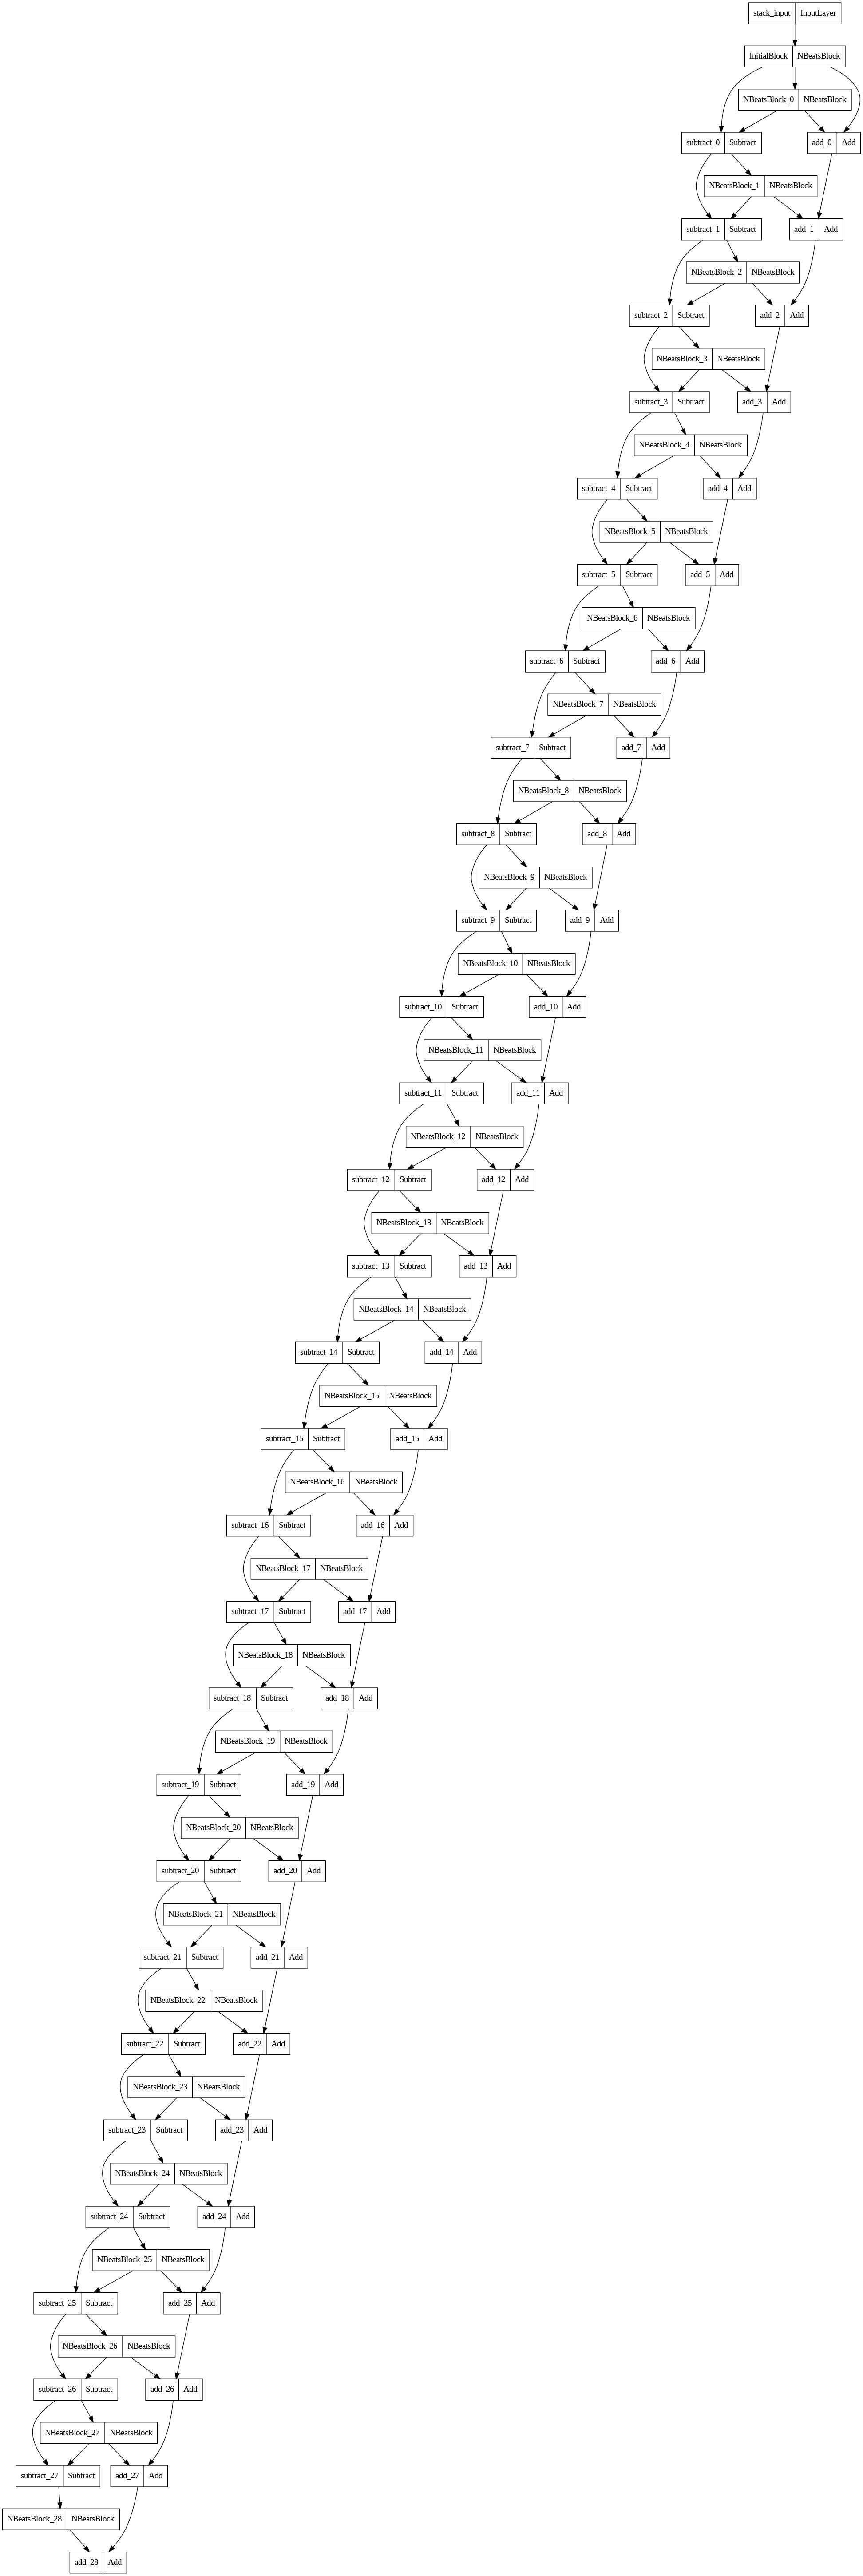

In [116]:
# Plot the N-BEATS model and inspect the arhictecure
tf.keras.utils.plot_model(model_7)

## Model 8: Creating an ensemble (stacking different models togheter)

An ensemble leverages the wisdom of the crowd effect.

It combines many different models to predict a common goal.

### Constructing and fitting an ensemble of models (using different loss functions)

In [ ]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=1000,
                        loss_fns=["mae", "mse", "mape"]
                        ):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned: 
  10 * len(["mae", "mse", "mape"]).
  """
  # Make empty liust for trained ensemble models
  ensemble_models=[]

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing the model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
          # Initialize dense layers with normal distribution for estimating prediction intervals
          tf.keras.layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
          tf.keras.layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
          tf.keras.layers.Dense(HORIZON)
      ])

      # Compile simple model with current loss function
      model.compile(
          loss=loss_function,
          optimizer=tf.keras.optimizers.Adam(),
          metrics=["mae", "mse"]
      )

      # Fit the current model
      model.fit(
          train_dataset,
          epochs=num_epochs,
          verbose=0,
          validation_data=test_data,
          callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                      patience=200,
                                                      restore_best_weights=True),
                     tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                patience=100,
                                                verbose=1)
                     ]
      )

      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models

In [118]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=10,
                                      num_epochs=1000
                                      )

Optimizing the model by reducing: mae for 1000 epochs, model number: 0

Epoch 972: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing the model by reducing: mse for 1000 epochs, model number: 0

Epoch 767: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 867: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing the model by reducing: mape for 1000 epochs, model number: 0

Epoch 129: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 229: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing the model by reducing: mae for 1000 epochs, model number: 1

Epoch 948: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing the model by reducing: mse for 1000 epochs, model number: 1

Epoch 367: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 467: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Opti

## Make predictions with the ensemble models

In [ ]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [ ]:
# Create a list of ensemble predictions
%%time
ensemble_preds = make_ensemble_preds(
    ensemble_models=ensemble_models,
    data=test_dataset
)
ensemble_preds

In [ ]:
# Evaluate ensemble model predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_preds
                                  )
ensemble_results

The  ensemble preds come out in multiple dimensions but to combine into point predictions we can leverage the mean of all of the predictions or the median - https://machinelearningmastery.com/combine-predictions-for-ensemble-learning/

In [ ]:
ensemble_mean = tf.reduce_mean(ensemble_preds, axis=0)
ensemble_mean[:10]

In [ ]:
ensemble_median = np.median(ensemble_preds, axis=0)
ensemble_median[:10]

In [ ]:
ensemble_results_mean = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_mean)
ensemble_results_mean

In [125]:
ensemble_results_median = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_median)
ensemble_results_median

{'mae': 566.9227505792156,
 'mse': 1142696.7115909604,
 'rmse': 1068.9699301621913,
 'mape': 2.555916437508755,
 'mase': 0.9959261455691734}

In [126]:
model_1_results

{'mae': 566.9008258970482,
 'mse': 1167956.1493508038,
 'rmse': 1080.7201993813217,
 'mape': 2.534413413599998,
 'mase': 0.9958876299792072}

Plotting the prediction intervals (uncertainty estimates) of our ensemble
So far we've been making point predictions with our models.

E.g. horizon = 1, our model predicts tomorrow's price of Bitcoin will be $50,000USD

Wouldn't it be helpful if we knew a range of where that prediction came from?

Instead of 50,000 USD on the dot, how about 48,000 to 52,000 USD?

One way to get the 95% confidence prediction intervals for a deep learning model is the bootstrap method:

1. Take the predictions from a number of randomly initialzed models
2. Measure the standard deviation of the predictions
3. Multiply the standard deviation by 1.96 (assuming the distribution is Gaussian/Normal, 95% of observations fall within 1.96 standard deviations of the mean)
4. To the get the prediction interval upper and lower bounds, add and subtract the value obtained in (3) to the mean/median of the predictions made in (1)
* https://en.wikipedia.org/wiki/1.96
* https://eng.uber.com/neural-networks-uncertainty-estimation/

In [127]:
# Find the upper and lower bounds of ensemble predictions
def get_upper_lower(preds): # 1. Take the predictions from a number of randomly intialized models
  # 2. Measure the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis=0)

  # 3. Multiply the standard deviation by 1.96
  interval = 1.96 * std
  
  # 4. Get the prediction interval upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval

  return lower, upper

In [128]:
# Get the upper and lower bounds of the 95% percent prediction interval
lower, upper = get_upper_lower(preds=ensemble_preds)
lower, upper

(<tf.Tensor: shape=(556,), dtype=float32, numpy=
 array([ 8694.298 ,  8700.834 ,  9009.206 ,  8620.245 ,  8650.006 ,
         8618.793 ,  8590.796 ,  8407.469 ,  8375.746 ,  8479.242 ,
         8122.8384,  8029.835 ,  7981.1772,  7542.9165,  7184.924 ,
         7206.3545,  7016.6367,  7134.8745,  7024.1064,  7449.5474,
         7343.895 ,  7672.6606,  7508.6963,  7324.3228,  7253.0825,
         7255.9937,  7146.301 ,  7328.772 ,  7459.669 ,  7497.5757,
         7504.9697,  7281.24  ,  7177.0186,  7135.2827,  7143.779 ,
         7184.7637,  7016.5767,  7045.434 ,  6807.963 ,  6514.0283,
         7299.7197,  7065.771 ,  7036.528 ,  7142.1567,  7163.4844,
         7109.4375,  7160.0205,  7174.8345,  7139.0303,  7174.3066,
         7273.185 ,  7353.798 ,  7206.752 ,  7122.549 ,  7120.669 ,
         6896.6885,  7213.353 ,  7277.7812,  7305.2695,  7646.7285,
         8017.8394,  8069.173 ,  7780.4683,  8020.6304,  8052.487 ,
         8095.2725,  8057.245 ,  8674.553 ,  8846.022 ,  8678.937 ,

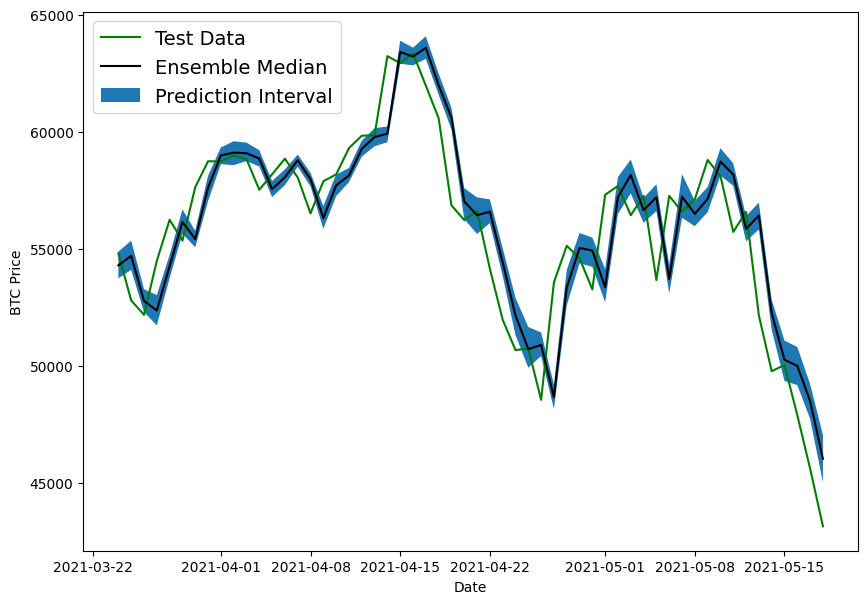

In [129]:
# Get the median/mean values of our ensemble preds
ensemble_media = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
offset=500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
# To plot the upper and lower bounds, I'll use fill_between
plt.fill_between(X_test.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:], label="Prediction Interval")
plt.legend(loc="upper left", fontsize=14)

**Note:** These prediction intervals are estimates themselves. And they have been created with the assumption that our model's data is from a normal distribution.

## Model 9: Train a model on the full historical data to make predictions into the future

In [130]:
# Train model on entire data to make prediction for the next day
X_all = bitcoin_prices_windowed.dropna().drop(["Price", "block_reward"], axis=1).to_numpy()
# Get labels
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

len(X_all), len(y_all)

(2780, 2780)

In [131]:
X_all[:10], y_all[:10]

(array([[121.795  , 120.65533, 121.33866, 118.67466, 108.58483, 125.455  ,
         123.65499],
        [123.033  , 121.795  , 120.65533, 121.33866, 118.67466, 108.58483,
         125.455  ],
        [124.049  , 123.033  , 121.795  , 120.65533, 121.33866, 118.67466,
         108.58483],
        [125.96116, 124.049  , 123.033  , 121.795  , 120.65533, 121.33866,
         118.67466],
        [125.27966, 125.96116, 124.049  , 123.033  , 121.795  , 120.65533,
         121.33866],
        [125.9275 , 125.27966, 125.96116, 124.049  , 123.033  , 121.795  ,
         120.65533],
        [126.38333, 125.9275 , 125.27966, 125.96116, 124.049  , 123.033  ,
         121.795  ],
        [135.24199, 126.38333, 125.9275 , 125.27966, 125.96116, 124.049  ,
         123.033  ],
        [133.20333, 135.24199, 126.38333, 125.9275 , 125.27966, 125.96116,
         124.049  ],
        [142.76333, 133.20333, 135.24199, 126.38333, 125.9275 , 125.27966,
         125.96116]]),
 array([123.033  , 124.049  , 125.9611

In [132]:
# Turn data into efficient running tensors

features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# Combine features and labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# Batch and prefetch for optimal performance
BATCH_SIZE = 1024
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [133]:
# Set random seed
tf.random.set_seed(42)

# Create the model
model_9 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(HORIZON),

])

# Compile the model
model_9.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam()
)

# Fit the model
model_9.fit(
    dataset_all,
    epochs=100,
    verbose=0
)

In [143]:
# How many timestesp to predict into the future?
INTO_FUTURE = 14

To make predictions into the future we want a function which:

1. Takes as input:
  * a list of values (Bitcoin historical data)
  * a trained model (such as `model_9`)
  * a window into the future to predict (our `INTO_FUTURE` variable)
  * the window size a model was trained on (`WINDOW_SIZE`) - the model can only predict on the same kind of data it was trained on
2. Creates an empty list for future forecasts (this will be returned at the end of the end, when it's full of predictions) and extracts the last `WINDOW_SIZE` values from the input values
3. Loop `INTO_FUTURE` times making a prediction on `WINDOW_SIZE` sequences which update to remove the first value and append the latest prediction

In [157]:
# 1. Create function to make predictions into the future
def make_future_forecasts(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Make future forecasts into_future steps after values ends.

  Returns future forecasts as a list of floats.
  """
  # 2. Create an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:]

  # 3. Make INTO_FUTURE numer of predictions, altering the data which gets predicted on each
  for _ in range(INTO_FUTURE):
    # Predict on the last window then append it again, again, again (our model will eventually start to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on:\n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

In [158]:
# Make forecast into the future
future_forecast = make_future_forecasts(values=y_all,
                                       model=model_9,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 [==============================] - 0s 24ms/step
Predicting on:
 [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] -> Prediction: 55877.88671875

1/1 [==============================] - 0s 30ms/step
Predicting on:
 [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 55877.88671875] -> Prediction: 50963.859375

1/1 [==============================] - 0s 24ms/step
Predicting on:
 [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 55877.88671875 50963.859375  ] -> Prediction: 50170.7578125

1/1 [==============================] - 0s 21ms/step
Predicting on:
 [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 55877.88671875 50963.859375   50170.7578125 ] -> Prediction: 48095.0390625

1/1 [==============================] - 0s 21ms/step
Predicting on:
 [47885.62525472 45604.61575361 43144.47129086 55877.88671875
 50963.859375   50170.7578125  48095.0390625 ] 

In [159]:
bitcoin_prices_windowed.tail()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2021-05-14,49764.132082,6.25,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672,56583.849879
2021-05-15,50032.693137,6.25,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672
2021-05-16,47885.625255,6.25,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679
2021-05-17,45604.615754,6.25,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426
2021-05-18,43144.471291,6.25,45604.615754,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651


### Plot future forecasts

In [160]:
def get_future_dates(start_date, into_future, offset=1):
  """
  Returns array of datetime values ranging from start_date to start_date+into_future
  """
  start_date = start_date + np.timedelta64(offset, "D") # specify start date, "D" stands for day
  end_date = start_date + np.timedelta64(into_future, "D") # specify end date
  return np.arange(start_date, end_date, dtype="datetime64[D]") # return a date range between start and end date

In [161]:
# Last timestep of timestpes (currently np.datetime64 format)
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2021-05-18 00:00:00')

In [162]:
# Get next two weeks of timesteps
next_time_steps = get_future_dates(start_date=last_timestep,
                                   into_future=INTO_FUTURE)
next_time_steps

array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01'], dtype='datetime64[D]')

In [163]:
# Insert last timestep/final price into next time steps and future forecasts so the plot doesn't look janky
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_prices[-1])
next_time_steps, future_forecast

(array(['2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21',
        '2021-05-22', '2021-05-23', '2021-05-24', '2021-05-25',
        '2021-05-26', '2021-05-27', '2021-05-28', '2021-05-29',
        '2021-05-30', '2021-05-31', '2021-06-01'], dtype='datetime64[D]'),
 array([43144.473, 55877.887, 50963.86 , 50170.758, 48095.04 , 47175.492,
        45983.742, 49016.82 , 54497.81 , 50282.31 , 49197.492, 47262.36 ,
        47543.29 , 48276.59 , 51785.418], dtype=float32))

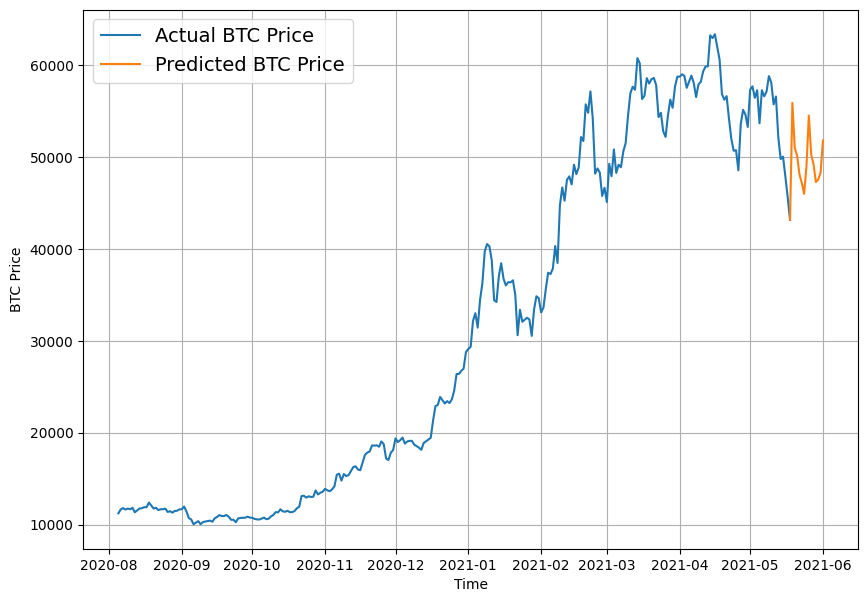

In [164]:
# Plot future price prediction of Bitcoin
plt.figure(figsize=(10, 7))
plot_time_series(bitcoin_prices.index, btc_prices, start=2500, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC Price")

## Model 10: Same as model 1 (but with turkey data - turkey problem)

In [165]:
# Let's introduce a turkey problem to the BTC data (price of BTC falls 100x in one day)
btc_price_turkey = btc_prices.copy()
btc_price_turkey[-1] = btc_price_turkey[-1] / 100

In [166]:
# Manufacture an extra price on the end (to showcase the Turkey problem)
btc_price_turkey[-10:]

[58788.2096789273,
 58102.1914262342,
 55715.5466512869,
 56573.5554719043,
 52147.8211869823,
 49764.1320815975,
 50032.6931367648,
 47885.6252547166,
 45604.6157536131,
 431.44471290860304]

In [167]:
# Get the timesteps for the turkey problem
btc_timesteps_turkey = np.array(bitcoin_prices.index)
btc_timesteps_turkey[-10:]

array(['2021-05-09T00:00:00.000000000', '2021-05-10T00:00:00.000000000',
       '2021-05-11T00:00:00.000000000', '2021-05-12T00:00:00.000000000',
       '2021-05-13T00:00:00.000000000', '2021-05-14T00:00:00.000000000',
       '2021-05-15T00:00:00.000000000', '2021-05-16T00:00:00.000000000',
       '2021-05-17T00:00:00.000000000', '2021-05-18T00:00:00.000000000'],
      dtype='datetime64[ns]')

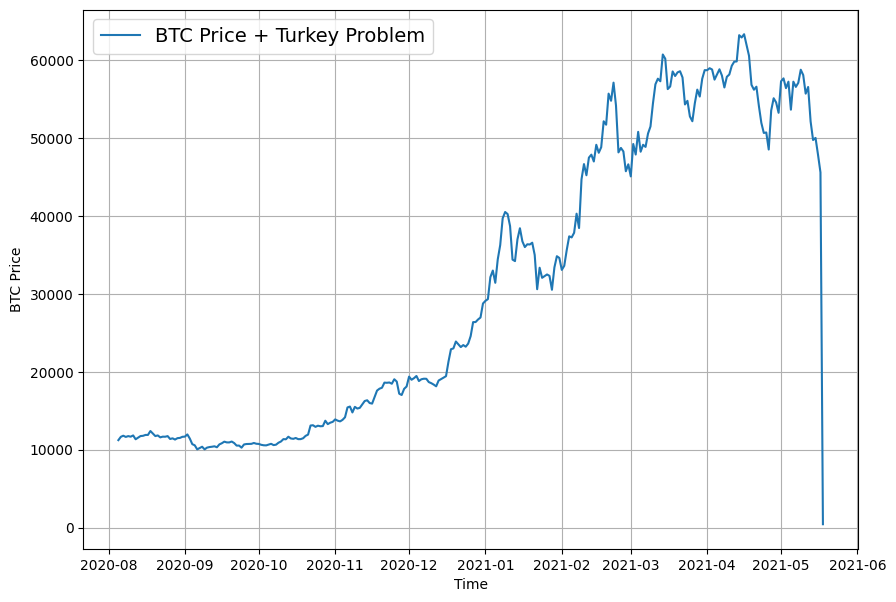

In [169]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=btc_timesteps_turkey,
                 values=btc_price_turkey,
                 format="-",
                 label="BTC Price + Turkey Problem",
                 start=2500)

In [170]:
# Create train and test sets for the turkey problem data
full_windows, full_labels = make_windows(np.array(btc_price_turkey), window_size=WINDOW_SIZE, horizon=HORIZON)

X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels)
len(X_train), len(X_test), len(y_train), len(y_test)

(2224, 556, 2224, 556)

In [171]:
# Set random seed
tf.random.set_seed(42)

# Create the model
turkey_model = tf.keras.models.clone_model(model_1)
turkey_model._name = "model_10_turkey_model"
turkey_model.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam()
)
turkey_model.fit(
    X_train,
    y_train,
    epochs=100,
    verbose=0,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[create_model_checkpoint(turkey_model.name)]
)

In [172]:
# Evaluate the model on test data
turkey_model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 786.8710


786.8709716796875

In [174]:
# Load best performing turkey model and evaluate on test data
turkey_model = tf.keras.models.load_model("/content/model_experiments/model_10_turkey_model")
turkey_model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 4ms/step - loss: 640.4192


640.419189453125

In [ ]:
# Make predictions with turkey model
turkey_preds = make_preds(turkey_model, X_test)
turkey_preds[:10]

In [176]:
# Evaluate turkey preds
turkey_results = evaluate_preds(y_true=y_test,
                                y_pred=turkey_preds)
turkey_results

{'mae': 17120.217941641466,
 'mse': 613715580.011928,
 'rmse': 23695.36118474478,
 'mape': 121.23530540940294,
 'mase': 26.493594139552812}

In [177]:
model_1_results

{'mae': 566.9008258970482,
 'mse': 1167956.1493508038,
 'rmse': 1080.7201993813217,
 'mape': 2.534413413599998,
 'mase': 0.9958876299792072}

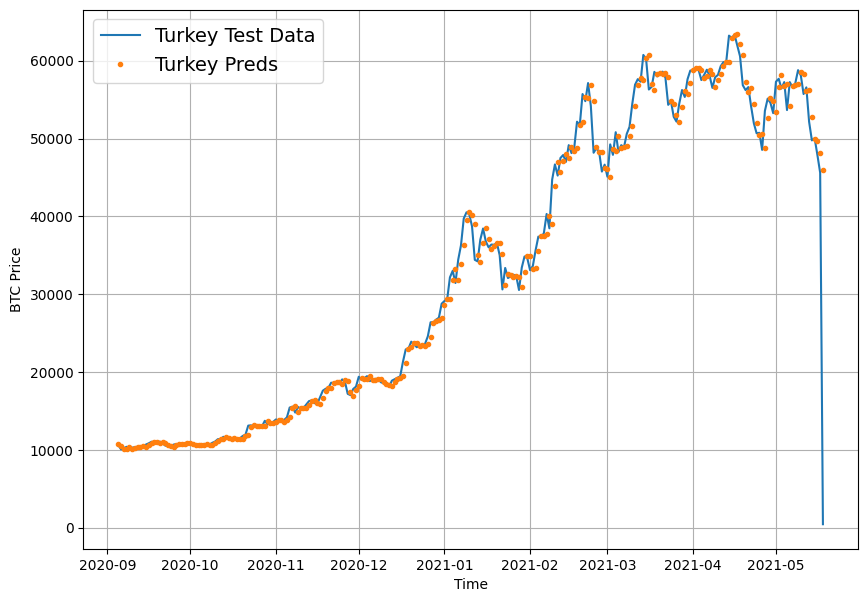

In [178]:
plt.figure(figsize=(10, 7))
offset=300
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=btc_price_turkey[-len(y_test):], 
                 format="-",
                 label="Turkey Test Data", 
                 start=offset)
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=turkey_preds,
                 label="Turkey Preds",
                 start=offset);

## Compare results

In [179]:
# Compare different model results (w = window, h = horizon, e.g. w=7 means a window size of 7)
model_results = pd.DataFrame({"naive_model": naive_results,
                              "model_1_dense_w7_h1": model_1_results,
                              "model_2_dense_w30_h1": model_2_results,
                              "model_3_dense_w30_h7": model_3_results,
                              "model_4_CONV1D": model_4_results,
                              "model_5_LSTM": model_5_results,
                              "model_6_multivariate": model_6_results,
                              "model_7_NBEATS": model_7_results,
                              "model_8_ensemble": ensemble_results,
                              "model_10_turkey": turkey_results}).T
model_results.head(10)                            

,mae,mse,rmse,mape,mase
naive_model,567.980227,1.147547e+06,1071.236260,2.516525,0.999570
model_1_dense_w7_h1,566.900826,1.167956e+06,1080.720199,2.534413,0.995888
model_2_dense_w30_h1,625.353952,1.309028e+06,1144.127609,2.874766,1.093125
model_3_dense_w30_h7,1248.194700,5.378426e+06,1428.462900,5.513557,2.221093
model_4_CONV1D,576.410706,1.193642e+06,1092.539342,2.580360,1.012594
model_5_LSTM,572.066413,1.173649e+06,1083.350861,2.563622,1.004962
model_6_multivariate,572.297995,1.189800e+06,1090.779572,2.569647,1.005369
model_7_NBEATS,579.958006,1.204192e+06,1097.356714,2.667539,1.018825
model_8_ensemble,577.977981,1.174612e+06,1083.722347,2.620764,1.015347
model_10_turkey,17120.217942,6.137156e+08,23695.361185,121.235305,26.493594


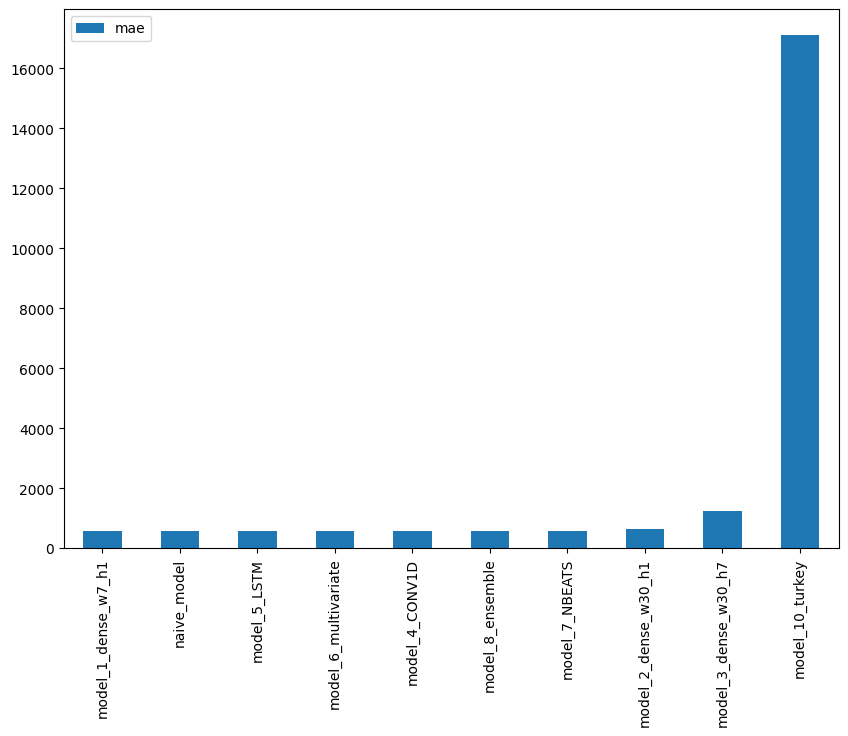

In [180]:
# Sort model results by MAE and plot them 
model_results[["mae"]].sort_values(by="mae").plot(figsize=(10, 7), kind="bar");